---
# Data Reduction Code

2-7-2025

By M. R. van Dijk

# Methodology

# Figure 2

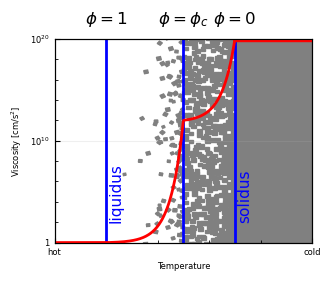

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.transforms as transforms

# Apply your custom style
plt.style.use('MJs-theme.mplstyle')

# Set up figure and primary axis
fig, ax = plt.subplots(figsize=(3.29, 2.8))

# Parameters for phi thresholds
phi1, phic, phi0 = 0.2, 0.5, 0.7

# Plot vertical lines
ax.axvline(phi1, color='blue', linewidth=2)
ax.axvline(phic, color='blue', linewidth=2)
ax.axvline(phi0, color='blue', linewidth=2)

# Add line top labels
ax.text(phi1, 1.05, r'$\phi=1$', ha='center', va='bottom', fontsize=12)
ax.text(phic, 1.05, r'$\phi=\phi_c$', ha='center', va='bottom', fontsize=12)
ax.text(phi0, 1.05, r'$\phi=0$', ha='center', va='bottom', fontsize=12)

# Add in-plot labels
ax.text(phi1 + 0.01, 0.1, 'liquidus', color='blue', rotation=90,
        va='bottom', ha='left', fontsize=11)
ax.text(phi0 + 0.01, 0.1, 'solidus', color='blue', rotation=90,
        va='bottom', ha='left', fontsize=11)

# Configure axes
ax.set_ylim(0, 1)
ax.set_yticks([0, 0.5, 1.0])
ax.set_yticklabels(['1', r'$10^{10}$', r'$10^{20}$'])

ax.set_xlim(0, 1)
ax.set_xticks([0, 1.0])
ax.set_xticklabels(['hot', 'cold'])
ax.set_xlabel('Temperature')
ax.set_ylabel('Viscosity [cm/s$^2$]')

# Jitter function
def jitter(x, y, phi, phi1=phi1, phi_crit=phic, phi0=phi0, k1=20, scale=0.02):
    if phi < phi1:
        return None
    elif phi1 <= phi < phi_crit:
        drop_prob = 0.6 * (np.exp(k1 * (phi - phi1)) - 1) / (np.exp(k1 * (phi_crit - phi1)) - 1)
    elif phi_crit <= phi < phi0:
        drop_prob = 0.6 + 0.4 * (np.exp(k1 * (phi - phi_crit)) - 1) / (np.exp(k1 * (phi0 - phi_crit)) - 1)
    else:
        return x, y

    if np.random.rand() < 1 - drop_prob:
        return None

    jitter_strength = scale * (1 - drop_prob)
    dx = np.random.uniform(-jitter_strength, jitter_strength)
    dy = np.random.uniform(-jitter_strength, jitter_strength)
    return x + dx, y + dy

# Data setup
x_vals = np.linspace(0, 1, 60)
log_y_vals = np.logspace(0, 20, 60)
y_vals = (np.log10(log_y_vals) - 0) / 20  # Normalize to [0,1]

# Rectangle base size
rect_w, rect_h = 0.02, 0.02

# Draw rectangles
for phi in x_vals:
    for y in y_vals:
        result = jitter(phi, y, phi)
        if result:
            xj, yj = result
            width, height = rect_w, rect_h

            if phi < phic:
                shrink = np.random.uniform(0.5, 0.8)
                width *= shrink
                height *= shrink
                angle = np.random.uniform(-45, 45)
            elif phic < phi0:
                shrink = np.random.uniform(0.8, 1.0)
                width *= shrink
                height *= shrink
                angle = 0
            else:
                angle = 0

            rect = Rectangle((xj - width / 2, yj - height / 2), width, height, color='grey')
            t = transforms.Affine2D().rotate_deg_around(xj, yj, angle) + ax.transData
            rect.set_transform(t)
            ax.add_patch(rect)

# Plot drop curve
ax2 = ax.twinx()
ax2.set_ylim(0, 1)
ax2.set_yticks([])

phi_curve = np.linspace(0, 1, 500)
drop_curve = np.piecewise(
    phi_curve,
    [phi_curve < phi1,
     (phi_curve >= phi1) & (phi_curve < phic),
     (phi_curve >= phic) & (phi_curve < phi0),
     phi_curve >= phi0],
    [
        0,
        lambda phi: 0.6 * (np.exp(20 * (phi - phi1)) - 1) / (np.exp(20 * (phic - phi1)) - 1),
        lambda phi: 0.6 + 0.4 * (np.exp(20 * (phi - phic)) - 1) / (np.exp(20 * (phi0 - phic)) - 1),
        0.99
    ]
)

ax2.plot(phi_curve, drop_curve, 'r-', linewidth=2)

plt.tight_layout()

#plt.savefig('rheo.pgf', bbox_inches='tight')
plt.show()

# Results

In [1]:
import os
import toml
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

import cmcrameri.cm as cmc
from scipy.interpolate import interp1d

from matplotlib.gridspec import GridSpec

In [2]:
# Volatiles to track
vol_list = ["H2O", "CO2", "H2", "CH4", "CO", "N2", "NH3", "S2", "SO2", "H2S"]

color_map = {
    "H2O": "#027FB1",
    "CO2": "#D24901",
    "H2" : "#008C01",
    "CH4": "#C720DD",
    "CO" : "#D1AC02",
    "N2" : "#870036",
    "NH3": "#675200",
    "S2" : "#FF8FA1",
    "SO2": "#00008B",
    "H2S": "#2eff71",
}

def extract_curve_metrics(data_dict, H_vals_sorted, N=30):
    """
    Extracts key timing and curve metrics from simulation data.

    Parameters:
        data_dict (dict): Dictionary of data indexed by H_tide values.
        H_vals_sorted (iterable): Sorted list of H_tide values.
        fO2 (float): Initial oxygen fugacity condition to filter data.
        N (int): Number of log-spaced points for interpolation (default: 300).

    Returns:
        base, start_times, stable_times, stop_times, sol_times, s (dicts)
    """
    
    metrics = {}
    
    for H in H_vals_sorted:
        for fO2_i, H_oceans, CH_ratio, SH_ratio, time, HC_a, phi, E in data_dict[H]:
        #for fO2_i, H_oceans, CH_ratio, SH_ratio, time, HC_a, phi, E, T_surf, P_surf in data_dict[H]:
            
            key = (fO2_i, H, H_oceans, CH_ratio, SH_ratio)         
            
            # Solidification time (phi < 0.005)
            sol_index = next((i for i, x in enumerate(phi) if x < 0.005), -1)
            
            sol_time = time.iloc[int(sol_index)]
            
            if E is not None:
                # 1. Start of tidal heating
                index0 = np.argmax(E > 0)
                start_time = time.iloc[index0]

                # 2. dE/dt
                dEdt = np.gradient(E) / np.gradient(time)

                # 3. Global maximum in dE/dt
                peak_index = np.argmax(dEdt)
                max_dEdt = dEdt[peak_index]

                # 4. Plateau start (where dE/dt ~ max_dEdt)
                threshold = 0.95 * max_dEdt
                stable_indices = np.where(dEdt > threshold)[0]
                                
                plateau_start_index = next((x for x in stable_indices), -1)#[0]
                stable_time = time.iloc[plateau_start_index]

                if dEdt[plateau_start_index]+ 10 <= 10^20:
                    continue
                
                # 5. Stop time (when dE/dt < 0.5 * max_dEdt after peak)
                decline_indices = np.where((dEdt < 0.5 * max_dEdt) & (np.arange(len(dEdt)) > peak_index))[0]
                decline_start_index = decline_indices[0] if len(decline_indices) > 0 else sol_index
                stop_time = time.iloc[decline_start_index] 

                vmr_idx, vmr_time = [(i, t) for i, t in enumerate(time) if t <= stop_time and t <= sol_time][-2]

                # Final index for time slicing
                
                try:
                    final_index = [i for i, dE in enumerate(dEdt) if dE > 0][-1]
                except:
                    final_index = -1
                t_original = time.iloc[index0:final_index]

                # Recompute dEdt over sliced range
                dEdt_slice = np.gradient(E.iloc[index0:final_index]) / np.gradient(t_original)

                # Relative spacing and normalization
                spacing_rel = np.cumsum(dEdt_slice)
                spacing_abs = spacing_rel / np.max(spacing_rel) * 5 + 1

                # Log-spaced time points
                t_log = np.logspace(np.log10(t_original.iloc[0]), np.log10(t_original.iloc[-1]), num=N)

                # Interpolated spacing_abs over log time
                interp_func = interp1d(t_original, spacing_abs, kind='linear', bounds_error=False, fill_value="extrapolate")
                spacing_abs_log = interp_func(t_log)
                s = (t_log, spacing_abs_log)
                
                
            else:
                start_time, stable_time, stop_time, vmr_time, s = 0, 0, 0, sol_time, np.zeros(N)           
            
            metrics[key] = (start_time, stable_time, stop_time, vmr_time, s, sol_time)

    return metrics


def get_case_label(fO2, H, H_oceans, CH_ratio, SH_ratio):
    label = ""
    
    # Determine prefix
    if H_oceans == 3 and CH_ratio == 1 and SH_ratio == 2:
        label = "X"
    elif H_oceans != 3:
        label = f"H+{H_oceans}"
    elif CH_ratio != 1:
        label = f"C+{CH_ratio}"
    elif SH_ratio != 2:
        label = f"S+{SH_ratio}"
    
    # Format fO2 with proper sign
    fO2_str = f"f{'-' if fO2 < 0 else '+'}{abs(fO2)}"

    if H == 0:
        return f"{label}/{fO2_str}/h+0"
    else:
        return f"{label}/{fO2_str}/h-{int(-np.log10(H))}"

# Figure 3

In [6]:
def get_data(root_path, N, data_dict, vmr_dict):

    for i in range(N):
        case_path = os.path.join(root_path, f"case_{i:05d}")
        config_path = os.path.join(case_path, "init_coupler.toml")
        csv_path = os.path.join(case_path, "runtime_helpfile.csv")

        if not (os.path.exists(config_path) and os.path.exists(csv_path)):
            print("Skipping ", i)
            continue

        config = toml.load(config_path)
                
        try:
            H_tide = config["orbit"]["dummy"]["H_tide"]
            Phi_tide = config["orbit"]["dummy"]["Phi_tide"]
            shutdown = config["orbit"]["dummy"]["shutdown"]
        except KeyError:
            H_tide = 0
            Phi_tide = "<0.3"
            shutdown = None
            
        Pt_lt = bool(Phi_tide[0] == "<")
        Pt_va = float(Phi_tide[1:])
            
        fO2 = config["outgas"]["fO2_shift_IW"]
        H_oceans = config["delivery"]["elements"]["H_oceans"]
        CH_ratio = config["delivery"]["elements"]["CH_ratio"]
        SH_ratio = config["delivery"]["elements"]["SH_ratio"]
            #continue
            
        if fO2 != 0:
            continue           
        if H_oceans != 3:
            continue        
        if CH_ratio != 1:
            continue         
        if SH_ratio != 2:
            continue            
#         if H_tide != 1e-7:
#             continue     
        if Pt_va != 0.3:
            continue
                        
        df = pd.read_csv(csv_path, sep="\t")
        df = df[df["Time"] > 0]
        if df.empty:
            continue

        time = df["Time"]
        HC_a = df["H/C_atm"]
        H2O_a = df["H2O_mol_atm"]
        CO2_a = df["CO2_mol_atm"]
        CH4_a = df["CH4_mol_atm"]
        H2_a  = df[ "H2_mol_atm"]
        H2O_t = df["H2O_mol_total"]
        H2O_bar = df["H2O_bar"]
        rheo = df["RF_depth"]
        phi = df["Phi_global"]
        T_surf = df["T_surf"]
        
        F_asf = df["F_ins"] * 0.375 * np.cos(48.19 * np.pi/180.0)
        F_tidal = df["F_tidal"]
        F_net = df["F_atm"]
        
        F_olr = df["F_olr"]
        F_upw = df["F_olr"] + df["F_sct"]
        F_int = df["F_int"]
        F_radio = df["F_radio"]
        
        if H_tide == 0:
            E = None
        else:
            E = df["tot_tid_E"]
            
        data_dict.setdefault(H_tide, []).append((fO2, H_oceans, CH_ratio, SH_ratio, time, (shutdown, F_tidal), phi, E))

In [7]:
# Define root path
root_path_shutdown  = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_shutdown"

# Prepare data storage
data_dict = {}
vmr_dict = {}

# Get data
get_data(root_path_shutdown, 16, data_dict, vmr_dict)

# --- Create Color Map Using Scientific Colormap ---
H_vals_sorted = sorted(data_dict)

# Replace H=0 with a small dummy value for log scale (for color map only)
H_for_log = [1e-11 if H == 0 else H for H in H_vals_sorted]
norm = plt.Normalize(vmin=np.log10(min(H_for_log)), vmax=np.log10(max(H_for_log)))

# colormap from Scientific Colour Maps
colormap = cmc.batlowK

# Apply the norm using the adjusted list
H_tide_color_map = {
    H: colormap(norm(np.log10(1e-11 if H == 0 else H)))
    for H in H_vals_sorted
}

# Get timestamps
metrics = extract_curve_metrics(data_dict, H_vals_sorted)

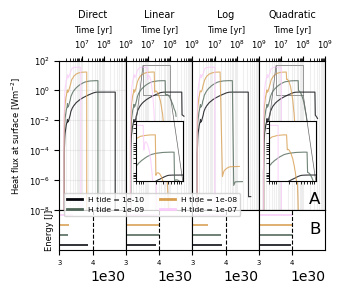

In [8]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

# --- Constants ---
H_tide_vals = sorted(h for h in H_vals_sorted if h != 0)
shutdowns = ["direct", "linear", "log", "quadratic"]
shutdown_to_ax_idx = {s: i for i, s in enumerate(shutdowns)}

markers = {0.1: "^", 0.5: "v", 1: "o", 2: "s"}
colors = {H: H_tide_color_map[H] for H in H_tide_vals}
budget = 4e30

# --- Figure and Grid ---
fig = plt.figure(figsize=(3.29, 2.8))  # taller to fit 2 rows
gs = gridspec.GridSpec(2, 4, height_ratios=[3, 0.8], hspace=0, wspace=0.0)

main_axes = [fig.add_subplot(gs[0, i]) for i in range(4)]
bar_axes = [fig.add_subplot(gs[1, i]) for i in range(4)]

# --- Store energy bars ---
Evals_by_shutdown = {s: [] for s in shutdowns}

# --- Loop through all data ---
for H in H_tide_vals:
    for fO2_i, H_oceans, CH_ratio, SH_ratio, time, (shutdown, HC_a), phi, E in data_dict[H]:
        key = (fO2_i, H, H_oceans, CH_ratio, SH_ratio)
        if key not in metrics or shutdown not in shutdown_to_ax_idx:
            continue

        ax_idx = shutdown_to_ax_idx[shutdown]
        main_ax = main_axes[ax_idx]
        bar_ax = bar_axes[ax_idx]

        # Final energy value
        E_final = E.iloc[-1]
        Evals_by_shutdown[shutdown].append((H, E_final))

        # --- Main plot ---
        main_ax.plot(
            time,
            HC_a,
            label=f"H={H:.0e}",
            color=colors[H],
            lw=0.8,
            alpha=0.8
        )

# --- Format main plots (top row) ---
for i, shutdown in enumerate(shutdowns):
    ax = main_axes[i]
    ax.set_title(shutdown.capitalize(), fontsize=7)
    ax.set_xlim(1.01e6, 1e9)
    ax.set_ylim(1e-8, 1e2)
    ax.set_xscale("log")
    ax.set_yscale("log")
    if i != 0:
        ax.set_yticks([])
    ax.grid(which='both', axis='both', alpha=0.2)
    ax.tick_params(axis='both', labelsize=6)
    ax.xaxis.tick_top()
    # Time axis on top
    ax.xaxis.set_label_position('top')
    ax.tick_params(labeltop=True, labelbottom=False)
    if i == 0:
        ax.set_ylabel("Heat flux at surface [Wm$^{-2}$]", fontsize=6)

    ax.set_xlabel("Time [yr]", fontsize=6)
    
# --- Format bar plots (bottom row) ---
for i, shutdown in enumerate(shutdowns):
    bar_ax = bar_axes[i]
    ax_data = sorted(Evals_by_shutdown[shutdown], key=lambda t: t[0])  # sort by H

    for j, (H, E_final) in enumerate(ax_data):
        bar_ax.barh(j, E_final, color=colors[H], height=0.2, alpha=0.8)

    bar_ax.axvline(budget, color='k', linestyle='--', lw=0.8)
    bar_ax.set_xlim(3e30, 4.99e30)
    bar_ax.set_ylim(-0.5, len(ax_data) - 0.5)
    bar_ax.set_yticks([])
    bar_ax.tick_params(axis='x', labelsize=5)

    # Energy budget label on bottom row
    if i == 0:
        bar_ax.set_ylabel("Energy [J]", fontsize=6)

plt.text(4.5e30, 4.2, "A", fontsize=12)
plt.text(4.5e30, 1.2, "B", fontsize=12)
        
legend_elements = []
    
for H in H_tide_vals:
    color = H_tide_color_map[H]
    legend_elements.append(
        Line2D([0], [0], color=color, lw=2, label=f"H tide = {H:.0e}")
    )

fig.legend(handles=legend_elements, loc='lower center', ncol=2, bbox_to_anchor=(0.44, 0.24), fontsize=5.5)

    
# --- Layout ---
fig.tight_layout(pad=0.2)

# Define zoomed-in regions for Linear and Quadratic
zoom_configs = {
    "linear": {"xlim": (6e6, 1e8), "ylim": (5e-1, 5e1)},
    "quadratic": {"xlim": (6e6, 1e8), "ylim": (5e-1, 5e1)}
}

for shutdown in ["linear", "quadratic"]:
    ax_idx = shutdown_to_ax_idx[shutdown]
    main_ax = main_axes[ax_idx]
    
    # Create inset
    inset_ax = inset_axes(main_ax, width="70%", height="40%", loc="lower left",
                          bbox_to_anchor=(0.05, 0.15, 1, 1), bbox_transform=main_ax.transAxes)

    # Re-plot the same curves in the inset
    for H in H_tide_vals:
        for fO2_i, H_oceans, CH_ratio, SH_ratio, time, (shut, HC_a), phi, E in data_dict[H]:
            if shut != shutdown:
                continue
            key = (fO2_i, H, H_oceans, CH_ratio, SH_ratio)
            if key not in metrics:
                continue
            inset_ax.plot(time, HC_a, color=colors[H], lw=0.8, alpha=0.8)

    # Set zoom limits
    inset_ax.set_xlim(*zoom_configs[shutdown]["xlim"])
    inset_ax.set_ylim(*zoom_configs[shutdown]["ylim"])
    inset_ax.set_xscale("log")
    inset_ax.set_yscale("log")
    inset_ax.set_xticks([])
    inset_ax.set_yticks([])
    #inset_ax.tick_params(labelsize=5, length=2)

    # Optional: mark the zoomed area
    mark_inset(main_ax, inset_ax, loc1=2, loc2=4, fc="none", ec="0.4", lw=0.5)

#plt.savefig('shutdowns.pgf')

plt.show()

# Figure 4

In [9]:
def get_data(root_path, N, data_dict, vmr_dict):

    for i in range(N):
        case_path = os.path.join(root_path, f"case_{i:05d}")
        config_path = os.path.join(case_path, "init_coupler.toml")
        csv_path = os.path.join(case_path, "runtime_helpfile.csv")

        if not (os.path.exists(config_path) and os.path.exists(csv_path)):
            print("Skipping ", i)
            continue

        config = toml.load(config_path)
                
        try:
            H_tide = config["orbit"]["dummy"]["H_tide"]
            Phi_tide = config["orbit"]["dummy"]["Phi_tide"]
            shutdown = config["orbit"]["dummy"]["shutdown"]
        except KeyError:
            H_tide = 0
            Phi_tide = "<0.3"
            shutdown = None
            
        Pt_lt = bool(Phi_tide[0] == "<")
        Pt_va = float(Phi_tide[1:])
            
        fO2 = config["outgas"]["fO2_shift_IW"]
        H_oceans = config["delivery"]["elements"]["H_oceans"]
        CH_ratio = config["delivery"]["elements"]["CH_ratio"]
        SH_ratio = config["delivery"]["elements"]["SH_ratio"]
            #continue
            
#         if fO2 != 0:
#             continue           
        if H_oceans != 3:
            continue        
        if CH_ratio != 1:
            continue         
        if SH_ratio != 2:
            continue            
#         if H_tide != 1e-7:
#             continue     
        if Pt_va != 0.3:
            continue
                        
        df = pd.read_csv(csv_path, sep="\t")
        df = df[df["Time"] > 0]
        if df.empty:
            continue

        time = df["Time"]
        HC_a = df["H/C_atm"]
        H2O_a = df["H2O_mol_atm"]
        CO2_a = df["CO2_mol_atm"]
        CH4_a = df["CH4_mol_atm"]
        H2_a  = df[ "H2_mol_atm"]
        H2O_t = df["H2O_mol_total"]
        H2O_bar = df["H2O_bar"]
        rheo = df["RF_depth"]
        phi = df["Phi_global"]
        T_surf = df["T_surf"]
        #P_surf = np.array(df["F_atm"])
        
        F_asf = df["F_ins"] * 0.375 * np.cos(48.19 * np.pi/180.0)
        F_tidal = df["F_tidal"]
        F_net = df["F_atm"]
        
        F_olr = df["F_olr"]
        F_upw = df["F_olr"] + df["F_sct"]
        F_int = df["F_int"]
        F_radio = df["F_radio"]
        
        if H_tide == 0:
            E = None
        else:
            E = df["tot_tid_E"]
                        
        data_dict.setdefault(H_tide, []).append((fO2, H_oceans, CH_ratio, SH_ratio, time, 1-rheo, phi, E)) 
        
        key = (fO2, H_tide, H_oceans, CH_ratio, SH_ratio)

        for _, row in df.iterrows():
            t = row["Time"]
            vmr_list = [row[vol + "_vmr"] for vol in vol_list]

            if key not in vmr_dict:
                vmr_dict[key] = {}
            vmr_dict[key][t] = vmr_list

In [10]:
# Define root path
root_path           = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_test_6"
root_path_final_H   = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_2V2"
root_path_final_C   = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_3"
root_path_final_S   = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_4"
root_path_final_H_2 = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_5_H"
root_path_final_C_2 = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_5_C"
root_path_final     = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_6"
root_path_final_2   = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_7V2"
root_path_final_C_2 = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_8V2"

# Prepare data storage
data_dict = {}
vmr_dict = {}

# Get data
get_data(root_path, 9, data_dict, vmr_dict)

get_data(root_path_final_H, 36, data_dict, vmr_dict)
get_data(root_path_final_C, 36, data_dict, vmr_dict)
get_data(root_path_final_S, 36, data_dict, vmr_dict)
get_data(root_path_final_H_2, 24, data_dict, vmr_dict)
get_data(root_path_final_C_2, 24, data_dict, vmr_dict)
get_data(root_path_final, 15, data_dict, vmr_dict)
# get_data(root_path_final_2, 6, data_dict, vmr_dict)
# get_data(root_path_final_C_2, 6, data_dict, vmr_dict)

# --- Create Color Map Using Scientific Colormap ---
H_vals_sorted = sorted(data_dict)

# Replace H=0 with a small dummy value for log scale (for color map only)
H_for_log = [1e-11 if H == 0 else H for H in H_vals_sorted]
norm = plt.Normalize(vmin=np.log10(min(H_for_log)), vmax=np.log10(max(H_for_log)))

# colormap from Scientific Colour Maps
colormap = cmc.batlowK

# Apply the norm using the adjusted list
H_tide_color_map = {
    H: colormap(norm(np.log10(1e-11 if H == 0 else H)))
    for H in H_vals_sorted
}

# Get timestamps
metrics = extract_curve_metrics(data_dict, H_vals_sorted)

3.88397322e+30
4.00676066e+30
4.40383917e+30
4.00000255e+30
3.9290176e+30
3.99996858e+30
4e+30
4.00991594e+30
3.98145104e+30
3.99999999e+30
4e+30
4e+30
Skipping  1
Skipping  3
Skipping  1
Skipping  2
Skipping  3
2.34165274e+30
4.1975369e+30
3.99999999e+30
4e+30
3.97252614e+30
3.99999998e+30
4e+30
4.18976189e+30
0.0
0.0
Skipping  8
Skipping  9
Skipping  10
Skipping  11
Skipping  12
Skipping  13
Skipping  14
Skipping  15
Skipping  16
Skipping  17
Skipping  18
Skipping  19
Skipping  20
Skipping  21
Skipping  22
Skipping  23
Skipping  0


/tmp/ipykernel_3741220/75479046.py:50: RuntimeWarning: divide by zero encountered in divide
  dEdt = np.gradient(E) / np.gradient(time)
/tmp/ipykernel_3741220/75479046.py:82: RuntimeWarning: divide by zero encountered in divide
  dEdt_slice = np.gradient(E.iloc[index0:final_index]) / np.gradient(t_original)
/tmp/ipykernel_3741220/75479046.py:86: RuntimeWarning: invalid value encountered in divide
  spacing_abs = spacing_rel / np.max(spacing_rel) * 5 + 1


(0.0, 0, 3.0, 1.0, 2.0)
(0.0, 1e-10, 3.0, 1.0, 2.0)
(0.0, 1e-09, 3.0, 1.0, 2.0)
(0.0, 1e-08, 3.0, 1.0, 2.0)
(0.0, 1e-07, 3.0, 1.0, 2.0)
(0.0, 1e-07, 3.0, 1.0, 2.0)


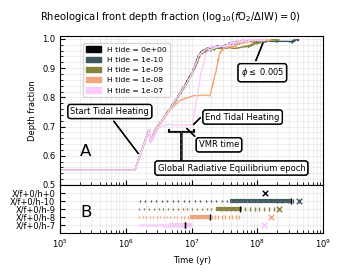

In [13]:
import matplotlib.pyplot as plt

plt.style.use('MJs-theme.mplstyle')

fO2 = 0
H_ref = 0  # Reference H_tide
N = 30

# --- Extract curves ---
base = {}

for H in H_vals_sorted:
    for fO2_i, H_oceans, CH_ratio, SH_ratio, time, HC_a, phi, E in data_dict[H]:
        if fO2_i == fO2 and H_oceans == 3 and CH_ratio == 1 and SH_ratio == 2:
                                    
            base[H] = (time, HC_a)
            key = (fO2_i, H, H_oceans, CH_ratio, SH_ratio) 
            label = get_case_label(*key)
            start_time, stable_time, stop_time, vmr_time, s, sol_time = metrics[key] 
            
            break

# --- Create plot with subplots: upper = HC_a, lower = bars ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(3.39, 3), sharex=True, 
                               gridspec_kw={"height_ratios": [4, 1.3], "hspace": 0})

# --- Upper plot: H2O fractions ---
fig.suptitle(f"Rheological front depth fraction (log$_{{10}}$($f$O$_2 / \Delta \mathrm{{IW}}) = {fO2}$)")

for i, H in enumerate(H_vals_sorted):
    for fO2_i, H_oceans, CH_ratio, SH_ratio, time, HC_a, phi, E in data_dict[H]:
        if fO2_i != fO2 or H_oceans != 3 or SH_ratio != 2:
            continue

        color = H_tide_color_map[H]
        ax1.plot(time, HC_a, color=color)
            
ax1.set_xscale("log")
ax1.set_xlim(1e5, 1e9)
ax1.set_ylim(0.5, 1.01)
ax1.set_ylabel("Depth fraction")

# --- Lower plot: horizontal bars between vertical markers ---
#bar_y = np.arange(len(H_vals_bottom))
bar_y = np.arange(len(H_vals_sorted))
bar_height = 0.8
ax2.set_yticks(bar_y)
#ax2.set_yticklabels([f"{H:.0e}" for H in H_vals_bottom])

ytick_labels = []

for H in H_vals_sorted: #H_vals_bottom:
    found_case = False
    if H not in data_dict:
        ytick_labels.append(f"H={H:.0e}")
        continue

    for fO2_i, H_oceans, CH_ratio, SH_ratio, *_ in data_dict[H]:
        if fO2_i == fO2 and H_oceans == 3:  # Match main fO2
            label = get_case_label(fO2, H, H_oceans, CH_ratio, SH_ratio)            
            ytick_labels.append(label)
            found_case = True
            break
    
    if not found_case:
        ytick_labels.append(f"H={H:.0e}")  # fallback

ax2.set_yticklabels(ytick_labels)

ax2.set_xlabel("Time (yr)")

for i, H in enumerate(H_vals_sorted): #enumerate(H_vals_bottom):
    
    for fO2_i, H_oceans, CH_ratio, SH_ratio, time, HC_a, phi, E in data_dict[H]:
        if fO2_i == fO2 and H_oceans == 3 and SH_ratio == 2:
                                    
            base[H] = (time, HC_a)

            key = (fO2_i, H, H_oceans, CH_ratio, SH_ratio) 

            print(key)
            
            start_time, stable_time, stop_time, vmr_time, s, sol_time = metrics[key]
        
            y = bar_y[i]
            color_H = H_tide_color_map[H]

            if H != 0:
                if start_time < stable_time:
                    ax2.scatter(s[0], y*np.ones(len(s[0])), color=color_H, s=s[1], marker='|', zorder=10)

                if stable_time < stop_time:
                    ax2.hlines(y, stable_time, stop_time, color=color_H, linestyle='-', linewidth=3, zorder=1)

                ax2.scatter(vmr_time, y, color='black', marker='|', zorder=10)

            ax2.scatter(sol_time, y, color=color_H, marker='x', zorder=10)
            
            annotations = True
            
            if annotations and H == 1e-7:
                colors = [color_map.get(vol, "#cccccc") for vol in vol_list]

                # Choose a specific key to annotate
                y = 0.6       

                color = "black"
                color_bkg = "white"

                ax1.annotate('Start Tidal Heating',
                    xy=(start_time, y), xycoords='data',
                    xytext=(-50, 30), textcoords='offset points',
                    bbox=dict(boxstyle="round", fc=color_bkg, ec=color, lw=1),
                    arrowprops=dict(arrowstyle="-", relpos=(0.5, 0), color=color))

                from matplotlib.patches import FancyArrowPatch

                # Define coordinates
                start = (7e6, y + 0.09)  # data point to annotate
                end = ax1.transData.transform(start) + np.array([50, -40])  # offset in screen coords
                end = ax1.transData.inverted().transform(end)  # convert back to data coords
                end_2 = ax1.transData.transform(start) + np.array([0, -40])  # offset in screen coords
                end_2 = ax1.transData.inverted().transform(end_2)  # convert back to data coords

                # Draw the arrow
                arrow = FancyArrowPatch(
                    posA=end_2,  # tail
                    posB=start,  # head (arrow points to the data point)
                    arrowstyle='-[',  # bracket arrow
                    mutation_scale=9,  # overall size of arrow
                    lw=1.5,
                    color=color
                )
                ax1.add_patch(arrow)

                # Draw the text box
                ax1.text(
                    end[0], end[1], 'Global Radiative Equilibrium epoch',
                    bbox=dict(boxstyle="round", fc=color_bkg, ec=color, lw=1),
                    ha='center', va='top'
                )


                ax1.annotate('VMR time',
                    xy=(vmr_time, 0.7), xycoords='data',
                    xytext=(10, -15), textcoords='offset points',
                    bbox=dict(boxstyle="round", fc=color_bkg, ec=color, lw=1),
                    arrowprops=dict(arrowstyle="-", relpos=(0, 1), color=color))

                ax1.annotate('End Tidal Heating',
                    xy=(10e6, 0.7), xycoords='data',
                    xytext=(10, 5), textcoords='offset points',
                    bbox=dict(boxstyle="round", fc=color_bkg, ec=color, lw=1),
                    arrowprops=dict(arrowstyle="-", relpos=(0, 1), color=color))

                lbl = r'$\phi \leq$ 0.005'

                ax1.annotate(lbl,
                    xy=(sol_time, 0.995), xycoords='data',
                    xytext=(-16.8, -25), textcoords='offset points',
                    bbox=dict(boxstyle="round", fc=color_bkg, ec=color, lw=1),
                    arrowprops=dict(arrowstyle="-", relpos=(0.3, 1), color=color))

            
ax2.set_xscale("log")
ax2.set_xlim(1e5, 1e9)
#ax2.set_ylim(-1, len(H_vals_bottom))
ax2.set_ylim(len(H_vals_sorted), -1)

ax2.yaxis.set_minor_locator(plt.NullLocator())

ax1.grid(which='both', axis='both', alpha=0.2)
ax2.grid(which='both', axis='both', alpha=0.2)

ax1.text(2e5, 0.6, "A", fontsize=12)
ax2.text(2e5, 3, "B", fontsize=12)

# --- Legend ---
color_legend = [
    Patch(color=H_tide_color_map[H], label=f"H tide = {H:.0e}") for H in H_vals_sorted
]
linestyle_legend = [
    Line2D([0], [0], color='k', label=f"CH_ratio = {h:.2f}")
    for h in sorted(H_vals_sorted)
]

fig.legend(handles=color_legend, # + linestyle_legend,
           loc='center',
           ncol=1,
           bbox_to_anchor=(0.37, 0.78))

plt.tight_layout(rect=[0, 0.1, 1, 1])

#plt.savefig('Rheo_tide_timeline.pgf')

plt.show()


# Figure 5

In [21]:
def get_data(root_path, N, data_dict, vmr_dict):

    for i in range(N):
        case_path = os.path.join(root_path, f"case_{i:05d}")
        config_path = os.path.join(case_path, "init_coupler.toml")
        csv_path = os.path.join(case_path, "runtime_helpfile.csv")

        if not (os.path.exists(config_path) and os.path.exists(csv_path)):
            print("Skipping ", i)
            continue

        config = toml.load(config_path)
                
        try:
            H_tide = config["orbit"]["dummy"]["H_tide"]
            Phi_tide = config["orbit"]["dummy"]["Phi_tide"]
            shutdown = config["orbit"]["dummy"]["shutdown"]
        except KeyError:
            H_tide = 0
            Phi_tide = "<0.3"
            shutdown = None
            
        Pt_lt = bool(Phi_tide[0] == "<")
        Pt_va = float(Phi_tide[1:])
            
        fO2 = config["outgas"]["fO2_shift_IW"]
        H_oceans = config["delivery"]["elements"]["H_oceans"]
        CH_ratio = config["delivery"]["elements"]["CH_ratio"]
        SH_ratio = config["delivery"]["elements"]["SH_ratio"]
            #continue
            
        if fO2 != 0:
            continue           
        if H_oceans != 3:
            continue        
        if CH_ratio != 1:
            continue         
        if SH_ratio != 2:
            continue            
#         if H_tide != 1e-7:
#             continue     
        if Pt_va != 0.3:
            continue
                        
        df = pd.read_csv(csv_path, sep="\t")
        df = df[df["Time"] > 0]
        if df.empty:
            continue

        time = df["Time"]
        HC_a = df["H/C_atm"]
        H2O_a = df["H2O_mol_atm"]
        CO2_a = df["CO2_mol_atm"]
        CH4_a = df["CH4_mol_atm"]
        H2_a  = df[ "H2_mol_atm"]
        H2O_t = df["H2O_mol_total"]
        H2O_bar = df["H2O_bar"]
        rheo = df["RF_depth"]
        phi = df["Phi_global"]
        T_surf = df["T_surf"]
        
        F_asf = df["F_ins"] * 0.375 * np.cos(48.19 * np.pi/180.0)
        F_tidal = df["F_tidal"]
        F_net = df["F_atm"]
        
        F_olr = df["F_olr"]
        F_upw = df["F_olr"] + df["F_sct"]
        F_int = df["F_int"]
        F_radio = df["F_radio"]
        
        if H_tide == 0:
            E = None
        else:
            E = df["tot_tid_E"]
            
        data_dict.setdefault(H_tide, []).append((fO2, H_oceans, CH_ratio, SH_ratio, time, (F_net, F_asf, F_olr, F_upw, F_int, F_tidal, F_radio), phi, E))
        
        key = (fO2, H_tide, H_oceans, CH_ratio, SH_ratio)

        for _, row in df.iterrows():
            t = row["Time"]
            vmr_list = [row[vol + "_vmr"] for vol in vol_list]

            if key not in vmr_dict:
                vmr_dict[key] = {}
            vmr_dict[key][t] = vmr_list

In [22]:
# Define root path
root_path           = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_test_6"
root_path_final_H   = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_2V2"
root_path_final_C   = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_3"
root_path_final_S   = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_4"
root_path_final_H_2 = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_5_H"
root_path_final_C_2 = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_5_C"
root_path_final     = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_6"
root_path_final_2   = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_7V2"
root_path_final_C_2 = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_8V2"

# Prepare data storage
data_dict = {}
vmr_dict = {}

# Get data
get_data(root_path, 9, data_dict, vmr_dict)

get_data(root_path_final_H, 36, data_dict, vmr_dict)

# --- Create Color Map Using Scientific Colormap ---
H_vals_sorted = sorted(data_dict)

# Replace H=0 with a small dummy value for log scale (for color map only)
H_for_log = [1e-11 if H == 0 else H for H in H_vals_sorted]
norm = plt.Normalize(vmin=np.log10(min(H_for_log)), vmax=np.log10(max(H_for_log)))

# colormap from Scientific Colour Maps
colormap = cmc.batlowK

# Apply the norm using the adjusted list
H_tide_color_map = {
    H: colormap(norm(np.log10(1e-11 if H == 0 else H)))
    for H in H_vals_sorted
}

# Get timestamps
metrics = extract_curve_metrics(data_dict, H_vals_sorted)

(0.0, 1e-07, 3.0, 1.0, 2.0)


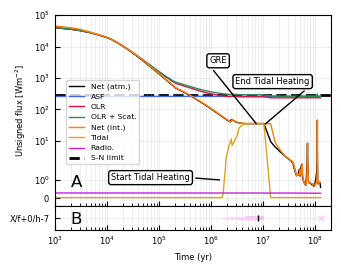

In [23]:
import matplotlib.pyplot as plt

plt.style.use('MJs-theme.mplstyle')


fO2 = 0
H_ref = 0  # Reference H_tide
N = 30

#H_vals_bottom = [H for H in H_vals_sorted if H != H_ref]

# --- Extract curves ---
base = {}

for H in H_vals_sorted:
    for fO2_i, H_oceans, CH_ratio, SH_ratio, time, HC_a, phi, E in data_dict[H]:
        if fO2_i == fO2 and H_oceans == 3 and CH_ratio == 1 and SH_ratio == 2 and H == 1e-7:
                                    
            base[H] = (time, HC_a)

            key = (fO2_i, H, H_oceans, CH_ratio, SH_ratio) 
        
            label = get_case_label(*key)

            start_time, stable_time, stop_time, vmr_time, s, sol_time = metrics[key] 
            break


# --- Create plot with subplots: upper = HC_a, lower = bars ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(3.39, 3), sharex=True, 
                               gridspec_kw={"height_ratios": [4, 0.5], "hspace": 0})

# --- Upper plot: H2O fractions ---
#fig.suptitle(f"Rheological front depth fraction (log$_{{10}}$($f$O$_2 / \Delta \mathrm{{IW}}) = {fO2}$)")

for i, H in enumerate(H_vals_sorted):
    for fO2_i, H_oceans, CH_ratio, SH_ratio, time, HC_a, phi, E in data_dict[H]:
        if fO2_i != fO2 or H_oceans != 3 or SH_ratio != 2 or H != 1e-7:
            continue

        color = H_tide_color_map[H]
        
        F_net, F_asf, F_olr, F_upw, F_int, F_tidal, F_radio = HC_a 

        ax1.plot(time, F_net,   color="black",    label="F_net" if i == 0 else "")
        ax1.plot(time, F_asf,   color="#4169e1",  label="ASF"    if i == 0 else "")
        ax1.plot(time, F_olr,   color="#dc143c",  label="OLR"    if i == 0 else "")
        ax1.plot(time, F_upw,   color="#2e8b57",  label="Upw. sct." if i == 0 else "")
        ax1.plot(time, F_int,   color="#ff7f0e",  label="Interior"  if i == 0 else "")
        ax1.plot(time, F_tidal, color="#daa520",  label="Tidal"     if i == 0 else "")
        ax1.plot(time, F_radio, color="#C720DD",  label="Radiogenic" if i == 0 else "")
        
        ax1.axhline(y=280.0, color='black', lw=2, linestyle='dashed', label="S-N limit", zorder=1)
      
ax1.set_xscale("log")
ax1.set_yscale("symlog")
ax1.set_xlim(1e3, 2e8)
ax1.set_ylim(-0.5, 1e5)
ax1.set_ylabel("Unsigned flux [$\mathrm{Wm}^{-2}$]")

# --- Lower plot: horizontal bars between vertical markers ---
#bar_y = np.arange(len(H_vals_bottom))
#bar_y = np.arange(len(H_vals_sorted))
bar_y = np.arange(1)
bar_height = 0.8
ax2.set_yticks(bar_y)
#ax2.set_yticklabels([f"{H:.0e}" for H in H_vals_bottom])

ytick_labels = []

for H in H_vals_sorted: #H_vals_bottom:
    if H != 1e-7:
        continue
    
    found_case = False
    if H not in data_dict:
        ytick_labels.append(f"H={H:.0e}")
        continue

    for fO2_i, H_oceans, CH_ratio, SH_ratio, *_ in data_dict[H]:
        if fO2_i == fO2 and H_oceans == 3:  # Match main fO2
            label = get_case_label(fO2, H, H_oceans, CH_ratio, SH_ratio)            
            ytick_labels.append(label)
            found_case = True
            break
    
    if not found_case:
        ytick_labels.append(f"H={H:.0e}")  # fallback

ax2.set_yticklabels(ytick_labels)

ax2.set_xlabel("Time (yr)")

for i, H in enumerate(H_vals_sorted): #enumerate(H_vals_bottom):
    
    for fO2_i, H_oceans, CH_ratio, SH_ratio, time, HC_a, phi, E in data_dict[H]:
        if fO2_i == fO2 and H_oceans == 3 and SH_ratio == 2 and H == 1e-7:
                                    
            base[H] = (time, HC_a)

            key = (fO2_i, H, H_oceans, CH_ratio, SH_ratio) 

            print(key)
            
            start_time, stable_time, stop_time, vmr_time, s, sol_time = metrics[key]
        
            y = 0
            color_H = H_tide_color_map[H]

            if H != 0:
                if start_time < stable_time:
                    ax2.scatter(s[0], y*np.ones(len(s[0])), color=color_H, s=s[1], marker='|', zorder=10)

                if stable_time < stop_time:
                    ax2.hlines(y, stable_time, stop_time, color=color_H, linestyle='-', linewidth=3, zorder=1)

                ax2.scatter(vmr_time, y, color='black', marker='|', zorder=10)

            ax2.scatter(sol_time, y, color=color_H, marker='x', zorder=10)
            
            annotations = True
            
            if annotations and H == 1e-7:
                colors = [color_map.get(vol, "#cccccc") for vol in vol_list]

                # Choose a specific key to annotate
                y = 1       

                color = "black"
                color_bkg = "white"

                ax1.annotate('Start Tidal Heating',
                    xy=(start_time, y), xycoords='data',
                    xytext=(-80, 0), textcoords='offset points',
                    bbox=dict(boxstyle="round", fc=color_bkg, ec=color, lw=1),
                    arrowprops=dict(arrowstyle="-", relpos=(1, 0.5), color=color))

                ax1.annotate('GRE',
                    xy=(vmr_time, 30), xycoords='data',
                    xytext=(-35, 45), textcoords='offset points',
                    bbox=dict(boxstyle="round", fc=color_bkg, ec=color, lw=1),
                    arrowprops=dict(arrowstyle="-", relpos=(0, 0), color=color))

                ax1.annotate('End Tidal Heating',
                    xy=(10e6, 30), xycoords='data',
                    xytext=(-20, 30), textcoords='offset points',
                    bbox=dict(boxstyle="round", fc=color_bkg, ec=color, lw=1),
                    arrowprops=dict(arrowstyle="-", relpos=(1, 0), color=color))

ax2.set_xscale("log")
ax2.set_xlim(1e3, 2e8)
#ax2.set_ylim(-1, len(H_vals_bottom))
ax2.set_ylim(1, -1)

ax2.yaxis.set_minor_locator(plt.NullLocator())

ax1.grid(which='both', axis='both', alpha=0.2)
ax2.grid(which='both', axis='both', alpha=0.2)

ax1.text(2e3, 0.6, "A", fontsize=12)
ax2.text(2e3, 0.5, "B", fontsize=12)

from matplotlib.lines import Line2D

# Define custom legend handles for fluxes
flux_legend = [
    Line2D([0], [0], color="black",    label="Net (atm.)"),
    Line2D([0], [0], color="#4169e1",  label="ASF"),
    Line2D([0], [0], color="#dc143c",  label="OLR"),
    Line2D([0], [0], color="#2e8b57",  label="OLR + Scat."),
    Line2D([0], [0], color="#ff7f0e",  label="Net (int.)"),
    Line2D([0], [0], color="#daa520",  label="Tidal"),
    Line2D([0], [0], color="#C720DD",  label="Radio."),
    Line2D([0], [0], color="black", linestyle="--", lw=2, label="S-N limit"),
]

# Create figure-level legend
fig.legend(handles=flux_legend,
           loc="upper center",  # Adjust location as needed
           bbox_to_anchor=(0.3, 0.75),  # Above the top subplot
           ncol=1,
           fontsize=5.5,
           frameon=True,
           fancybox=True)

plt.tight_layout(rect=[0, 0.1, 1, 1])

#plt.savefig('fluxes_example.pgf')

plt.show()


# Figure 6

In [93]:
def get_data(root_path, N, data_dict, vmr_dict):

    for i in range(N):
        case_path = os.path.join(root_path, f"case_{i:05d}")
        config_path = os.path.join(case_path, "init_coupler.toml")
        csv_path = os.path.join(case_path, "runtime_helpfile.csv")

        if not (os.path.exists(config_path) and os.path.exists(csv_path)):
            print("Skipping ", i)
            continue

        config = toml.load(config_path)
                
        try:
            H_tide = config["orbit"]["dummy"]["H_tide"]
            Phi_tide = config["orbit"]["dummy"]["Phi_tide"]
            shutdown = config["orbit"]["dummy"]["shutdown"]
        except KeyError:
            H_tide = 0
            Phi_tide = "<0.3"
            shutdown = None
            
        Pt_lt = bool(Phi_tide[0] == "<")
        Pt_va = float(Phi_tide[1:])
            
        fO2 = config["outgas"]["fO2_shift_IW"]
        H_oceans = config["delivery"]["elements"]["H_oceans"]
        CH_ratio = config["delivery"]["elements"]["CH_ratio"]
        SH_ratio = config["delivery"]["elements"]["SH_ratio"]
            #continue
            
#         if fO2 != 0:
#             continue           
        if H_oceans != 3:
            continue        
        if CH_ratio != 1:
            continue         
        if SH_ratio != 2:
            continue            
#         if H_tide != 1e-7:
#             continue     
        if Pt_va != 0.3:
            continue
                        
        df = pd.read_csv(csv_path, sep="\t")
        df = df[df["Time"] > 0]
        if df.empty:
            continue

        time = df["Time"]
        HC_a = df["H/C_atm"]
        H2O_a = df["H2O_mol_atm"]
        CO2_a = df["CO2_mol_atm"]
        CH4_a = df["CH4_mol_atm"]
        H2_a  = df[ "H2_mol_atm"]
        H2O_t = df["H2O_mol_total"]
        H2O_bar = df["H2O_bar"]
        rheo = df["RF_depth"]
        phi = df["Phi_global"]
        T_surf = df["T_surf"]
        #P_surf = np.array(df["F_atm"])
        
        F_asf = df["F_ins"] * 0.375 * np.cos(48.19 * np.pi/180.0)
        F_tidal = df["F_tidal"]
        F_net = df["F_atm"]
        
        F_olr = df["F_olr"]
        F_upw = df["F_olr"] + df["F_sct"]
        F_int = df["F_int"]
        F_radio = df["F_radio"]
        
        if H_tide == 0:
            E = None
        else:
            E = df["tot_tid_E"]
            
        data_dict.setdefault(H_tide, []).append((fO2, H_oceans, CH_ratio, SH_ratio, time, 1-rheo, phi, E)) 
  
        key = (fO2, H_tide, H_oceans, CH_ratio, SH_ratio)

        for _, row in df.iterrows():
            t = row["Time"]
            vmr_list = [row[vol + "_vmr"] for vol in vol_list]

            if key not in vmr_dict:
                vmr_dict[key] = {}
            vmr_dict[key][t] = vmr_list

In [94]:
# Define root path
root_path           = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_test_6"
root_path_final_H   = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_2V2"
root_path_final_C   = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_3"
root_path_final_S   = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_4"
root_path_final_H_2 = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_5_H"
root_path_final_C_2 = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_5_C"
root_path_final     = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_6"
root_path_final_2   = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_7V2"
root_path_final_C_2 = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_8V2"
#root_path_shutdown  = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_shutdown"

root_path_phi_tide = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_phi_tide"

# Prepare data storage
data_dict = {}
vmr_dict = {}

# Get data
get_data(root_path, 9, data_dict, vmr_dict)

get_data(root_path_final_H, 36, data_dict, vmr_dict)
get_data(root_path_final_C, 36, data_dict, vmr_dict)
get_data(root_path_final_S, 36, data_dict, vmr_dict)
get_data(root_path_final_H_2, 24, data_dict, vmr_dict)
get_data(root_path_final_C_2, 24, data_dict, vmr_dict)
get_data(root_path_final, 15, data_dict, vmr_dict)
# get_data(root_path_final_2, 6, data_dict, vmr_dict)
# get_data(root_path_final_C_2, 6, data_dict, vmr_dict)
#get_data(root_path_shutdown, 16, data_dict, vmr_dict)

get_data(root_path_phi_tide, 40, data_dict, vmr_dict)

# --- Create Color Map Using Scientific Colormap ---
H_vals_sorted = sorted(data_dict)

# Replace H=0 with a small dummy value for log scale (for color map only)
H_for_log = [1e-11 if H == 0 else H for H in H_vals_sorted]
norm = plt.Normalize(vmin=np.log10(min(H_for_log)), vmax=np.log10(max(H_for_log)))

# colormap from Scientific Colour Maps
colormap = cmc.batlowK

# Apply the norm using the adjusted list
H_tide_color_map = {
    H: colormap(norm(np.log10(1e-11 if H == 0 else H)))
    for H in H_vals_sorted
}

# H_tide color mapping
H_oceans_ls   = {2   : 'dotted',                 3: 'solid', 5: 'dashed'}
CH_ratio_ls   = {0.01: 'dotted', 0.1: 'dotted', 0.5: 'dashdot', 1: 'solid', 1: 'dashed'}
SH_ratio_ls   = {0.1 : 'dotted', 1  : 'dashdot', 2: 'solid', 3: 'dashed'}


# Get timestamps
metrics = extract_curve_metrics(data_dict, H_vals_sorted)

Skipping  1
Skipping  3
Skipping  1
Skipping  2
Skipping  3
Skipping  8
Skipping  9
Skipping  10
Skipping  11
Skipping  12
Skipping  13
Skipping  14
Skipping  15
Skipping  16
Skipping  17
Skipping  18
Skipping  19
Skipping  20
Skipping  21
Skipping  22
Skipping  23
Skipping  0


/tmp/ipykernel_3757507/75479046.py:50: RuntimeWarning: divide by zero encountered in divide
  dEdt = np.gradient(E) / np.gradient(time)
/tmp/ipykernel_3757507/75479046.py:82: RuntimeWarning: divide by zero encountered in divide
  dEdt_slice = np.gradient(E.iloc[index0:final_index]) / np.gradient(t_original)
/tmp/ipykernel_3757507/75479046.py:86: RuntimeWarning: invalid value encountered in divide
  spacing_abs = spacing_rel / np.max(spacing_rel) * 5 + 1


/tmp/ipykernel_3757507/472956445.py:231: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=0.0, w_pad=0.0)


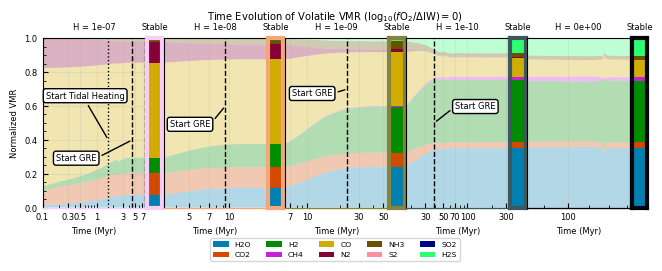

In [95]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
from scipy.interpolate import interp1d
from matplotlib.ticker import NullFormatter, ScalarFormatter

plt.style.use('MJs-theme.mplstyle')

# Set fO2 to fixed value
fO2 = 0

# Get all unique H values, sorted descending
H_vals = sorted({key[1] for key in vmr_dict if key[0] == fO2}, reverse=True)

# Define bar width ratio (bar width / time plot width)
bar_width_ratio = 0.15
total_panels = len(H_vals) * 2
ratios = [1 if i % 2 == 0 else bar_width_ratio for i in range(total_panels)]

# Prepare figure and GridSpec
fig = plt.figure(figsize=(7.4, 2.2))
gs = gridspec.GridSpec(1, total_panels, figure=fig, wspace=0.025, width_ratios=ratios)

# Track previous CO bar VMR
prev_CO_vmr = None

custom_ticks = [1e5, 3e5, 5e5, 1e6, 3e6, 5e6, 7e6, 1e7, 3e7, 5e7, 7e7, 1e8, 3e8, 5e8, 7e8]


for i, H in enumerate(H_vals):
   
    
    key = (fO2, H, 3, 1, 2)
    bar_data = vmr_dict.get(key, {})
    if not bar_data:
        continue

    start_time, stable_time, stop_time, vmr_time, s, sol_time = metrics[key]
        
    if vmr_time in bar_data:
        vmr_mid = np.array(bar_data[vmr_time])
    else:
        nearest_time = min(bar_data.keys(), key=lambda t: abs(t - vmr_time))
        vmr_mid = np.array(bar_data[nearest_time])
        
    H_color = H_tide_color_map[H]
        
    for fO2_i, H_oceans, CH_ratio, SH_ratio, time, HC_a, phi, E in data_dict[H]:
        if fO2_i == fO2 and H_oceans == 3 and CH_ratio == 1 and SH_ratio == 2:
        
            times = np.array(time)
            
            break
    
    # Build matrix of normalized VMRs
    vmr_matrix = []
    for time in times:
        vmr = np.array(bar_data[time])
        total = np.sum(vmr)
        vmr = vmr / total if total > 0 else np.zeros_like(vmr)
        vmr_matrix.append(vmr)
    vmr_matrix = np.array(vmr_matrix).T  # shape (num_vols, num_times)

    # Get colors for each volatile
    colors = [color_map.get(vol, "#cccccc") for vol in vol_list]

    # Create main stackplot subplot
    ax = fig.add_subplot(gs[0, i * 2])
    ax.stackplot(times, vmr_matrix, labels=vol_list, colors=colors, alpha=0.3)    
    ax.set_xscale("log")        
    ax.set_xticks(custom_ticks)
    ax.set_xticklabels(["0.1", "0.3", "0.5", 
                        "1", "3", "5", "7", 
                        "10", "30", "50", "70",
                        "100", "300", "500", "700"])
    
    ax.xaxis.set_minor_formatter(NullFormatter())     # Disable minor tick labels
    
    ax.spines['bottom'].set_color(H_color)
    ax.spines['bottom'].set_linewidth(1)
    for ticks in ax.xaxis.get_ticklines():
        ticks.set_color(H_color)
        
    ax.set_ylim(0, 1)
    
    ax.set_title(f"H = {H:.0e}")
    ax.set_xlabel("Time (Myr)")
    if i == 0:
        ax.set_ylabel("Normalized VMR")
    else:
        ax.set_yticks([])
        ax.set_ylabel("")
    
    # Vertical lines
    if start_time < stable_time < stop_time:
        ax.axvline(start_time, color='k', linestyle='dotted', linewidth=1)
        ax.axvline(stable_time, color='k', linestyle='dashed', linewidth=1)
        ax.axvline(vmr_time, color='k', linestyle='dashed', linewidth=1)

    # ---- Add vertical bar at stable (mid) time ----
    if vmr_time in bar_data:
        vmr_mid = np.array(bar_data[vmr_time])
    else:
        nearest_time = min(times, key=lambda t: abs(t - vmr_time))
        vmr_mid = np.array(bar_data[nearest_time])

    total_mid = np.sum(vmr_mid)
    vmr_mid = vmr_mid / total_mid if total_mid > 0 else np.zeros_like(vmr_mid)

    # Create vertical stacked bar plot
    ax_bar = fig.add_subplot(gs[0, i * 2 + 1])
    y_bottom = 0
    for vmr_val, (i, color) in zip(vmr_mid, enumerate(colors)):
        if vmr_val > 0:
            ax_bar.fill_between(
                [0, 1],
                y_bottom,
                y_bottom + vmr_val,
                label=vol_list[i],
                facecolor=color,
                edgecolor=None,
                linewidth=1.0,
                alpha=1.0,
            )
            y_bottom += vmr_val

    ax_bar.spines['bottom'].set_color(H_color)
    ax_bar.spines['top'].set_color(H_color)
    ax_bar.spines['left'].set_color(H_color)
    ax_bar.spines['right'].set_color(H_color)
    
    ax_bar.spines['bottom'].set_linewidth(3)
    ax_bar.spines['top'].set_linewidth(3)
    ax_bar.spines['left'].set_linewidth(3)
    ax_bar.spines['right'].set_linewidth(3)
    
    ax_bar.set_xlim(0, 1)
    ax_bar.set_ylim(0, 1)
    ax_bar.set_xticks([])
    ax_bar.set_yticks([])
    ax_bar.set_title("Stable")

    # ---- Determine start time based on CO match to previous bar ----
    co_index = vol_list.index("CO")
    co_vmr_bar = vmr_mid[co_index]

    if prev_CO_vmr is not None:
        co_series = vmr_matrix[co_index]
        if len(times) >= 2 and np.any(np.diff(co_series) != 0):
            interp_func = interp1d(co_series, times, bounds_error=False, fill_value="extrapolate")
            t_interp = float(interp_func(prev_CO_vmr))
            # Clamp to min/max of times to avoid extrapolation outside range
            t_interp = max(min(t_interp, times[-1]), times[0])
        else:
            # Fallback to closest match if interpolation fails
            abs_diff = np.abs(co_series - prev_CO_vmr)
            best_match_idx = np.argmin(abs_diff)
            t_interp = times[best_match_idx]

        ax.set_xlim(t_interp, vmr_time)
        #ax.set_xlim(start, vmr_time)
    else:
        ax.set_xlim(1e5, vmr_time)

    # ---- Store CO VMR for next iteration ----
    prev_CO_vmr = co_vmr_bar

    annotations = True
    
    if annotations and H == 1e-7:
        colors = [color_map.get(vol, "#cccccc") for vol in vol_list]

        # Choose a specific key to annotate
        y = 0.4       

        color = "black"
        color_bkg = "white"

        ax.annotate('Start Tidal Heating',
            xy=(start_time, y), xycoords='data',
            xytext=(-45, 30), textcoords='offset points',
            bbox=dict(boxstyle="round", fc=color_bkg, ec=color, lw=1),
            arrowprops=dict(arrowstyle="-", relpos=(0.5, 0), color=color))

        ax.annotate('Start GRE',
            xy=(stable_time, 0.4), xycoords='data',
            xytext=(-55, -15), textcoords='offset points',
            bbox=dict(boxstyle="round", fc=color_bkg, ec=color, lw=1),
            arrowprops=dict(arrowstyle="-", relpos=(1, 0.5), color=color))
    
    if annotations and H == 1e-8:
        colors = [color_map.get(vol, "#cccccc") for vol in vol_list]
        color = "black"
        color_bkg = "white"

        ax.annotate('Start GRE',
            xy=(stable_time, 0.6), xycoords='data',
            xytext=(-40, -15), textcoords='offset points',
            bbox=dict(boxstyle="round", fc=color_bkg, ec=color, lw=1),
            arrowprops=dict(arrowstyle="-", relpos=(1, 0.5), color=color))
        
    if annotations and H == 1e-9:
        colors = [color_map.get(vol, "#cccccc") for vol in vol_list]
        color = "black"
        color_bkg = "white"

        ax.annotate('Start GRE',
            xy=(stable_time, 0.7), xycoords='data',
            xytext=(-40, -5), textcoords='offset points',
            bbox=dict(boxstyle="round", fc=color_bkg, ec=color, lw=1),
            arrowprops=dict(arrowstyle="-", relpos=(1, 0.5), color=color))
        
    if annotations and H == 1e-10:
        colors = [color_map.get(vol, "#cccccc") for vol in vol_list]
        color = "black"
        color_bkg = "white"

        ax.annotate('Start GRE',
            xy=(stable_time, 0.5), xycoords='data',
            xytext=(15, 10), textcoords='offset points',
            bbox=dict(boxstyle="round", fc=color_bkg, ec=color, lw=1),
            arrowprops=dict(arrowstyle="-", relpos=(0, 0.5), color=color))
    
# Global title and legend
fig.suptitle(f"Time Evolution of Volatile VMR (log$_{{10}}$($f$O$_2 / \Delta \mathrm{{IW}}) = {fO2}$)", y=1.01)

handles, labels = ax_bar.get_legend_handles_labels()
unique = dict(zip(labels, handles))
fig.legend(unique.values(), unique.keys(), bbox_to_anchor=(0.5, -0.15), loc='lower center', ncol=min(len(vol_list), 5), fontsize=5.5)

fig.tight_layout(pad=0.0, w_pad=0.0)

plt.savefig('VMR_fo2+0_final.pgf')

plt.show()


# Figure 7

In [97]:
def get_data(root_path, N, data_dict, vmr_dict):

    for i in range(N):
        case_path = os.path.join(root_path, f"case_{i:05d}")
        config_path = os.path.join(case_path, "init_coupler.toml")
        csv_path = os.path.join(case_path, "runtime_helpfile.csv")

        if not (os.path.exists(config_path) and os.path.exists(csv_path)):
            print("Skipping ", i)
            continue

        config = toml.load(config_path)
                
        try:
            module = config["orbit"]["module"]
            H_tide = config["orbit"]["dummy"]["H_tide"]
            Phi_tide = config["orbit"]["dummy"]["Phi_tide"]
            shutdown = config["orbit"]["dummy"]["shutdown"]
        except KeyError:
            module = "none"
            H_tide = 0
            Phi_tide = "<0.3"
            shutdown = None
            
        if module == "none":
            H_tide = 0
            
        Pt_lt = bool(Phi_tide[0] == "<")
        Pt_va = float(Phi_tide[1:])
            
        fO2 = config["outgas"]["fO2_shift_IW"]
        H_oceans = config["delivery"]["elements"]["H_oceans"]
        CH_ratio = config["delivery"]["elements"]["CH_ratio"]
        SH_ratio = config["delivery"]["elements"]["SH_ratio"]
            #continue
            
#         if fO2 != 0:
#             continue           
        if H_oceans != 3:
            continue        
        if CH_ratio != 1:
            continue         
        if SH_ratio != 2:
            continue            
#         if H_tide != 1e-7:
#             continue     
        if Pt_va != 0.3:
            continue
                        
        df = pd.read_csv(csv_path, sep="\t")
        df = df[df["Time"] > 0]
        if df.empty:
            continue

        time = df["Time"]
        HC_a = df["H/C_atm"]
        H2O_a = df["H2O_mol_atm"]
        CO2_a = df["CO2_mol_atm"]
        CH4_a = df["CH4_mol_atm"]
        H2_a  = df[ "H2_mol_atm"]
        H2O_t = df["H2O_mol_total"]
        H2O_bar = df["H2O_bar"]
        rheo = df["RF_depth"]
        phi = df["Phi_global"]
        T_surf = df["T_surf"]
        #P_surf = np.array(df["F_atm"])
        
        F_asf = df["F_ins"] * 0.375 * np.cos(48.19 * np.pi/180.0)
        F_tidal = df["F_tidal"]
        F_net = df["F_atm"]
        
        F_olr = df["F_olr"]
        F_upw = df["F_olr"] + df["F_sct"]
        F_int = df["F_int"]
        F_radio = df["F_radio"]
        
        if H_tide == 0:
            E = None
        else:
            E = df["tot_tid_E"]
            
        data_dict.setdefault(H_tide, []).append((fO2, H_oceans, CH_ratio, SH_ratio, time, 1-rheo, phi, E)) 
        
        key = (fO2, H_tide, H_oceans, CH_ratio, SH_ratio)

        for _, row in df.iterrows():
            t = row["Time"]
            vmr_list = [row[vol + "_vmr"] for vol in vol_list]

            if key not in vmr_dict:
                vmr_dict[key] = {}
            vmr_dict[key][t] = vmr_list

In [98]:
# Define root path
root_path           = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_test_6"
root_path_final_H   = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_2V2"
root_path_final_C   = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_3"
root_path_final_S   = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_4"
root_path_final_H_2 = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_5_H"
root_path_final_C_2 = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_5_C"
root_path_final     = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_6"
root_path_final_2   = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_7V2"
root_path_final_C_2_2 = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_8V2"

# Prepare data storage
data_dict = {}
vmr_dict = {}

# Get data
get_data(root_path, 9, data_dict, vmr_dict)

get_data(root_path_final_H, 36, data_dict, vmr_dict)
get_data(root_path_final_C, 36, data_dict, vmr_dict)
get_data(root_path_final_S, 36, data_dict, vmr_dict)
get_data(root_path_final_H_2, 24, data_dict, vmr_dict)
get_data(root_path_final_C_2, 24, data_dict, vmr_dict)
get_data(root_path_final, 15, data_dict, vmr_dict)
get_data(root_path_final_2, 6, data_dict, vmr_dict)
get_data(root_path_final_C_2_2, 6, data_dict, vmr_dict)

# --- Create Color Map Using Scientific Colormap ---
H_vals_sorted = sorted(data_dict)

# Replace H=0 with a small dummy value for log scale (for color map only)
H_for_log = [1e-11 if H == 0 else H for H in H_vals_sorted]
norm = plt.Normalize(vmin=np.log10(min(H_for_log)), vmax=np.log10(max(H_for_log)))

# colormap from Scientific Colour Maps
colormap = cmc.batlowK

# Apply the norm using the adjusted list
H_tide_color_map = {
    H: colormap(norm(np.log10(1e-11 if H == 0 else H)))
    for H in H_vals_sorted
}

# Get timestamps
metrics = extract_curve_metrics(data_dict, H_vals_sorted)

Skipping  1
Skipping  3
Skipping  1
Skipping  2
Skipping  3
Skipping  0


/tmp/ipykernel_3757507/75479046.py:50: RuntimeWarning: divide by zero encountered in divide
  dEdt = np.gradient(E) / np.gradient(time)
/tmp/ipykernel_3757507/75479046.py:82: RuntimeWarning: divide by zero encountered in divide
  dEdt_slice = np.gradient(E.iloc[index0:final_index]) / np.gradient(t_original)
/tmp/ipykernel_3757507/75479046.py:86: RuntimeWarning: invalid value encountered in divide
  spacing_abs = spacing_rel / np.max(spacing_rel) * 5 + 1


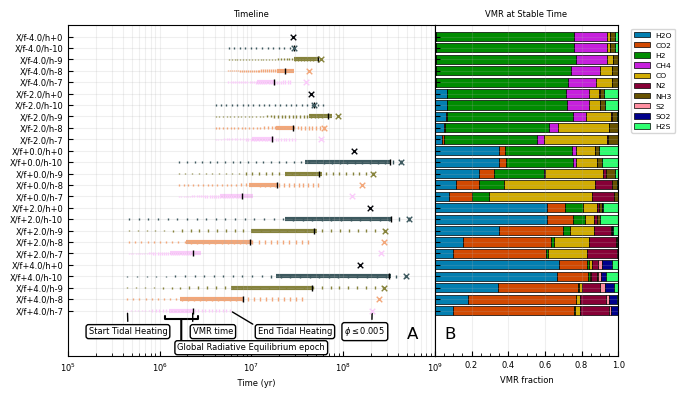

In [100]:
plt.style.use('MJs-theme.mplstyle')

# Determine y-index map first
idx_map = {}

for i, H in enumerate(H_vals_sorted):
    for fO2_i, H_oceans, CH_ratio, SH_ratio, *_ in data_dict[H]:
        key = (fO2_i, H, H_oceans, CH_ratio, SH_ratio)
        fo2_idx = (fO2_i + 4) / 8 * 80
        H_oceans_idx = (H_oceans - 2) / 3 * 15
        
        if H_oceans != 3:
            continue
            
        fo2_idx = (fO2_i + 4) / 8 * 20
        H_oceans_idx = 0
        
        
#         if CH_ratio == 0.1:
#             H_oceans_idx = 0
#         elif CH_ratio == 0.5:
#             H_oceans_idx = 5
#         elif CH_ratio == 1:
#             H_oceans_idx = 10
#         elif CH_ratio == 2:
#             H_oceans_idx = 15    
            
#         if SH_ratio == 0.1:
#             H_oceans_idx = 0
#         elif SH_ratio == 1:
#             H_oceans_idx = 5
#         elif SH_ratio == 2:
#             H_oceans_idx = 10
#         elif SH_ratio == 3:
#             H_oceans_idx = 15  
        
        H_idx = (int(np.log10(H))+11) if H != 0 else 0
        idx = int(fo2_idx + H_oceans_idx + H_idx)
        idx_map[key] = idx

# Sort keys by idx
sorted_keys = sorted(idx_map.items(), key=lambda item: item[1])

def plot_figure(selected_items, N, annotations=False):
    gs = GridSpec(1, 2, width_ratios=[2, 1], wspace=0)

    ax_timeline = fig.add_subplot(gs[0, 0])
    ax_vmr = fig.add_subplot(gs[0, 1])

    bar_y = np.arange(N)
    ytick_labels = ["" for _ in range(N)]

    first_it = True

    for plot_idx, (key, local_idx) in enumerate(selected_items):
        fO2_i, H, H_oceans, CH_ratio, SH_ratio = key
        label = get_case_label(*key)
        ytick_labels[local_idx] = label
        y = bar_y[local_idx]

        color_H = H_tide_color_map[H]
        start_time, stable_time, stop_time, vmr_time, s, sol_time = metrics[key]
                
        if H != 0:
            if start_time < stable_time:
                ax_timeline.scatter(s[0], y*np.ones(len(s[0])), color=color_H, s=s[1], marker='|', zorder=10)

            if stable_time < stop_time:
                ax_timeline.hlines(y, stable_time, stop_time, color=color_H, linestyle='-', linewidth=3, zorder=1)
            
            ax_timeline.scatter(vmr_time, y, color='black', marker='|', zorder=10)
                        
        ax_timeline.scatter(sol_time, y, color=color_H, marker='x', zorder=10)

        bar_data = vmr_dict.get(key, {})
        if not bar_data:
            continue

        if vmr_time in bar_data:
            vmr_mid = np.array(bar_data[vmr_time])
        else:
            nearest_time = min(bar_data.keys(), key=lambda t: abs(t - vmr_time))
            vmr_mid = np.array(bar_data[nearest_time])

        total_mid = np.sum(vmr_mid)
        vmr_mid = vmr_mid / total_mid if total_mid > 0 else np.zeros_like(vmr_mid)

        colors = [color_map.get(vol, "#cccccc") for vol in vol_list]

        x_left = 0
        for vmr_val, (j, color) in zip(vmr_mid, enumerate(colors)):
            if vmr_val > 0:
                ax_vmr.barh(
                    y,
                    vmr_val,
                    left=x_left,
                    height=0.8,
                    color=color,
                    edgecolor='black',
                    linewidth=0.5,
                    label=vol_list[j] if first_it else None
                )
                x_left += vmr_val

        first_it = False

    # Axis setup
    ax_timeline.set_xscale("log")
    ax_timeline.set_xlim(1e5, 1e9)
    ax_timeline.set_ylim(N, -1)
    ax_timeline.set_yticks(bar_y)
    ax_timeline.set_yticklabels(ytick_labels)
    ax_timeline.set_xlabel("    Time (yr)")
    ax_timeline.set_title("Timeline")
    ax_timeline.grid(which='both', axis='both', alpha=0.2)

    ax_timeline.yaxis.set_minor_locator(plt.NullLocator())

    # Limit y-ticks to y ≤ 25
    visible_idx = [i for i in bar_y if i <= 24]
    visible_labels = [ytick_labels[i] for i in visible_idx]

    ax_timeline.set_yticks(visible_idx)
    ax_timeline.set_yticklabels(visible_labels)
    
    ax_vmr.set_ylim(N, -1)
    ax_vmr.set_yticks(bar_y)
    ax_vmr.set_yticklabels([])  # y-labels already on left
    ax_vmr.set_xlabel("VMR fraction")
    ax_vmr.set_xlim(0, 1.0)
    
    ax_vmr.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax_vmr.set_xticklabels(["", "0.2", "0.4", "0.6", "0.8", "1.0"])
    ax_vmr.set_title("VMR at Stable Time")
    ax_vmr.grid(axis='x', alpha=0.2)

    ax_vmr.yaxis.set_minor_locator(plt.NullLocator())
        
    ax_vmr.set_yticks(visible_idx)
    
    
    handles, labels = ax_vmr.get_legend_handles_labels()
    if handles:
        ax_vmr.legend(handles, labels, bbox_to_anchor=(1.05, 1.0), loc='upper left')
        
    if annotations:
        colors = [color_map.get(vol, "#cccccc") for vol in vol_list]
                
        # Choose a specific key to annotate
        key_to_annotate = sorted_keys[-1][0]  # for example, the 11th item
        start_time, stable_time, stop_time, vmr_time, s, sol_time = metrics[key_to_annotate]
        local_idx = idx_map[key_to_annotate]
        y = bar_y[local_idx]       

        color = "black"
        #color = H_tide_color_map[1e-7]
        color_bkg = "white"
        
        ax_timeline.annotate('Start Tidal Heating',
            xy=(start_time, y), xycoords='data',
            xytext=(-28, -17), textcoords='offset points',
            bbox=dict(boxstyle="round", fc=color_bkg, ec=color, lw=1),
            arrowprops=dict(arrowstyle="-", relpos=(0.5, 1), color=color))

        from matplotlib.patches import FancyArrowPatch

        # Define coordinates
        start = (0.75 * vmr_time, y + 0.5)  # data point to annotate
        end = ax_timeline.transData.transform(start) + np.array([70, -27])  # offset in screen coords
        end = ax_timeline.transData.inverted().transform(end)  # convert back to data coords
        end_2 = ax_timeline.transData.transform(start) + np.array([0, -27])  # offset in screen coords
        end_2 = ax_timeline.transData.inverted().transform(end_2)  # convert back to data coords

        # Draw the arrow
        arrow = FancyArrowPatch(
            posA=end_2,  # tail
            posB=start,  # head (arrow points to the data point)
            arrowstyle='-[',  # bracket arrow
            mutation_scale=12,  # overall size of arrow
            lw=1.5,
            color=color
        )
        ax_timeline.add_patch(arrow)

        # Draw the text box
        ax_timeline.text(
            end[0], end[1], 'Global Radiative Equilibrium epoch',
            bbox=dict(boxstyle="round", fc=color_bkg, ec=color, lw=1),
            ha='center', va='top'
        )

        
        ax_timeline.annotate('VMR time',
            xy=(vmr_time, y), xycoords='data',
            xytext=(0, -17), textcoords='offset points',
            bbox=dict(boxstyle="round", fc=color_bkg, ec=color, lw=1),
            arrowprops=dict(arrowstyle="-", relpos=(0, 1), color=color))
        
        ax_timeline.annotate('End Tidal Heating',
            xy=(s[0][-1], y), xycoords='data',
            xytext=(20, -17), textcoords='offset points',
            bbox=dict(boxstyle="round", fc=color_bkg, ec=color, lw=1),
            arrowprops=dict(arrowstyle="-", relpos=(0, 1), color=color))
        
        lbl = r'$\phi \leq 0.005$'
        
        ax_timeline.annotate(lbl,
            xy=(sol_time, y), xycoords='data',
            xytext=(-20, -17), textcoords='offset points',
            bbox=dict(boxstyle="round", fc=color_bkg, ec=color, lw=1),
            arrowprops=dict(arrowstyle="-", relpos=(0.67, 1), color=color))

    ax_timeline.text(5e8, 26.5, "A", fontsize=12)
    ax_vmr.text(0.05, 26.5, "B", fontsize=12)
        
    #plt.savefig('timeline+VMR_final.pgf')
        
    #plt.suptitle(fig_title)
    plt.show()


fig = plt.figure(figsize=(7.1, 4.3))
plot_figure(sorted_keys, 28, annotations=True)


# Figure 8

In [32]:
def get_data(root_path, N, data_dict, vmr_dict):

    for i in range(N):
        case_path = os.path.join(root_path, f"case_{i:05d}")
        config_path = os.path.join(case_path, "init_coupler.toml")
        csv_path = os.path.join(case_path, "runtime_helpfile.csv")

        if not (os.path.exists(config_path) and os.path.exists(csv_path)):
            print("Skipping ", i)
            continue

        config = toml.load(config_path)
                
        try:
            H_tide = config["orbit"]["dummy"]["H_tide"]
            Phi_tide = config["orbit"]["dummy"]["Phi_tide"]
            shutdown = config["orbit"]["dummy"]["shutdown"]
        except KeyError:
            H_tide = 0
            Phi_tide = "<0.3"
            shutdown = None
            
        Pt_lt = bool(Phi_tide[0] == "<")
        Pt_va = float(Phi_tide[1:])
            
        fO2 = config["outgas"]["fO2_shift_IW"]
        H_oceans = config["delivery"]["elements"]["H_oceans"]
        CH_ratio = config["delivery"]["elements"]["CH_ratio"]
        SH_ratio = config["delivery"]["elements"]["SH_ratio"]
            #continue
            
#         if fO2 != 0:
#             continue           
        if H_oceans != 3:
            continue        
        if CH_ratio != 1:
            continue         
        if SH_ratio != 2:
            continue            
#         if H_tide != 1e-7:
#             continue     
#         if Pt_va != 0.3:
#             continue
                        
        df = pd.read_csv(csv_path, sep="\t")
        df = df[df["Time"] > 0]
        if df.empty:
            continue

        time = df["Time"]
        HC_a = df["H/C_atm"]
        H2O_a = df["H2O_mol_atm"]
        CO2_a = df["CO2_mol_atm"]
        CH4_a = df["CH4_mol_atm"]
        H2_a  = df[ "H2_mol_atm"]
        H2O_t = df["H2O_mol_total"]
        H2O_bar = df["H2O_bar"]
        rheo = df["RF_depth"]
        phi = df["Phi_global"]
        T_surf = df["T_surf"]
        #P_surf = np.array(df["F_atm"])
        
        F_asf = df["F_ins"] * 0.375 * np.cos(48.19 * np.pi/180.0)
        F_tidal = df["F_tidal"]
        F_net = df["F_atm"]
        
        F_olr = df["F_olr"]
        F_upw = df["F_olr"] + df["F_sct"]
        F_int = df["F_int"]
        F_radio = df["F_radio"]
        
        if H_tide == 0:
            E = None
        else:
            E = df["tot_tid_E"]
            
        data_dict.setdefault(H_tide, []).append((fO2, H_oceans, CH_ratio, Pt_va, time, F_net, phi, E))
        
        key = (fO2, H_tide, H_oceans, CH_ratio, SH_ratio)

        for _, row in df.iterrows():
            t = row["Time"]
            vmr_list = [row[vol + "_vmr"] for vol in vol_list]

            if key not in vmr_dict:
                vmr_dict[key] = {}
            vmr_dict[key][t] = vmr_list

In [37]:
# Define root path
root_path           = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_test_6"
root_path_final_H   = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_2V2"
root_path_final_C   = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_3"
root_path_final_S   = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_4"
root_path_final_H_2 = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_5_H"
root_path_final_C_2 = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_5_C"
root_path_final     = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_6"
root_path_final_2   = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_7V2"
root_path_final_C_2 = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_8V2"
root_path_phi_tide = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_phi_tide"

# Prepare data storage
data_dict = {}
vmr_dict = {}

# Get data
get_data(root_path, 9, data_dict, vmr_dict)

get_data(root_path_final_H, 36, data_dict, vmr_dict)
get_data(root_path_final_H_2, 24, data_dict, vmr_dict)
get_data(root_path_phi_tide, 40, data_dict, vmr_dict)

# --- Create Color Map Using Scientific Colormap ---
H_vals_sorted = sorted(data_dict)

# Replace H=0 with a small dummy value for log scale (for color map only)
H_for_log = [1e-11 if H == 0 else H for H in H_vals_sorted]
norm = plt.Normalize(vmin=np.log10(min(H_for_log)), vmax=np.log10(max(H_for_log)))

# colormap from Scientific Colour Maps
colormap = cmc.batlowK

# Apply the norm using the adjusted list
H_tide_color_map = {
    H: colormap(norm(np.log10(1e-11 if H == 0 else H)))
    for H in H_vals_sorted
}

# Get timestamps
metrics = extract_curve_metrics(data_dict, H_vals_sorted)

/tmp/ipykernel_3741220/75479046.py:50: RuntimeWarning: divide by zero encountered in divide
  dEdt = np.gradient(E) / np.gradient(time)
/tmp/ipykernel_3741220/75479046.py:82: RuntimeWarning: divide by zero encountered in divide
  dEdt_slice = np.gradient(E.iloc[index0:final_index]) / np.gradient(t_original)
/tmp/ipykernel_3741220/75479046.py:86: RuntimeWarning: invalid value encountered in divide
  spacing_abs = spacing_rel / np.max(spacing_rel) * 5 + 1


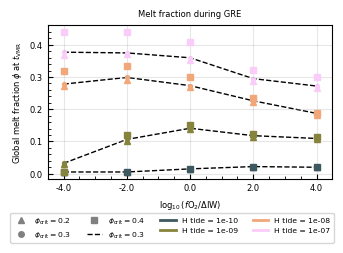

In [38]:
from collections import defaultdict
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

plt.style.use('MJs-theme.mplstyle')

fig, ax = plt.subplots(figsize=(3.39, 2.2))

# --- Step 1: Gather phi(VMR_time) data per H_tide and H_oceans ---
grouped_lines = defaultdict(list)    # for H_oceans == 3 (line plots)
grouped_markers = defaultdict(list)  # for all H_oceans (scatter markers)

grouped_by_phi = {0.2: defaultdict(list), 0.3: defaultdict(list), 0.4: defaultdict(list)}

hatches = ['x', '|', 'x', '||', '|']
H_tide_vals = [H for H in H_vals_sorted if H != 0]

for H in H_vals_sorted:
    if H == 0 or H not in data_dict:
        continue
    for fO2_i, H_oceans, CH_ratio, SH_ratio, time, HC_a, phi, E in data_dict[H]:
        if CH_ratio == 1 and H_oceans == 3:
            key = (fO2_i, H, H_oceans, CH_ratio, SH_ratio)
            if key not in metrics:
                continue
            vmr_time = metrics[key][3]
            if vmr_time is None:
                continue
            phi_interp = interp1d(time, phi, bounds_error=False, fill_value=np.nan)
            phi_vmr = phi_interp(vmr_time)
            grouped_by_phi[SH_ratio][H].append((fO2_i, phi_vmr))


# --- Step 2: Find common fO2 values for line plots (H_oceans == 3 only) ---
common_fO2_vals = set.intersection(
    *(set(f for f, _ in v) for H_vals in grouped_by_phi.values() for v in H_vals.values())
)
common_fO2_vals = sorted(common_fO2_vals)

for i, H in enumerate(H_tide_vals):
    if H not in grouped_by_phi[0.2] or H not in grouped_by_phi[0.3] or H not in grouped_by_phi[0.4]:
        continue
    
    data_2 = {f: phi for f, phi in grouped_by_phi[0.2][H] if f in common_fO2_vals}
    data_3 = {f: phi for f, phi in grouped_by_phi[0.3][H] if f in common_fO2_vals}
    data_4 = {f: phi for f, phi in grouped_by_phi[0.4][H] if f in common_fO2_vals}
           
    fO2_vals = sorted(set(data_2.keys()) & set(data_4.keys()))
    if not fO2_vals:
        continue
    
    phi_2 = np.array([data_2[f] for f in fO2_vals])
    phi_3 = np.array([data_3[f] for f in fO2_vals])
    phi_4 = np.array([data_4[f] for f in fO2_vals])
        
    color = H_tide_color_map[H]
    hatch = hatches[i % len(hatches)]
    
    ax.plot(fO2_vals, phi_2, color=color, marker='^', label=f"H_tide={H:.0e} (Phi=0.2)", linestyle="")
    ax.plot(fO2_vals, phi_3, color="black", linestyle="--", zorder=0.2)
    ax.scatter(fO2_vals, phi_3, color=color, marker='o', s=8, label=f"H tide={H:.0e}", zorder=0.8)
    ax.plot(fO2_vals, phi_4, color=color, marker='s', label=f"H_tide={H:.0e} (Phi=0.4)", linestyle="")
    
#     ax.fill_between(fO2_vals, phi_2, phi_5, facecolor=color, edgecolor=color,
#                     linewidth=0.0, zorder=0, alpha=0.3)

    
# --- Step 4: Plot markers for all H_oceans ---
for H in grouped_markers:
    color = H_tide_color_map[H]
    for fO2_i, phi_vmr, SH_ratio in grouped_markers[H]:
        if fO2_i not in common_fO2_vals:
            continue
        if SH_ratio not in markers:
            continue
        ax.scatter(fO2_i, phi_vmr, marker=markers[SH_ratio], color=color, s=8, zorder=3)

# ax.text(1.8, 0.32, r"$H_\mathrm{{tide}}=10^{-7}$", fontsize=8, color=H_tide_color_map[1e-7], zorder=10)
# ax.text(0.3, 0.19, r"$H_\mathrm{{tide}}=10^{-8}$", fontsize=8, color=H_tide_color_map[1e-8], zorder=10)
# ax.text(-1.5, 0.15, r"$H_\mathrm{{tide}}=10^{-9}$", fontsize=8, color=H_tide_color_map[1e-9], zorder=10)
# ax.text(-0.5, 0.05, r"$H_\mathrm{{tide}}=10^{-10}$", fontsize=8, color=H_tide_color_map[1e-10], zorder=10)
        
# --- Step 5: Formatting ---
ax.set_xlabel(r"$\log_{10}(f\mathrm{O}_2 /\Delta \mathrm{IW})$")
ax.set_ylabel(r"Global melt fraction $\phi$ at $t_\mathrm{VMR}$")
ax.set_title("Melt fraction during GRE")
ax.set_xlim(min(common_fO2_vals)-0.5, max(common_fO2_vals)+0.5)
ax.set_xticks(common_fO2_vals)
ax.set_xticklabels([f"{f:.1f}" for f in common_fO2_vals])
ax.grid(True, alpha=0.3)


# --- Legend ---
legend_elements = [
    Line2D([0], [0], marker='^', color='gray', linestyle='None', label=r"$\phi_\mathrm{{crit}} = 0.2$"),
    Line2D([0], [0], marker='o', color='gray', linestyle='None', label=r"$\phi_\mathrm{{crit}} = 0.3$"),
    Line2D([0], [0], marker='s', color='gray', linestyle='None', label=r"$\phi_\mathrm{{crit}} = 0.4$"),
]

# Add dashed line explanation
legend_elements.append(
    Line2D([0], [0], linestyle='--', color='black', lw=1, label=r"$\phi_\mathrm{{crit}} = 0.3$")
)

# Add one entry per unique H (color)
for H in H_tide_vals:
    color = H_tide_color_map[H]
    legend_elements.append(
        Line2D([0], [0], color=color, lw=2, label=f"H tide = {H:.0e}")
    )

# Place legend outside the plot
fig.legend(handles=legend_elements, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.12), fontsize=5.5)

plt.tight_layout()

#plt.savefig('melt_phi.pgf')

plt.show()


# Figure 10

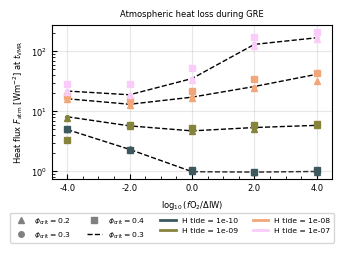

In [39]:
from collections import defaultdict
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

plt.style.use('MJs-theme.mplstyle')

fig, ax = plt.subplots(figsize=(3.39, 2.2))

# --- Step 1: Gather phi(VMR_time) data per H_tide and H_oceans ---
grouped_lines = defaultdict(list)    # for H_oceans == 3 (line plots)
grouped_markers = defaultdict(list)  # for all H_oceans (scatter markers)

grouped_by_phi = {0.2: defaultdict(list), 0.3: defaultdict(list), 0.4: defaultdict(list)}

hatches = ['x', '|', 'x', '||', '|']
H_tide_vals = [H for H in H_vals_sorted if H != 0]


for H in H_vals_sorted:
    if H == 0 or H not in data_dict:
        continue
    for fO2_i, H_oceans, CH_ratio, SH_ratio, time, HC_a, phi, E in data_dict[H]:
        if CH_ratio == 1 and H_oceans == 3:
            key = (fO2_i, H, H_oceans, CH_ratio, SH_ratio)
            if key not in metrics:
                continue
            vmr_time = metrics[key][3]
            if vmr_time is None:
                continue
            HC_a_interp = interp1d(time, HC_a, bounds_error=False, fill_value=np.nan)
            HC_a_vmr = HC_a_interp(vmr_time)
            grouped_by_phi[SH_ratio][H].append((fO2_i, HC_a_vmr))

            
            
# --- Step 2: Find common fO2 values for line plots (H_oceans == 3 only) ---
common_fO2_vals = set.intersection(
    *(set(f for f, _ in v) for H_vals in grouped_by_phi.values() for v in H_vals.values())
)
common_fO2_vals = sorted(common_fO2_vals)

for i, H in enumerate(H_tide_vals):
    if H not in grouped_by_phi[0.2] or H not in grouped_by_phi[0.3] or H not in grouped_by_phi[0.4]:
        continue

    data_2 = {f: HC_a for f, HC_a in grouped_by_phi[0.2][H] if f in common_fO2_vals}
    data_3 = {f: HC_a for f, HC_a in grouped_by_phi[0.3][H] if f in common_fO2_vals}
    data_4 = {f: HC_a for f, HC_a in grouped_by_phi[0.4][H] if f in common_fO2_vals}
    
    fO2_vals = sorted(set(data_2.keys()) & set(data_3.keys()))
    if not fO2_vals:
        continue
    
    HC_a_2 = np.array([data_2[f] for f in fO2_vals])
    HC_a_3 = np.array([data_3[f] for f in fO2_vals])
    HC_a_4 = np.array([data_4[f] for f in fO2_vals])
    
    color = H_tide_color_map[H]
    hatch = hatches[i % len(hatches)]

    ax.plot(fO2_vals, HC_a_2, color=color, marker='^', label=f"H_tide={H:.0e}", linestyle="")
    ax.plot(fO2_vals, HC_a_3, color="black", linestyle="--", zorder=0.2)
    ax.scatter(fO2_vals, HC_a_3, color=color, marker='o', s=8, label=f"H tide={H:.0e}", zorder=0.8)
    ax.plot(fO2_vals, HC_a_4, color=color, marker='s', label=f"H_tide={H:.0e}", linestyle="")
    
#     ax.fill_between(fO2_vals, HC_a_2, HC_a_5, facecolor=color, edgecolor=color,
#                     linewidth=0.0, zorder=0, alpha=0.3)

    
# --- Step 4: Plot markers for all H_oceans ---
for H in grouped_markers:
    color = H_tide_color_map[H]
    for fO2_i, HC_a_vmr, SH_ratio in grouped_markers[H]:
        if fO2_i not in common_fO2_vals:
            continue
        if SH_ratio not in markers:
            continue
        #ax.scatter(fO2_i, HC_a_vmr, marker=markers[H_oceans], color=color, s=8, zorder=3)

# --- Legend ---
legend_elements = [
    Line2D([0], [0], marker='^', color='gray', linestyle='None', label=r"$\phi_\mathrm{{crit}} = 0.2$"),
    Line2D([0], [0], marker='o', color='gray', linestyle='None', label=r"$\phi_\mathrm{{crit}} = 0.3$"),
    Line2D([0], [0], marker='s', color='gray', linestyle='None', label=r"$\phi_\mathrm{{crit}} = 0.4$"),
]

# Add dashed line explanation
legend_elements.append(
    Line2D([0], [0], linestyle='--', color='black', lw=1, label=r"$\phi_\mathrm{{crit}} = 0.3$")
)

# Add one entry per unique H (color)
for H in H_tide_vals:
    color = H_tide_color_map[H]
    legend_elements.append(
        Line2D([0], [0], color=color, lw=2, label=f"H tide = {H:.0e}")
    )


# Place legend outside the plot
fig.legend(handles=legend_elements, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.12), fontsize=5.5)

        
# --- Step 5: Formatting ---
ax.set_yscale("log")

ax.set_xlabel(r"$\log_{10}(f\mathrm{O}_2 /\Delta \mathrm{IW})$")
ax.set_ylabel(r"Heat flux $F_\mathrm{atm}$ [Wm$^{-2}$] at $t_\mathrm{VMR}$")
ax.set_title("Atmospheric heat loss during GRE")
# ax.set_title("Tidal heat flux at surface during GRE")
ax.set_xlim(min(common_fO2_vals)-0.5, max(common_fO2_vals)+0.5)
ax.set_xticks(common_fO2_vals)
ax.set_xticklabels([f"{f:.1f}" for f in common_fO2_vals])
ax.grid(True, alpha=0.3)

#ax.legend(bbox_to_anchor=(0.2, 0.65),loc='lower center', ncol=1)

plt.tight_layout()

#plt.savefig('Fatm.pgf')
#plt.savefig('Fatm_phi.pgf')

plt.show()


# Figure 11

In [101]:
def get_data(root_path, N, data_dict, vmr_dict):

    for i in range(N):
        case_path = os.path.join(root_path, f"case_{i:05d}")
        config_path = os.path.join(case_path, "init_coupler.toml")
        csv_path = os.path.join(case_path, "runtime_helpfile.csv")

        if not (os.path.exists(config_path) and os.path.exists(csv_path)):
            print("Skipping ", i)
            continue

        config = toml.load(config_path)
                
        try:
            module = config["orbit"]["module"]
            H_tide = config["orbit"]["dummy"]["H_tide"]
            Phi_tide = config["orbit"]["dummy"]["Phi_tide"]
            shutdown = config["orbit"]["dummy"]["shutdown"]
        except KeyError:
            module = "none"
            H_tide = 0
            Phi_tide = "<0.3"
            shutdown = None
            
        if module == "none":
            H_tide = 0
            
        Pt_lt = bool(Phi_tide[0] == "<")
        Pt_va = float(Phi_tide[1:])
            
        fO2 = config["outgas"]["fO2_shift_IW"]
        H_oceans = config["delivery"]["elements"]["H_oceans"]
        CH_ratio = config["delivery"]["elements"]["CH_ratio"]
        SH_ratio = config["delivery"]["elements"]["SH_ratio"]
            #continue
            
#         if fO2 != 0:
#             continue           
        if H_oceans != 3:
            continue        
        if CH_ratio != 1:
            continue         
        if SH_ratio != 2:
            continue            
#         if H_tide != 1e-7:
#             continue     
        if Pt_va != 0.3:
            continue
                        
        df = pd.read_csv(csv_path, sep="\t")
        df = df[df["Time"] > 0]
        if df.empty:
            continue

        time = df["Time"]
        HC_a = df["H/C_atm"]
        H2O_a = df["H2O_mol_atm"]
        CO2_a = df["CO2_mol_atm"]
        CH4_a = df["CH4_mol_atm"]
        H2_a  = df[ "H2_mol_atm"]
        H2O_t = df["H2O_mol_total"]
        H2O_bar = df["H2O_bar"]
        rheo = df["RF_depth"]
        phi = df["Phi_global"]
        T_surf = df["T_surf"]
        #P_surf = np.array(df["F_atm"])
        
        F_asf = df["F_ins"] * 0.375 * np.cos(48.19 * np.pi/180.0)
        F_tidal = df["F_tidal"]
        F_net = df["F_atm"]
        
        F_olr = df["F_olr"]
        F_upw = df["F_olr"] + df["F_sct"]
        F_int = df["F_int"]
        F_radio = df["F_radio"]
        
        if H_tide == 0:
            E = None
        else:
            E = df["tot_tid_E"]
                   
        data_dict.setdefault(H_tide, []).append((fO2, H_oceans, CH_ratio, SH_ratio, time, H2O_a/H2O_t, phi, E))
        
        key = (fO2, H_tide, H_oceans, CH_ratio, SH_ratio)

        print(key)
        
        for _, row in df.iterrows():
            t = row["Time"]
            vmr_list = [row[vol + "_vmr"] for vol in vol_list]

            if key not in vmr_dict:
                vmr_dict[key] = {}
            vmr_dict[key][t] = vmr_list

In [102]:
# Define root path
root_path           = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_test_6"
root_path_final_H   = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_2V2"
root_path_final_C   = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_3"
root_path_final_S   = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_4"
root_path_final_H_2 = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_5_H"
root_path_final_C_2 = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_5_C"
root_path_final     = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_6"
root_path_final_2   = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_7V2"
root_path_final_C_2 = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_8V2"
#root_path_shutdown  = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_shutdown"

root_path_phi_tide = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_phi_tide"

# Prepare data storage
data_dict = {}
vmr_dict = {}

# Get data
get_data(root_path, 9, data_dict, vmr_dict)

get_data(root_path_final_H, 36, data_dict, vmr_dict)
# get_data(root_path_final_C, 36, data_dict, vmr_dict)
# get_data(root_path_final_S, 36, data_dict, vmr_dict)
get_data(root_path_final_H_2, 24, data_dict, vmr_dict)
# get_data(root_path_final_C_2, 24, data_dict, vmr_dict)
# get_data(root_path_final, 15, data_dict, vmr_dict)
get_data(root_path_final_2, 6, data_dict, vmr_dict)
get_data(root_path_final_C_2, 6, data_dict, vmr_dict)
#get_data(root_path_shutdown, 16, data_dict, vmr_dict)

get_data(root_path_phi_tide, 40, data_dict, vmr_dict)

# --- Create Color Map Using Scientific Colormap ---
H_vals_sorted = sorted(data_dict)

# Replace H=0 with a small dummy value for log scale (for color map only)
H_for_log = [1e-11 if H == 0 else H for H in H_vals_sorted]
norm = plt.Normalize(vmin=np.log10(min(H_for_log)), vmax=np.log10(max(H_for_log)))

# colormap from Scientific Colour Maps
colormap = cmc.batlowK

# Get timestamps
metrics = extract_curve_metrics(data_dict, H_vals_sorted)

(-4.0, 0, 3.0, 1.0, 2.0)
(0.0, 0, 3.0, 1.0, 2.0)
(4.0, 0, 3.0, 1.0, 2.0)
(-4.0, 1e-10, 3.0, 1.0, 2.0)
(-4.0, 1e-09, 3.0, 1.0, 2.0)
(-4.0, 1e-08, 3.0, 1.0, 2.0)
(-4.0, 1e-07, 3.0, 1.0, 2.0)
(0.0, 1e-10, 3.0, 1.0, 2.0)
(0.0, 1e-09, 3.0, 1.0, 2.0)
(0.0, 1e-08, 3.0, 1.0, 2.0)
(0.0, 1e-07, 3.0, 1.0, 2.0)
(4.0, 1e-10, 3.0, 1.0, 2.0)
(4.0, 1e-09, 3.0, 1.0, 2.0)
(4.0, 1e-08, 3.0, 1.0, 2.0)
(4.0, 1e-07, 3.0, 1.0, 2.0)
(-2.0, 1e-10, 3.0, 1.0, 2.0)
(-2.0, 1e-09, 3.0, 1.0, 2.0)
(-2.0, 1e-08, 3.0, 1.0, 2.0)
(-2.0, 1e-07, 3.0, 1.0, 2.0)
(2.0, 1e-10, 3.0, 1.0, 2.0)
(2.0, 1e-09, 3.0, 1.0, 2.0)
(2.0, 1e-08, 3.0, 1.0, 2.0)
(2.0, 1e-07, 3.0, 1.0, 2.0)
(-2.0, 0, 3.0, 1.0, 2.0)
(2.0, 0, 3.0, 1.0, 2.0)
(-2.0, 0, 3.0, 1.0, 2.0)


/tmp/ipykernel_3757507/75479046.py:50: RuntimeWarning: divide by zero encountered in divide
  dEdt = np.gradient(E) / np.gradient(time)
/tmp/ipykernel_3757507/75479046.py:82: RuntimeWarning: divide by zero encountered in divide
  dEdt_slice = np.gradient(E.iloc[index0:final_index]) / np.gradient(t_original)
/tmp/ipykernel_3757507/75479046.py:86: RuntimeWarning: invalid value encountered in divide
  spacing_abs = spacing_rel / np.max(spacing_rel) * 5 + 1


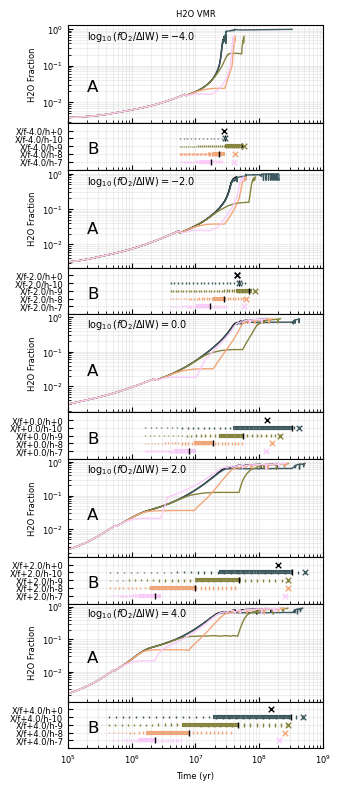

In [104]:
plt.style.use('MJs-theme.mplstyle')

# --- Constants ---
fO2_vals = sorted(set(f[0] for h in data_dict.values() for f in h))  # all unique fO₂ values
N = 30
H_ref = 0
rows = len(fO2_vals) * 2

fig, axes = plt.subplots(rows, 1, figsize=(3.39, 8.3), 
                         sharex=True, gridspec_kw={"height_ratios": [4, 1.9] * len(fO2_vals),
                                                   "hspace": 0})

for idx, fO2 in enumerate(fO2_vals):
    ax1 = axes[2*idx]
    ax2 = axes[2*idx + 1]

    # --- Extract curves ---
    base = {}
    for H in H_vals_sorted:
        for fO2_i, H_oceans, CH_ratio, SH_ratio, time, HC_a, phi, E in data_dict[H]:
            if fO2_i == fO2 and H_oceans == 3 and CH_ratio == 1 and SH_ratio == 2:
                base[H] = (time, HC_a)
                key = (fO2_i, H, H_oceans, CH_ratio, SH_ratio)
                start_time, stable_time, stop_time, vmr_time, s, sol_time = metrics[key]
                
                
                vmr_idx = [i for i, t in enumerate(time) if t == vmr_time]
                break

    # --- Plot upper: HC_a ---
    if idx == 0: 
        ax1.set_title(f"H2O VMR")
    for i, H in enumerate(H_vals_sorted):
        for fO2_i, H_oceans, CH_ratio, SH_ratio, time, HC_a, phi, E in data_dict[H]:
            if fO2_i == fO2 and H_oceans == 3 and SH_ratio == 2:
                color = H_tide_color_map[H]
                ax1.plot(time, HC_a, color=color)
    ax1.set_xscale("log")
    ax1.set_yscale("log")
    #ax1.set_ylim(1e-3, 1.01)
    #ax1.set_ylim(1e-5, 1e3)
    ax1.set_ylabel("H2O Fraction")
    ax1.grid(which='both', axis='both', alpha=0.2)

    # --- Plot lower: timeline bars ---
    bar_y = np.arange(len(H_vals_sorted))
    ax2.set_yticks(bar_y)
    ytick_labels = []

    for H in H_vals_sorted:
        found_case = False
        if H not in data_dict:
            ytick_labels.append(f"H={H:.0e}")
            continue
        for fO2_i, H_oceans, CH_ratio, SH_ratio, *_ in data_dict[H]:
            if fO2_i == fO2 and H_oceans == 3:
                label = get_case_label(fO2, H, H_oceans, CH_ratio, SH_ratio)
                ytick_labels.append(label)
                found_case = True
                break
        if not found_case:
            ytick_labels.append(f"H={H:.0e}")

    ax2.set_yticklabels(ytick_labels)
    ax2.set_xlabel("Time (yr)")
    ax2.set_xscale("log")
    ax2.set_xlim(1e5, 1e9)
    ax2.set_ylim(len(H_vals_sorted), -1)
    ax2.grid(which='both', axis='both', alpha=0.2)

    ax2.yaxis.set_minor_locator(plt.NullLocator())
    
    ax1.text(2e5, 0.5, rf"$\log_{{10}}(f\mathrm{{O}}_2 / \Delta \mathrm{{IW}}) = {fO2}$", fontsize=7)

    ax1.text(2e5, 0.02, "A", fontsize=12)
    ax2.text(2e5, 3, "B", fontsize=12)
    
    for i, H in enumerate(H_vals_sorted):
        for fO2_i, H_oceans, CH_ratio, SH_ratio, time, HC_a, phi, E in data_dict[H]:
            if fO2_i == fO2 and H_oceans == 3 and SH_ratio == 2:
                key = (fO2_i, H, H_oceans, CH_ratio, SH_ratio)
                start_time, stable_time, stop_time, vmr_time, s, sol_time = metrics[key]
                y = bar_y[i]
                color_H = H_tide_color_map[H]

                if H != H_ref:
                    if start_time < stable_time:
                        ax2.scatter(s[0], y*np.ones(len(s[0])), color=color_H, s=s[1], marker='|', zorder=10)
                    if stable_time < stop_time:
                        ax2.hlines(y, stable_time, stop_time, color=color_H, linestyle='-', linewidth=3, zorder=1)
                    ax2.scatter(vmr_time, y, color='black', marker='|', zorder=10)
                ax2.scatter(sol_time, y, color=color_H, marker='x', zorder=10)

# --- Final layout ---
fig.tight_layout(rect=[0, 0.05, 1, 1])

plt.savefig('h20_abundance_final.pgf')

plt.show()


# Figure 12

In [68]:
def get_data(root_path, N, data_dict, vmr_dict):

    for i in range(N):
        case_path = os.path.join(root_path, f"case_{i:05d}")
        config_path = os.path.join(case_path, "init_coupler.toml")
        csv_path = os.path.join(case_path, "runtime_helpfile.csv")

        if not (os.path.exists(config_path) and os.path.exists(csv_path)):
            print("Skipping ", i)
            continue

        config = toml.load(config_path)
                
        try:
            module = config["orbit"]["module"]
            H_tide = config["orbit"]["dummy"]["H_tide"]
            Phi_tide = config["orbit"]["dummy"]["Phi_tide"]
            shutdown = config["orbit"]["dummy"]["shutdown"]
        except KeyError:
            module = "none"
            H_tide = 0
            Phi_tide = "<0.3"
            shutdown = None
            
        if module == "none":
            H_tide = 0
            
        Pt_lt = bool(Phi_tide[0] == "<")
        Pt_va = float(Phi_tide[1:])
            
        fO2 = config["outgas"]["fO2_shift_IW"]
        H_oceans = config["delivery"]["elements"]["H_oceans"]
        CH_ratio = config["delivery"]["elements"]["CH_ratio"]
        SH_ratio = config["delivery"]["elements"]["SH_ratio"]
            #continue
            
#         if fO2 != 0:
#             continue           
#         if H_oceans != 3:
#             continue        
        if CH_ratio != 1:
            continue         
        if SH_ratio != 2:
            continue            
#         if H_tide != 1e-7:
#             continue     
        if Pt_va != 0.3:
            continue
                        
        df = pd.read_csv(csv_path, sep="\t")
        df = df[df["Time"] > 0]
        if df.empty:
            continue

        time = df["Time"]
        HC_a = df["H/C_atm"]
        H2O_a = df["H2O_mol_atm"]
        CO2_a = df["CO2_mol_atm"]
        CH4_a = df["CH4_mol_atm"]
        H2_a  = df[ "H2_mol_atm"]
        H2O_t = df["H2O_mol_total"]
        H2O_bar = df["H2O_bar"]
        rheo = df["RF_depth"]
        phi = df["Phi_global"]
        T_surf = df["T_surf"]
        #P_surf = np.array(df["F_atm"])
        
        F_asf = df["F_ins"] * 0.375 * np.cos(48.19 * np.pi/180.0)
        F_tidal = df["F_tidal"]
        F_net = df["F_atm"]
        
        F_olr = df["F_olr"]
        F_upw = df["F_olr"] + df["F_sct"]
        F_int = df["F_int"]
        F_radio = df["F_radio"]
        
        if H_tide == 0:
            E = None
        else:
            E = df["tot_tid_E"]
            
        data_dict.setdefault(H_tide, []).append((fO2, H_oceans, CH_ratio, SH_ratio, time, (F_net, F_tidal), phi, E))
        
        key = (fO2, H_tide, H_oceans, CH_ratio, SH_ratio)

        for _, row in df.iterrows():
            t = row["Time"]
            vmr_list = [row[vol + "_vmr"] for vol in vol_list]

            if key not in vmr_dict:
                vmr_dict[key] = {}
            vmr_dict[key][t] = vmr_list

In [69]:
# Define root path
root_path           = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_test_6"
root_path_final_H   = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_2V2"
root_path_final_C   = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_3"
root_path_final_S   = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_4"
root_path_final_H_2 = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_5_H"
root_path_final_C_2 = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_5_C"
root_path_final     = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_6"
root_path_final_2   = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_7V2"
root_path_final_C_2 = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_8V2"

# Prepare data storage
data_dict = {}
vmr_dict = {}

# Get data
get_data(root_path, 9, data_dict, vmr_dict)

get_data(root_path_final_H, 36, data_dict, vmr_dict)
get_data(root_path_final_C, 36, data_dict, vmr_dict)
get_data(root_path_final_S, 36, data_dict, vmr_dict)
get_data(root_path_final_H_2, 24, data_dict, vmr_dict)
get_data(root_path_final_C_2, 24, data_dict, vmr_dict)
get_data(root_path_final, 15, data_dict, vmr_dict)
# get_data(root_path_final_2, 6, data_dict, vmr_dict)
# get_data(root_path_final_C_2, 6, data_dict, vmr_dict)

# --- Create Color Map Using Scientific Colormap ---
H_vals_sorted = sorted(data_dict)

# Replace H=0 with a small dummy value for log scale (for color map only)
H_for_log = [1e-11 if H == 0 else H for H in H_vals_sorted]
norm = plt.Normalize(vmin=np.log10(min(H_for_log)), vmax=np.log10(max(H_for_log)))

# colormap from Scientific Colour Maps
colormap = cmc.batlowK

# Apply the norm using the adjusted list
H_tide_color_map = {
    H: colormap(norm(np.log10(1e-11 if H == 0 else H)))
    for H in H_vals_sorted
}

# Get timestamps
metrics = extract_curve_metrics(data_dict, H_vals_sorted)

Skipping  1
Skipping  3
Skipping  1
Skipping  2
Skipping  3
Skipping  8
Skipping  9
Skipping  10
Skipping  11
Skipping  12
Skipping  13
Skipping  14
Skipping  15
Skipping  16
Skipping  17
Skipping  18
Skipping  19
Skipping  20
Skipping  21
Skipping  22
Skipping  23
Skipping  0


/tmp/ipykernel_3741220/75479046.py:50: RuntimeWarning: divide by zero encountered in divide
  dEdt = np.gradient(E) / np.gradient(time)
/tmp/ipykernel_3741220/75479046.py:82: RuntimeWarning: divide by zero encountered in divide
  dEdt_slice = np.gradient(E.iloc[index0:final_index]) / np.gradient(t_original)
/tmp/ipykernel_3741220/75479046.py:86: RuntimeWarning: invalid value encountered in divide
  spacing_abs = spacing_rel / np.max(spacing_rel) * 5 + 1


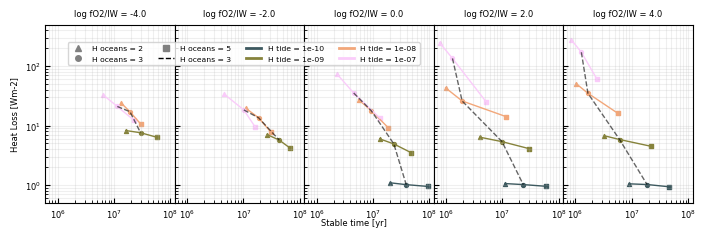

In [61]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib

# --- Constants ---
H_tide_vals = sorted(h for h in H_vals_sorted if h != 0)  
fO2_vals = sorted(set(f[0] for h in data_dict.values() for f in h))  # all unique fO₂ values

N = 30
H_ref = 0
cols = 5  # now horizontal stack

markers = {2: "^", 3: "o", 5: "s"}

fig, axes = plt.subplots(1, cols, figsize=(6.87, 2.2), sharey=True, sharex=True,
                         gridspec_kw={"wspace": 0.0})

for idx, fO2 in enumerate(fO2_vals):
    ax1 = axes[idx]
    ax1.set_title(f"log fO2/IW = {fO2}", fontsize=6)

    points_by_H = {}       # for solid lines of same color
    circles_all = []       # for dashed line connecting all circles

    for H in H_tide_vals:
        for fO2_i, H_oceans, CH_ratio, SH_ratio, time, HC_a, phi, E in data_dict[H]:
            if fO2_i == fO2 and CH_ratio == 1 and SH_ratio == 2:
                if fO2_i in [-2, -4] and H == 1e-10:
                    continue

                key = (fO2_i, H, H_oceans, CH_ratio, SH_ratio)
                start_time, stable_time, stop_time, vmr_time, s, sol_time = metrics[key]

                vmr_idx = [i for i, t in enumerate(time) if t == vmr_time]
                if not vmr_idx:
                    continue

                F_atm, F_tidal = HC_a
                    
                y_val = F_atm[vmr_idx[0]]
                x_val = stable_time

                color = H_tide_color_map[H]
                marker = markers[H_oceans]

                # Scatter point
                ax1.scatter(x_val, y_val, color=color, marker=marker, s=8)

                # Group by H for solid lines
                points_by_H.setdefault(H, []).append((x_val, y_val))

                # Group circles for dashed line
                if H_oceans == 3:
                    circles_all.append((x_val, y_val, color))

    # Plot solid lines (same H = same color)
    for H, pts in points_by_H.items():
        if len(pts) < 2:
            continue
        pts_sorted = sorted(pts, key=lambda x: x[0])
        xs, ys = zip(*pts_sorted)
        color = H_tide_color_map[H]
        ax1.plot(xs, ys, linestyle='-', color=color, linewidth=1)

        if idx == 0:
            ax1.set_ylabel("Heat Loss [Wm-2]", fontsize=6)
            
        
    # Plot dashed line connecting all circles (H_oceans == 3)
    if len(circles_all) >= 2:
        circles_sorted = sorted(circles_all, key=lambda x: x[0])
        xs, ys, _ = zip(*circles_sorted)
        ax1.plot(xs, ys, linestyle='--', color='black', linewidth=1, alpha=0.6)

    ax1.set_xscale("log")
    ax1.set_yscale("log")
    ax1.set_ylim(5e-1, 5e2)
    ax1.grid(which='both', axis='both', alpha=0.2)

    ax1.tick_params(axis='both', which='major', labelsize=6)
    ax1.tick_params(axis='both', which='minor', labelsize=6)
    
# --- Axis labels ---
fig.supxlabel("Stable time [yr]", fontsize=6)
#plt.title("Net Atmosphere Heat Loss vs. Stable Time for fO2 and Hydrogen abundance", fontsize=8)

# --- Legend ---
legend_elements = [
    Line2D([0], [0], marker=markers[2], color='gray', linestyle='None', label='H oceans = 2'),
    Line2D([0], [0], marker=markers[3], color='gray', linestyle='None', label='H oceans = 3'),
    Line2D([0], [0], marker=markers[5], color='gray', linestyle='None', label='H oceans = 5'),
]

# Add dashed line explanation
legend_elements.append(
    Line2D([0], [0], linestyle='--', color='black', lw=1, label='H oceans = 3')
)

# Add one entry per unique H (color)
for H in H_tide_vals:
    color = H_tide_color_map[H]
    legend_elements.append(
        Line2D([0], [0], color=color, lw=2, label=f"H tide = {H:.0e}")
    )


# Place legend outside the plot
fig.legend(handles=legend_elements, loc='lower center', ncol=4, bbox_to_anchor=(0.34, 0.73), fontsize=5.5)
fig.tight_layout(pad=0.0, w_pad=0.0)
#plt.savefig('sens_H_atm.pgf')

# --- Final layout ---
#fig.tight_layout(rect=[0, 0.1, 1, 1])
plt.show()

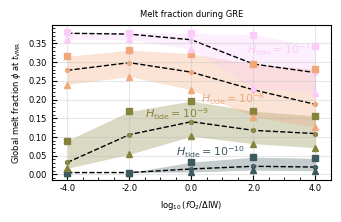

In [62]:
from collections import defaultdict
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

plt.style.use('MJs-theme.mplstyle')

fig, ax = plt.subplots(figsize=(3.39, 2.2))

# --- Step 1: Gather phi(VMR_time) data per H_tide and H_oceans ---
grouped_lines = defaultdict(list)    # for H_oceans == 3 (line plots)
grouped_markers = defaultdict(list)  # for all H_oceans (scatter markers)

grouped_by_oceans = {2: defaultdict(list), 3: defaultdict(list), 5: defaultdict(list)}

hatches = ['x', '|', 'x', '||', '|']
H_tide_vals = [H for H in H_vals_sorted if H != 0]

for H in H_vals_sorted:
    if H == 0 or H not in data_dict:
        continue
    for fO2_i, H_oceans, CH_ratio, SH_ratio, time, HC_a, phi, E in data_dict[H]:
        if CH_ratio == 1 and SH_ratio == 2 and H_oceans in [2, 3, 5]:
            key = (fO2_i, H, H_oceans, CH_ratio, SH_ratio)
            if key not in metrics:
                continue
            vmr_time = metrics[key][3]
            if vmr_time is None:
                continue
            phi_interp = interp1d(time, phi, bounds_error=False, fill_value=np.nan)
            phi_vmr = phi_interp(vmr_time)
            grouped_by_oceans[H_oceans][H].append((fO2_i, phi_vmr))


# --- Step 2: Find common fO2 values for line plots (H_oceans == 3 only) ---
common_fO2_vals = set.intersection(
    *(set(f for f, _ in v) for H_vals in grouped_by_oceans.values() for v in H_vals.values())
)
common_fO2_vals = sorted(common_fO2_vals)

for i, H in enumerate(H_tide_vals):
    if H not in grouped_by_oceans[2] or H not in grouped_by_oceans[3] or H not in grouped_by_oceans[5]:
        continue

    data_2 = {f: phi for f, phi in grouped_by_oceans[2][H] if f in common_fO2_vals}
    data_3 = {f: phi for f, phi in grouped_by_oceans[3][H] if f in common_fO2_vals}
    data_5 = {f: phi for f, phi in grouped_by_oceans[5][H] if f in common_fO2_vals}
    
    fO2_vals = sorted(set(data_2.keys()) & set(data_3.keys()))
    if not fO2_vals:
        continue
    
    phi_2 = np.array([data_2[f] for f in fO2_vals])
    phi_3 = np.array([data_3[f] for f in fO2_vals])
    phi_5 = np.array([data_5[f] for f in fO2_vals])
    
    color = H_tide_color_map[H]
    hatch = hatches[i % len(hatches)]

    ax.plot(fO2_vals, phi_2, color=color, marker='^', label=f"H_tide={H:.0e} (oceans=2)", linestyle="")
    ax.plot(fO2_vals, phi_3, color="black", linestyle="--", zorder=0.2)
    ax.scatter(fO2_vals, phi_3, color=color, marker='o', s=8, label=f"H tide={H:.0e}", zorder=0.8)
    ax.plot(fO2_vals, phi_5, color=color, marker='s', label=f"H_tide={H:.0e} (oceans=5)", linestyle="")
    
    ax.fill_between(fO2_vals, phi_2, phi_5, facecolor=color, edgecolor=color,
                    linewidth=0.0, zorder=0, alpha=0.3)

    
# --- Step 4: Plot markers for all H_oceans ---
for H in grouped_markers:
    color = H_tide_color_map[H]
    for fO2_i, phi_vmr, H_oceans in grouped_markers[H]:
        if fO2_i not in common_fO2_vals:
            continue
        if H_oceans not in markers:
            continue
        ax.scatter(fO2_i, phi_vmr, marker=markers[H_oceans], color=color, s=8, zorder=3)

ax.text(1.8, 0.32, r"$H_\mathrm{{tide}}=10^{-7}$", fontsize=8, color=H_tide_color_map[1e-7], zorder=10)
ax.text(0.3, 0.19, r"$H_\mathrm{{tide}}=10^{-8}$", fontsize=8, color=H_tide_color_map[1e-8], zorder=10)
ax.text(-1.5, 0.15, r"$H_\mathrm{{tide}}=10^{-9}$", fontsize=8, color=H_tide_color_map[1e-9], zorder=10)
ax.text(-0.5, 0.05, r"$H_\mathrm{{tide}}=10^{-10}$", fontsize=8, color=H_tide_color_map[1e-10], zorder=10)
        
# --- Step 5: Formatting ---
ax.set_xlabel(r"$\log_{10}(f\mathrm{O}_2 /\Delta \mathrm{IW})$")
ax.set_ylabel(r"Global melt fraction $\phi$ at $t_\mathrm{VMR}$")
ax.set_title("Melt fraction during GRE")
ax.set_xlim(min(common_fO2_vals)-0.5, max(common_fO2_vals)+0.5)
ax.set_xticks(common_fO2_vals)
ax.set_xticklabels([f"{f:.1f}" for f in common_fO2_vals])
ax.grid(True, alpha=0.3)

#ax.legend(bbox_to_anchor=(0.2, 0.35),loc='lower center', ncol=1)

plt.tight_layout()

#plt.savefig('melt_H.pgf')

plt.show()


In [75]:
from collections import defaultdict
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

plt.style.use('MJs-theme.mplstyle')

fig, ax = plt.subplots(figsize=(3.39, 2.2))

# --- Step 1: Gather phi(VMR_time) data per H_tide and H_oceans ---
grouped_lines = defaultdict(list)    # for H_oceans == 3 (line plots)
grouped_markers = defaultdict(list)  # for all H_oceans (scatter markers)

grouped_by_oceans = {2: defaultdict(list), 3: defaultdict(list), 5: defaultdict(list)}

hatches = ['x', '|', 'x', '||', '|']
H_tide_vals = [H for H in H_vals_sorted if H != 0]

for H in H_vals_sorted:
    if H == 0 or H not in data_dict:
        continue
    for fO2_i, H_oceans, CH_ratio, SH_ratio, time, HC_a, phi, E in data_dict[H]:
        if CH_ratio == 1 and SH_ratio == 2 and H_oceans in [2, 3, 5]:
            key = (fO2_i, H, H_oceans, CH_ratio, SH_ratio)
            if key not in metrics:
                continue
            vmr_time = metrics[key][3]
            if vmr_time is None:
                continue
            
            F_atm, F_tidal = HC_a
                
            F_tidal_interp = interp1d(time, F_tidal, bounds_error=False, fill_value=np.nan)
            F_tidal_vmr = F_tidal_interp(vmr_time)
            grouped_by_oceans[H_oceans][H].append((fO2_i, F_tidal_vmr))

# --- Step 2: Find common fO2 values for line plots (H_oceans == 3 only) ---
common_fO2_vals = set.intersection(
    *(set(f for f, _ in v) for H_vals in grouped_by_oceans.values() for v in H_vals.values())
)
common_fO2_vals = sorted(common_fO2_vals)

for i, H in enumerate(H_tide_vals):
    if H not in grouped_by_oceans[2] or H not in grouped_by_oceans[3] or H not in grouped_by_oceans[5]:
        continue

    data_2 = {f: F_tidal for f, F_tidal in grouped_by_oceans[2][H] if f in common_fO2_vals}
    data_3 = {f: F_tidal for f, F_tidal in grouped_by_oceans[3][H] if f in common_fO2_vals}
    data_5 = {f: F_tidal for f, F_tidal in grouped_by_oceans[5][H] if f in common_fO2_vals}
    
    fO2_vals = sorted(set(data_2.keys()) & set(data_3.keys()))
    if not fO2_vals:
        continue
    
    F_tidal_2 = np.array([data_2[f] for f in fO2_vals])
    F_tidal_3 = np.array([data_3[f] for f in fO2_vals])
    F_tidal_5 = np.array([data_5[f] for f in fO2_vals])
        
    color = H_tide_color_map[H]
    hatch = hatches[i % len(hatches)]

    ax.plot(fO2_vals, F_tidal_2, color=color, marker='^', label=f"H_tide={H:.0e} (oceans=2)", linestyle="")
    ax.plot(fO2_vals, F_tidal_3, color="black", linestyle="--", zorder=0.2)
    ax.scatter(fO2_vals, F_tidal_3, color=color, marker='o', s=8, label=f"H tide={H:.0e}", zorder=0.8)
    ax.plot(fO2_vals, F_tidal_5, color=color, marker='s', label=f"H_tide={H:.0e} (oceans=5)", linestyle="")
    
    ax.fill_between(fO2_vals, F_tidal_2, F_tidal_5, facecolor=color, edgecolor=color,
                    linewidth=0.0, zorder=0, alpha=0.3)

    
# --- Step 4: Plot markers for all H_oceans ---
for H in grouped_markers:
    color = H_tide_color_map[H]
    for fO2_i, F_tidal_vmr, H_oceans in grouped_markers[H]:
        if fO2_i not in common_fO2_vals:
            continue
        if H_oceans not in markers:
            continue
        ax.scatter(fO2_i, F_tidal_vmr, marker=markers[H_oceans], color=color, s=8, zorder=3)
     

# --- Step 5: Formatting ---
ax.set_xlabel(r"$\log_{10}(f\mathrm{O}_2 /\Delta \mathrm{IW})$")
ax.set_ylabel(r"Heat flux $F_{\mathrm{tidal}}$ [Wm$^{-2}$] at $t_\mathrm{VMR}$")
ax.set_title("Tidal heat flux at surface during GRE")
ax.set_xlim(min(common_fO2_vals)-0.5, max(common_fO2_vals)+0.5)
ax.set_xticks(common_fO2_vals)
ax.set_xticklabels([f"{f:.1f}" for f in common_fO2_vals])
ax.set_yscale("log")
ax.grid(True, alpha=0.3)

#ax.legend(bbox_to_anchor=(0.2, 0.35),loc='lower center', ncol=1)

plt.tight_layout()

#plt.savefig('melt_H.pgf')

plt.show()


# Figure 13

In [107]:
def get_data(root_path, N, data_dict, vmr_dict):

    for i in range(N):
        case_path = os.path.join(root_path, f"case_{i:05d}")
        config_path = os.path.join(case_path, "init_coupler.toml")
        csv_path = os.path.join(case_path, "runtime_helpfile.csv")

        if not (os.path.exists(config_path) and os.path.exists(csv_path)):
            print("Skipping ", i)
            continue

        config = toml.load(config_path)
                
        try:
            module = config["orbit"]["module"]
        except KeyError:
            module = "none"
        try:
            H_tide = config["orbit"]["dummy"]["H_tide"]
        except KeyError:
            H_tide = 0
        try:
            Phi_tide = config["orbit"]["dummy"]["Phi_tide"]
        except KeyError:
            Phi_tide = "<0.3"
        try:
            shutdown = config["orbit"]["dummy"]["shutdown"]
        except KeyError:
            shutdown = None          
            
        if module == "none":
            H_tide = 0
            
        Pt_lt = bool(Phi_tide[0] == "<")
        Pt_va = float(Phi_tide[1:])
            
        fO2 = config["outgas"]["fO2_shift_IW"]
        H_oceans = config["delivery"]["elements"]["H_oceans"]
        CH_ratio = config["delivery"]["elements"]["CH_ratio"]
        SH_ratio = config["delivery"]["elements"]["SH_ratio"]
            #continue
            
        if fO2 not in [-2, 0]:
            continue           
        if H_oceans != 3:
            continue        
#         if CH_ratio != 1:
#             continue         
#         if SH_ratio != 2:
#             continue            
#         if H_tide != 1e-7:
#             continue     
        if Pt_va != 0.3:
            continue
                        
        df = pd.read_csv(csv_path, sep="\t")
        df = df[df["Time"] > 0]
        if df.empty:
            continue

        time = df["Time"]
        HC_a = df["H/C_atm"]
        H2O_a = df["H2O_mol_atm"]
        CO2_a = df["CO2_mol_atm"]
        CH4_a = df["CH4_mol_atm"]
        H2_a  = df[ "H2_mol_atm"]
        H2O_t = df["H2O_mol_total"]
        H2O_bar = df["H2O_bar"]
        rheo = df["RF_depth"]
        phi = df["Phi_global"]
        T_surf = df["T_surf"]
        #P_surf = np.array(df["F_atm"])
        
        F_asf = df["F_ins"] * 0.375 * np.cos(48.19 * np.pi/180.0)
        F_tidal = df["F_tidal"]
        F_net = df["F_atm"]
        
        F_olr = df["F_olr"]
        F_upw = df["F_olr"] + df["F_sct"]
        F_int = df["F_int"]
        F_radio = df["F_radio"]
        
        if H_tide == 0:
            E = None
        else:
            E = df["tot_tid_E"]
            
            
        #F_tid = df["F_tidal"]
        #print(fO2, H_tide, H_oceans, F_tid.iloc[-1], F_tid.iloc[-1] < 0.1)

        #data_dict.setdefault(H_tide, []).append((fO2, H_oceans, CH_ratio, SH_ratio, time, (F_net, F_asf, F_olr, F_upw, F_int, F_tidal, F_radio), phi, E))
                
        #data_dict.setdefault(H_tide, []).append((fO2, H_oceans, CH_ratio, SH_ratio, time, H2O_a/H2O_t, phi, E))
        #data_dict.setdefault(H_tide, []).append((fO2, H_oceans, CH_ratio, SH_ratio, time, F_tidal, phi, E))
        #data_dict.setdefault(H_tide, []).append((fO2, H_oceans, CH_ratio, SH_ratio, time, H2O_bar, phi, E))
        #data_dict.setdefault(H_tide, []).append((fO2, H_oceans, CH_ratio, SH_ratio, time, F_net, phi, E))
        #data_dict.setdefault(H_tide, []).append((fO2, H_oceans, CH_ratio, Pt_va, time, F_net, phi, E))
        data_dict.setdefault(H_tide, []).append((fO2, H_oceans, CH_ratio, SH_ratio, time, 1-rheo, phi, E)) 
        #data_dict.setdefault(H_tide, []).append((fO2, H_oceans, CH_ratio, Pt_va, time, 1-rheo, phi, E)) 
        #data_dict.setdefault(H_tide, []).append((fO2, H_oceans, CH_ratio, SH_ratio, time, (CO2_a, CH4_a, H2_a), phi, E))
        #data_dict.setdefault(H_tide, []).append((fO2, H_oceans, CH_ratio, SH_ratio, time, 1-rheo, phi, E, T_surf, P_surf))
        
        key = (fO2, H_tide, H_oceans, CH_ratio, SH_ratio)

        for _, row in df.iterrows():
            t = row["Time"]
            vmr_list = [row[vol + "_vmr"] for vol in vol_list]

            if key not in vmr_dict:
                vmr_dict[key] = {}
            vmr_dict[key][t] = vmr_list

In [108]:
# Define root path
root_path           = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_test_6"
root_path_final_H   = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_2V2"
root_path_final_C   = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_3"
root_path_final_S   = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_4"
root_path_final_H_2 = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_5_H"
root_path_final_C_2 = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_5_C"
root_path_final     = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_6"
root_path_final_2   = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_7V2"
root_path_final_C_2_2 = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_8V2"

# Prepare data storage
data_dict = {}
vmr_dict = {}

# Get data
get_data(root_path, 9, data_dict, vmr_dict)

get_data(root_path_final_H, 36, data_dict, vmr_dict)
get_data(root_path_final_C, 36, data_dict, vmr_dict)
get_data(root_path_final_S, 36, data_dict, vmr_dict)
get_data(root_path_final_H_2, 24, data_dict, vmr_dict)
get_data(root_path_final_C_2, 24, data_dict, vmr_dict)
get_data(root_path_final, 15, data_dict, vmr_dict)
get_data(root_path_final_2, 6, data_dict, vmr_dict)
get_data(root_path_final_C_2_2, 6, data_dict, vmr_dict)

# --- Create Color Map Using Scientific Colormap ---
H_vals_sorted = sorted(data_dict)

# Replace H=0 with a small dummy value for log scale (for color map only)
H_for_log = [1e-11 if H == 0 else H for H in H_vals_sorted]
norm = plt.Normalize(vmin=np.log10(min(H_for_log)), vmax=np.log10(max(H_for_log)))

# colormap from Scientific Colour Maps
colormap = cmc.batlowK

# Apply the norm using the adjusted list
H_tide_color_map = {
    H: colormap(norm(np.log10(1e-11 if H == 0 else H)))
    for H in H_vals_sorted
}

# Get timestamps
metrics = extract_curve_metrics(data_dict, H_vals_sorted)

Skipping  1
Skipping  3
Skipping  1
Skipping  2
Skipping  3
Skipping  0


/tmp/ipykernel_3757507/75479046.py:50: RuntimeWarning: divide by zero encountered in divide
  dEdt = np.gradient(E) / np.gradient(time)
/tmp/ipykernel_3757507/75479046.py:82: RuntimeWarning: divide by zero encountered in divide
  dEdt_slice = np.gradient(E.iloc[index0:final_index]) / np.gradient(t_original)
/tmp/ipykernel_3757507/75479046.py:86: RuntimeWarning: invalid value encountered in divide
  spacing_abs = spacing_rel / np.max(spacing_rel) * 5 + 1


BrokenPipeError: [Errno 32] Broken pipe

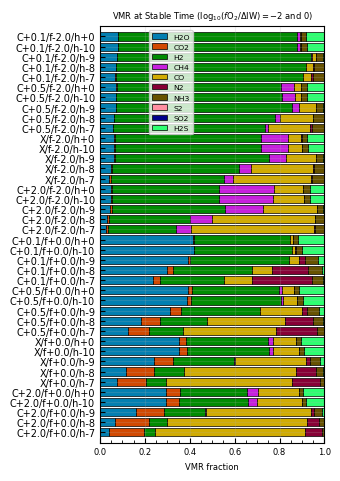

In [110]:
plt.style.use('MJs-theme.mplstyle')

# Determine y-index map first
idx_map = {}

for i, H in enumerate(H_vals_sorted):
    for fO2_i, H_oceans, CH_ratio, SH_ratio, *_ in data_dict[H]:
        key = (fO2_i, H, H_oceans, CH_ratio, SH_ratio)
        #fo2_idx = (fO2_i + 4) / 8 * 80
        #H_oceans_idx = (CH_ratio - 2) / 3 * 15
        
        if H_oceans != 3:
            continue
        if SH_ratio != 2:
            continue
            
        fo2_idx = (fO2_i + 2) / 8 * 80
        H_oceans_idx = 0
        
        
        if CH_ratio == 0.1:
            H_oceans_idx = 0
        elif CH_ratio == 0.5:
            H_oceans_idx = 5
        elif CH_ratio == 1:
            H_oceans_idx = 10
        elif CH_ratio == 2:
            H_oceans_idx = 15    
            
#         if SH_ratio == 0.1:
#             H_oceans_idx = 0
#         elif SH_ratio == 1:
#             H_oceans_idx = 5
#         elif SH_ratio == 2:
#             H_oceans_idx = 10
#         elif SH_ratio == 3:
#             H_oceans_idx = 15  
        
        H_idx = (int(np.log10(H))+11) if H != 0 else 0
        idx = int(fo2_idx + H_oceans_idx + H_idx)
        idx_map[key] = idx

# Sort keys by idx
sorted_keys = sorted(idx_map.items(), key=lambda item: item[1])

def plot_vmr_only(selected_items, N):
    fig, ax_vmr = plt.subplots(figsize=(3.39, 0.12*N))

    bar_y = np.arange(N)
    ytick_labels = ["" for _ in range(N)]

    first_it = True

    for plot_idx, (key, local_idx) in enumerate(selected_items):
        fO2_i, H, H_oceans, CH_ratio, SH_ratio = key
        label = get_case_label(*key)
        ytick_labels[local_idx] = label
        y = bar_y[local_idx]

        bar_data = vmr_dict.get(key, {})
        if not bar_data:
            continue

        vmr_time = metrics[key][3]
        if vmr_time in bar_data:
            vmr_mid = np.array(bar_data[vmr_time])
        else:
            nearest_time = min(bar_data.keys(), key=lambda t: abs(t - vmr_time))
            vmr_mid = np.array(bar_data[nearest_time])

        total_mid = np.sum(vmr_mid)
        vmr_mid = vmr_mid / total_mid if total_mid > 0 else np.zeros_like(vmr_mid)

        colors = [color_map.get(vol, "#cccccc") for vol in vol_list]

        x_left = 0
        for vmr_val, (j, color) in zip(vmr_mid, enumerate(colors)):
            if vmr_val > 0:
                ax_vmr.barh(
                    y,
                    vmr_val,
                    left=x_left,
                    height=0.8,
                    color=color,
                    edgecolor='black',
                    linewidth=0.5,
                    label=vol_list[j] if first_it else None
                )
                x_left += vmr_val

        first_it = False

    # Axis setup
    ax_vmr.set_ylim(N, -1)
    ax_vmr.set_yticks(bar_y)
    ax_vmr.set_yticklabels(ytick_labels, fontsize=7)
    ax_vmr.set_xlabel("VMR fraction")
    ax_vmr.set_xlim(0, 1.0)
    ax_vmr.grid(axis='x', alpha=0.2)
    ax_vmr.set_title(r"VMR at Stable Time (log$_{{10}}$($f$O$_2 / \Delta \mathrm{{IW}}) = -2 \ \mathrm{{and}} \ 0$)")

    ax_vmr.yaxis.set_minor_locator(plt.NullLocator())
    
    handles, labels = ax_vmr.get_legend_handles_labels()
    if handles:
        ax_vmr.legend(handles, labels, bbox_to_anchor=(0.2, 1.0), loc='upper left')

    plt.tight_layout()
    
    #plt.savefig('sens_C_VMR_final.pgf')
    
    plt.show()


# Filter to only fO2 = -2 and 0
filtered_keys = [(key, idx) for key, idx in sorted_keys if key[0] in [-2, 0]]

# Plot
plot_vmr_only(filtered_keys, 40)

# Figure 14

In [61]:
def get_data(root_path, N, data_dict, vmr_dict):

    for i in range(N):
        case_path = os.path.join(root_path, f"case_{i:05d}")
        config_path = os.path.join(case_path, "init_coupler.toml")
        csv_path = os.path.join(case_path, "runtime_helpfile.csv")

        if not (os.path.exists(config_path) and os.path.exists(csv_path)):
            print("Skipping ", i)
            continue

        config = toml.load(config_path)
                
        try:
            module = config["orbit"]["module"]
        except KeyError:
            module = "none"
        try:
            H_tide = config["orbit"]["dummy"]["H_tide"]
        except KeyError:
            H_tide = 0
        try:
            Phi_tide = config["orbit"]["dummy"]["Phi_tide"]
        except KeyError:
            Phi_tide = "<0.3"
        try:
            shutdown = config["orbit"]["dummy"]["shutdown"]
        except KeyError:
            shutdown = None          
            
        if module == "none":
            H_tide = 0
            
        Pt_lt = bool(Phi_tide[0] == "<")
        Pt_va = float(Phi_tide[1:])
            
        fO2 = config["outgas"]["fO2_shift_IW"]
        H_oceans = config["delivery"]["elements"]["H_oceans"]
        CH_ratio = config["delivery"]["elements"]["CH_ratio"]
        SH_ratio = config["delivery"]["elements"]["SH_ratio"]
                     
        if CH_ratio != 1:
            continue         
        if SH_ratio != 2:
            continue          
        if Pt_va != 0.3:
            continue
                        
        df = pd.read_csv(csv_path, sep="\t")
        df = df[df["Time"] > 0]
        if df.empty:
            continue

        time = df["Time"]
        HC_a = df["H/C_atm"]
        H2O_a = df["H2O_mol_atm"]
        CO2_a = df["CO2_mol_atm"]
        CH4_a = df["CH4_mol_atm"]
        H2_a  = df[ "H2_mol_atm"]
        H2O_t = df["H2O_mol_total"]
        H2O_bar = df["H2O_bar"]
        rheo = df["RF_depth"]
        phi = df["Phi_global"]
        T_surf = df["T_surf"]
        #P_surf = np.array(df["F_atm"])
        
        F_asf = df["F_ins"] * 0.375 * np.cos(48.19 * np.pi/180.0)
        F_tidal = df["F_tidal"]
        F_net = df["F_atm"]
        
        F_olr = df["F_olr"]
        F_upw = df["F_olr"] + df["F_sct"]
        F_int = df["F_int"]
        F_radio = df["F_radio"]
        
        if H_tide == 0:
            E = None
        else:
            E = df["tot_tid_E"]
            
        data_dict.setdefault(H_tide, []).append((fO2, H_oceans, CH_ratio, SH_ratio, time, 1-rheo, phi, E)) 
        
        key = (fO2, H_tide, H_oceans, CH_ratio, SH_ratio)

        for _, row in df.iterrows():
            t = row["Time"]
            vmr_list = [row[vol + "_vmr"] for vol in vol_list]

            if key not in vmr_dict:
                vmr_dict[key] = {}
            vmr_dict[key][t] = vmr_list

In [62]:
# Define root path
root_path           = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_test_6"
root_path_final_H   = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_2V2"
root_path_final_C   = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_3"
root_path_final_S   = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_4"
root_path_final_H_2 = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_5_H"
root_path_final_C_2 = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_5_C"
root_path_final     = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_6"
root_path_final_2   = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_7V2"
root_path_final_C_2_2 = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_8V2"

# Prepare data storage
data_dict = {}
vmr_dict = {}

# Get data
get_data(root_path, 9, data_dict, vmr_dict)

get_data(root_path_final_H, 36, data_dict, vmr_dict)
get_data(root_path_final_C, 36, data_dict, vmr_dict)
get_data(root_path_final_S, 36, data_dict, vmr_dict)
get_data(root_path_final_H_2, 24, data_dict, vmr_dict)
get_data(root_path_final_C_2, 24, data_dict, vmr_dict)
get_data(root_path_final, 15, data_dict, vmr_dict)
get_data(root_path_final_2, 6, data_dict, vmr_dict)
get_data(root_path_final_C_2_2, 6, data_dict, vmr_dict)

# --- Create Color Map Using Scientific Colormap ---
H_vals_sorted = sorted(data_dict)

# Replace H=0 with a small dummy value for log scale (for color map only)
H_for_log = [1e-11 if H == 0 else H for H in H_vals_sorted]
norm = plt.Normalize(vmin=np.log10(min(H_for_log)), vmax=np.log10(max(H_for_log)))

# colormap from Scientific Colour Maps
colormap = cmc.batlowK

# Apply the norm using the adjusted list
H_tide_color_map = {
    H: colormap(norm(np.log10(1e-11 if H == 0 else H)))
    for H in H_vals_sorted
}

# Get timestamps
metrics = extract_curve_metrics(data_dict, H_vals_sorted)

Hello
Hello
Hello
Hello
Hello
Hello
Hello
Hello
Hello
Skipping  1
Skipping  3
Skipping  1
Skipping  2
Skipping  3
Skipping  0
Hello
Hello
Hello
Hello
Hello
Hello
Hello
Hello
Hello
Hello
Hello
Hello
Hello
Hello
Hello
Hello
Hello
Hello
Hello
Hello
Hello
Hello
Hello
Hello
Hello
Hello
(-4.0, 0, 2.0, 1.0, 2.0)
(-4.0, 0, 3.0, 1.0, 2.0)
(-4.0, 0, 5.0, 1.0, 2.0)
(0.0, 0, 2.0, 1.0, 2.0)
(0.0, 0, 3.0, 1.0, 2.0)
(0.0, 0, 5.0, 1.0, 2.0)
(4.0, 0, 2.0, 1.0, 2.0)
(4.0, 0, 3.0, 1.0, 2.0)
(4.0, 0, 5.0, 1.0, 2.0)
(-2.0, 0, 2.0, 1.0, 2.0)
(-2.0, 0, 3.0, 1.0, 2.0)
(-2.0, 0, 5.0, 1.0, 2.0)
(2.0, 0, 2.0, 1.0, 2.0)
(2.0, 0, 3.0, 1.0, 2.0)
(2.0, 0, 5.0, 1.0, 2.0)
(-2.0, 0, 3.0, 1.0, 2.0)
(-4.0, 1e-10, 2.0, 1.0, 2.0)
(-4.0, 1e-10, 3.0, 1.0, 2.0)
(-4.0, 1e-10, 5.0, 1.0, 2.0)
(0.0, 1e-10, 2.0, 1.0, 2.0)
(0.0, 1e-10, 3.0, 1.0, 2.0)
(0.0, 1e-10, 5.0, 1.0, 2.0)
(4.0, 1e-10, 2.0, 1.0, 2.0)
(4.0, 1e-10, 3.0, 1.0, 2.0)
(4.0, 1e-10, 5.0, 1.0, 2.0)
(-2.0, 1e-10, 2.0, 1.0, 2.0)
(-2.0, 1e-10, 3.0, 1.0, 2.0)
(-2.0, 1e-10, 

/tmp/ipykernel_3751925/3055804340.py:149: RuntimeWarning: divide by zero encountered in divide
  dEdt = np.gradient(E) / np.gradient(time)
/tmp/ipykernel_3751925/3055804340.py:181: RuntimeWarning: divide by zero encountered in divide
  dEdt_slice = np.gradient(E.iloc[index0:final_index]) / np.gradient(t_original)
/tmp/ipykernel_3751925/3055804340.py:185: RuntimeWarning: invalid value encountered in divide
  spacing_abs = spacing_rel / np.max(spacing_rel) * 5 + 1


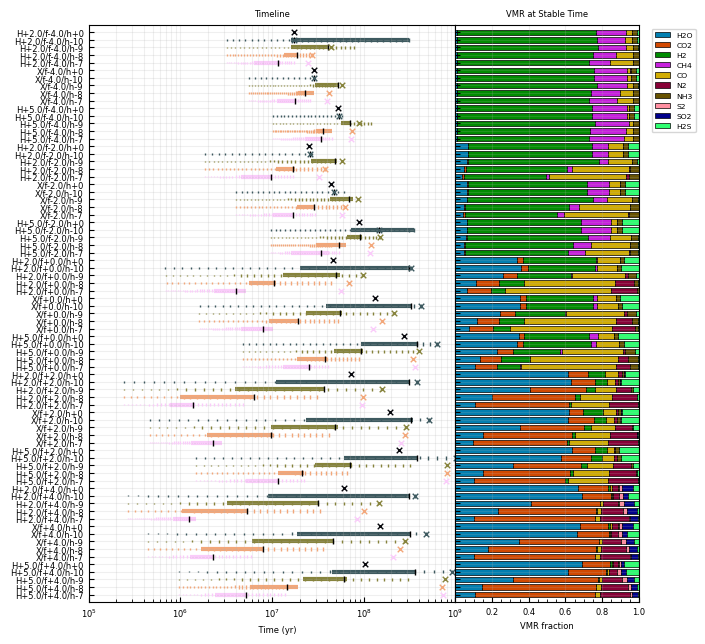

In [67]:
plt.style.use('MJs-theme.mplstyle')

# Determine y-index map first
idx_map = {}

for i, H in enumerate(H_vals_sorted):
    for fO2_i, H_oceans, CH_ratio, SH_ratio, *_ in data_dict[H]:
        key = (fO2_i, H, H_oceans, CH_ratio, SH_ratio)
        fo2_idx = (fO2_i + 4) / 8 * 60
        #H_oceans_idx = (H_oceans - 2) / 3 * 15
        
#         if H_oceans != 3:
#             continue
            
#         fo2_idx = (fO2_i + 4) / 8 * 20
#         H_oceans_idx = 0
        
        
        if H_oceans == 2:
            H_oceans_idx = 0
        elif H_oceans == 3:
            H_oceans_idx = 5
        elif H_oceans == 5:
            H_oceans_idx = 10    
            
#         if SH_ratio == 0.1:
#             H_oceans_idx = 0
#         elif SH_ratio == 1:
#             H_oceans_idx = 5
#         elif SH_ratio == 2:
#             H_oceans_idx = 10
#         elif SH_ratio == 3:
#             H_oceans_idx = 15  
        
        H_idx = (int(np.log10(H))+11) if H != 0 else 0
        idx = int(fo2_idx + H_oceans_idx + H_idx)
        idx_map[key] = idx

# Sort keys by idx
sorted_keys = sorted(idx_map.items(), key=lambda item: item[1])

def plot_figure(selected_items, N, annotations=False):
    gs = GridSpec(1, 2, width_ratios=[2, 1], wspace=0)

    ax_timeline = fig.add_subplot(gs[0, 0])
    ax_vmr = fig.add_subplot(gs[0, 1])

    bar_y = np.arange(N)
    ytick_labels = ["" for _ in range(N)]

    first_it = True

    for plot_idx, (key, local_idx) in enumerate(selected_items):
        fO2_i, H, H_oceans, CH_ratio, SH_ratio = key
        label = get_case_label(*key)
        ytick_labels[local_idx] = label
        y = bar_y[local_idx]

        color_H = H_tide_color_map[H]
        start_time, stable_time, stop_time, vmr_time, s, sol_time = metrics[key]
                
        if H != 0:
            if start_time < stable_time:
                ax_timeline.scatter(s[0], y*np.ones(len(s[0])), color=color_H, s=s[1], marker='|', zorder=10)

            if stable_time < stop_time:
                ax_timeline.hlines(y, stable_time, stop_time, color=color_H, linestyle='-', linewidth=3, zorder=1)
            
            ax_timeline.scatter(vmr_time, y, color='black', marker='|', zorder=10)
                        
        ax_timeline.scatter(sol_time, y, color=color_H, marker='x', zorder=10)

        bar_data = vmr_dict.get(key, {})
        if not bar_data:
            continue

        if vmr_time in bar_data:
            vmr_mid = np.array(bar_data[vmr_time])
        else:
            nearest_time = min(bar_data.keys(), key=lambda t: abs(t - vmr_time))
            vmr_mid = np.array(bar_data[nearest_time])

        total_mid = np.sum(vmr_mid)
        vmr_mid = vmr_mid / total_mid if total_mid > 0 else np.zeros_like(vmr_mid)

        colors = [color_map.get(vol, "#cccccc") for vol in vol_list]

        x_left = 0
        for vmr_val, (j, color) in zip(vmr_mid, enumerate(colors)):
            if vmr_val > 0:
                ax_vmr.barh(
                    y,
                    vmr_val,
                    left=x_left,
                    height=0.73,
                    color=color,
                    edgecolor='black',
                    linewidth=0.5,
                    label=vol_list[j] if first_it else None
                )
                x_left += vmr_val

        first_it = False

    # Axis setup
    ax_timeline.set_xscale("log")
    ax_timeline.set_xlim(1e5, 1e9)
    ax_timeline.set_ylim(N, -1)
    ax_timeline.set_yticks(bar_y)
    ax_timeline.set_yticklabels(ytick_labels)
    ax_timeline.set_xlabel("    Time (yr)")
    ax_timeline.set_title("Timeline")
    ax_timeline.grid(which='both', axis='both', alpha=0.2)

    ax_timeline.yaxis.set_minor_locator(plt.NullLocator())
    
    ax_vmr.set_ylim(N, -1)
    ax_vmr.set_yticks(bar_y)
    ax_vmr.set_yticklabels([])  # y-labels already on left
    ax_vmr.set_xlabel("VMR fraction")
    ax_vmr.set_xlim(0, 1.0)
    
    ax_vmr.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax_vmr.set_xticklabels(["", "0.2", "0.4", "0.6", "0.8", "1.0"])
    ax_vmr.set_title("VMR at Stable Time")
    ax_vmr.grid(axis='x', alpha=0.2)

    ax_vmr.yaxis.set_minor_locator(plt.NullLocator())
        
    handles, labels = ax_vmr.get_legend_handles_labels()
    if handles:
        ax_vmr.legend(handles, labels, bbox_to_anchor=(1.05, 1.0), loc='upper left')
        
    if annotations:
        colors = [color_map.get(vol, "#cccccc") for vol in vol_list]
                
        # Choose a specific key to annotate
        key_to_annotate = sorted_keys[-1][0]  # for example, the 11th item
        start_time, stable_time, stop_time, vmr_time, s, sol_time = metrics[key_to_annotate]
        local_idx = idx_map[key_to_annotate]
        y = bar_y[local_idx]       

        color = "black"
        #color = H_tide_color_map[1e-7]
        color_bkg = "white"
        
        ax_timeline.annotate('Start Tidal Heating',
            xy=(start_time, y), xycoords='data',
            xytext=(-28, -17), textcoords='offset points',
            bbox=dict(boxstyle="round", fc=color_bkg, ec=color, lw=1),
            arrowprops=dict(arrowstyle="-", relpos=(0.5, 1), color=color))

        from matplotlib.patches import FancyArrowPatch

        # Define coordinates
        start = (0.75 * vmr_time, y + 0.5)  # data point to annotate
        end = ax_timeline.transData.transform(start) + np.array([70, -27])  # offset in screen coords
        end = ax_timeline.transData.inverted().transform(end)  # convert back to data coords
        end_2 = ax_timeline.transData.transform(start) + np.array([0, -27])  # offset in screen coords
        end_2 = ax_timeline.transData.inverted().transform(end_2)  # convert back to data coords

        # Draw the arrow
        arrow = FancyArrowPatch(
            posA=end_2,  # tail
            posB=start,  # head (arrow points to the data point)
            arrowstyle='-[',  # bracket arrow
            mutation_scale=12,  # overall size of arrow
            lw=1.5,
            color=color
        )
        ax_timeline.add_patch(arrow)

        # Draw the text box
        ax_timeline.text(
            end[0], end[1], 'Global Radiative Equilibrium epoch',
            bbox=dict(boxstyle="round", fc=color_bkg, ec=color, lw=1),
            ha='center', va='top'
        )

        
        ax_timeline.annotate('VMR time',
            xy=(vmr_time, y), xycoords='data',
            xytext=(0, -17), textcoords='offset points',
            bbox=dict(boxstyle="round", fc=color_bkg, ec=color, lw=1),
            arrowprops=dict(arrowstyle="-", relpos=(0, 1), color=color))
        
        ax_timeline.annotate('End Tidal Heating',
            xy=(s[0][-1], y), xycoords='data',
            xytext=(20, -17), textcoords='offset points',
            bbox=dict(boxstyle="round", fc=color_bkg, ec=color, lw=1),
            arrowprops=dict(arrowstyle="-", relpos=(0, 1), color=color))
        
        lbl = r'$\phi \leq 0.005$'
        
        ax_timeline.annotate(lbl,
            xy=(sol_time, y), xycoords='data',
            xytext=(-20, -17), textcoords='offset points',
            bbox=dict(boxstyle="round", fc=color_bkg, ec=color, lw=1),
            arrowprops=dict(arrowstyle="-", relpos=(0.67, 1), color=color))

#     ax_timeline.text(5e8, 26.5, "A", fontsize=12)
#     ax_vmr.text(0.05, 26.5, "B", fontsize=12)
        
    #plt.savefig('timeline+VMR_HV4.pgf')
        
    #plt.suptitle(fig_title)
    plt.show()

fig = plt.figure(figsize=(7.1, 7.5))
plot_figure(sorted_keys, 75)

# Figure 15

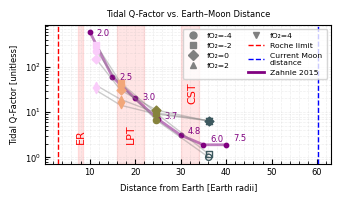

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.ticker import FuncFormatter

from scipy.optimize import curve_fit

def log_fit(x, a, b):
    return a * (x) + b

plt.style.use('MJs-theme.mplstyle')

# Constants
G = 6.6743e-11
R_earth = 6.378e6
M_earth = 5.9722e24
M_moon = 7.34767309e22
I = 2/5 * M_earth * R_earth**2

omega_ini = 4.07 * 7.05e33 / I
omega_fin = 7.05e33 / I

#print(omega_fin, omega_ini)

# Roche & present distances
r_roche = 19.900e6 / R_earth
r_current = 384e6 / R_earth


L_EM = 3.4549071039524207e+34 

def omega_earth(R_intern):
    return 1/I * (-M_moon * np.sqrt(G * R_intern) / (2 * np.pi) + L_EM)

def R_at_omega(Q_inv, h, N):
    return ((9/10) * G * R_earth**5 * M_moon**2 * Q_inv * h / N)**(1/6)

# Your simulation input
H_tide_vals = [1e-7, 1e-8, 1e-9, 1e-10]
fo2_labels = [-4, -2, 0, 2, 4]

Q_vals = [
    [22.16, 16.14, 33.21, 126.50, 163.49],
    [12.30, 11.06, 16.11, 25.86, 34.81],
    [7.41,  5.25,  4.44,   5.13,  5.44],
    [np.nan,  np.nan,  0.78,   0.76,  0.77],
]

durations_100Myr = [
    [0.067, 0.074, 0.0575, 0.0155, 0.0109],
    [0.096, 0.108, 0.104, 0.0818, 0.0647],
    [0.248, 0.330, 0.350, 0.427, 0.404],
    [np.nan,  np.nan,  2.91,  3.17,  3.10],
]

# H_tide and fO2 axis values
H_tide_vals = np.array([1e-7, 1e-8, 1e-9, 1e-10])
fO2_vals = np.array([-1, 0, 1, 2, 3])  # Assumed, since you have 5 columns

# Convert to np.array with np.nan
Q_np = np.array([[np.nan if v is None else v for v in row] for row in Q_vals])
dur_np = np.array([[np.nan if v is None else v for v in row] for row in durations_100Myr])

def extrapolate_weighted(data, x_axis, y_axis):
    filled = data.copy()
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if np.isnan(data[i, j]):
                # Column extrapolation (varying i, fixed j)
                col_idx = ~np.isnan(data[:, j])
                if np.sum(col_idx) >= 2:
                    popt_col, _ = curve_fit(log_fit, x_axis[col_idx], data[col_idx, j])
                    val_col = log_fit(x_axis[i], *popt_col)
                else:
                    val_col = np.nan

                # Row extrapolation (varying j, fixed i)
                row_idx = ~np.isnan(data[i, :])
                if np.sum(row_idx) >= 2:
                    popt_row, _ = curve_fit(log_fit, y_axis[row_idx], data[i, row_idx])
                    val_row = log_fit(y_axis[j], *popt_row)
                else:
                    val_row = np.nan

                # Weighted average (equal weight if both are valid)
                if not np.isnan(val_col) and not np.isnan(val_row):
                    filled[i, j] = 0.5 * val_col + 0.5 * val_row
                elif not np.isnan(val_col):
                    filled[i, j] = val_col
                elif not np.isnan(val_row):
                    filled[i, j] = val_row
                # else remains NaN (not enough data)
    return filled

# Fill Q and durations
Q_filled = extrapolate_weighted(Q_np, H_tide_vals, fO2_vals)
dur_filled = extrapolate_weighted(dur_np, H_tide_vals, fO2_vals)

# Convert durations
yr_to_s = 365.25 * 24 * 3600
hundred_Myr_to_s = 1e8 * yr_to_s
durations_sec = [[d * hundred_Myr_to_s if d is not None else None for d in row] for row in dur_filled]

markers = ['o', 's', 'D', '^', 'v']
fo2_marker_map = {fo2: m for fo2, m in zip(fo2_labels, markers)}

fig, ax = plt.subplots(figsize=(3.39, 2))
#ax2 = ax.twiny()

# Plot your simulation data
for j, fo2_label in enumerate(fo2_labels):
    Rs, Q1_inv = [], []
    for i, H_tide in enumerate(H_tide_vals):
        Q = Q_filled[i][j]
        duration = durations_sec[i][j]
        if duration is None:
            continue

        Q_1 = 1 / (2 * np.pi * H_tide) * (Q * 5.101e14 / 4.01e24)
        delta_L = 0.95 * 3.1 * 7.07e33
        
        N = Q * 4 * np.pi * R_earth**2 / (omega_ini -omega_fin)             
        h = 0.5
            
        R_meters = R_at_omega(Q_1, h, N)        
        R = R_meters / R_earth      
        
        
        Rs.append(R)
        Q1_inv.append(1 / Q_1)

        color = H_tide_color_map[H_tide_vals[i]]
        marker = fo2_marker_map[fo2_label]
                
        is_extrapolated = np.isnan(Q_vals[i][j]) or np.isnan(durations_100Myr[i][j])
        
        # Overlay an outline if the point was extrapolated
        if is_extrapolated:
            ax.scatter(R, 1 / Q_1,
                       facecolors='none',
                       edgecolors=color,
                       alpha=1,
                       marker=marker,
                       s=20,
                       linewidths=1,
                       zorder=11)
            
        else:
            # Plot filled base marker
            ax.scatter(R, 1 / Q_1,
                       color=color,
                       marker=marker,
                       s=20,
                       label=f"fO2={fo2_label}" if i == 0 else None,
                       zorder=10)

    if len(Rs) > 1:
        ax.plot(Rs, Q1_inv, linestyle='-', color='gray', alpha=0.4, zorder=9)
        
# Zahnle 2015 data
zahnle_R = np.array([10, 15, 20, 25, 30, 35, 40])
zahnle_Q = np.array([600, 60, 20, 7, 3.1, 1.9, 1.9])
zahnle_t = np.array([2e6, 2.5e6, 3e6, 3.7e6, 4.8e6, 6e6, 7.5e6])  # yrs

ax.plot(zahnle_R, zahnle_Q, color='purple', lw=2, alpha=0.5, label='Zahnle 2015', zorder=8)
ax.scatter(zahnle_R, zahnle_Q, color='purple', s=10, zorder=8)

# Annotate Zahnle points with time
for i, (x, y, t) in enumerate(zip(zahnle_R, zahnle_Q, zahnle_t)):
    ax.annotate(f'{t/1e6:.1f}', (x, y), textcoords="offset points",
                xytext=(5, (i-3)), ha='left', color='purple')

# Vertical lines for features
ax.axvline(r_roche, color='red', linestyle='--', label="Roche limit", zorder=5)
ax.axvline(r_current, color='blue', linestyle='--', label="Current Moon \ndistance", zorder=5)

# Annotated tidal epochs (no legend entry)
ax.axvspan(7.5, 8.5, color='red', alpha=0.1, label=None, zorder=1)
ax.axvtext = ax.text(8.0, 2, "ER", color='red', fontsize=8, ha='center', va='bottom', rotation=90)

ax.axvspan(16, 22, color='red', alpha=0.1, label=None, zorder=1)
ax.text(19, 2, "LPT", color='red', fontsize=8, ha='center', va='bottom', rotation=90)

ax.axvspan(30, 34, color='red', alpha=0.1, label=None, zorder=1)
ax.text(32.5, 15, "CST", color='red', fontsize=8, ha='center', va='bottom', rotation=90)

# Axis settings
ax.set_yscale("log")
ax.set_xlabel("Distance from Earth [Earth radii]")
ax.set_ylabel(r"Tidal Q-Factor [unitless]")
ax.set_title("Tidal Q-Factor vs. Earth–Moon Distance")
ax.grid(True, which='both', ls='--', lw=0.5)

from matplotlib.lines import Line2D

# Custom grey legend markers for fO₂
fo2_legend_handles = [
    Line2D([0], [0], marker=fo2_marker_map[fo2], color='grey', linestyle='None',
           markerfacecolor='grey', markersize=5)
    for fo2 in fo2_labels
]
fo2_legend_labels = [f"fO₂={fo2}" for fo2 in fo2_labels]

# Other features
other_handles = [
    Line2D([0], [0], color='red', linestyle='--'),
    Line2D([0], [0], color='blue', linestyle='--'),
    Line2D([0], [0], color='purple', linewidth=2)
]
other_labels = [
    'Roche limit',
    'Current Moon \ndistance',
    'Zahnle 2015'
]

# Combine all
handles = fo2_legend_handles + other_handles
labels = fo2_legend_labels + other_labels

# Add legend
ax.legend(handles, labels, loc='upper right', ncol=2)

plt.tight_layout()

#plt.savefig('tidal_Q_fit.pgf')

plt.show()


# Figure 16

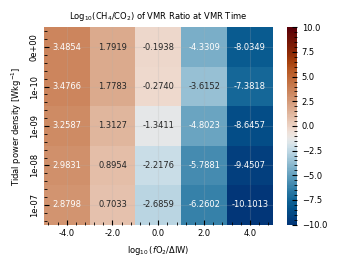

In [71]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cmcrameri.cm as cmc

plt.style.use('MJs-theme.mplstyle')


# Determine y-index map first
idx_map = {}

for i, H in enumerate(H_vals_sorted):
    for fO2_i, H_oceans, CH_ratio, SH_ratio, *_ in data_dict[H]:
        key = (fO2_i, H, H_oceans, CH_ratio, SH_ratio)
        fo2_idx = (fO2_i + 4) / 8 * 80
        H_oceans_idx = (H_oceans - 2) / 3 * 15
        
        if H_oceans != 3:
            continue
            
        fo2_idx = (fO2_i + 4) / 8 * 20
        H_oceans_idx = 0
        
        
#         if CH_ratio == 0.1:
#             H_oceans_idx = 0
#         elif CH_ratio == 0.5:
#             H_oceans_idx = 5
#         elif CH_ratio == 1:
#             H_oceans_idx = 10
#         elif CH_ratio == 2:
#             H_oceans_idx = 15    
            
#         if SH_ratio == 0.1:
#             H_oceans_idx = 0
#         elif SH_ratio == 1:
#             H_oceans_idx = 5
#         elif SH_ratio == 2:
#             H_oceans_idx = 10
#         elif SH_ratio == 3:
#             H_oceans_idx = 15  
        
        H_idx = (int(np.log10(H))+11) if H != 0 else 0
        idx = int(fo2_idx + H_oceans_idx + H_idx)
        idx_map[key] = idx

sorted_keys = sorted(idx_map.items(), key=lambda item: item[1])

# Define axis levels (order them to match your sorted_keys logic)
fO2_levels = sorted(set(key[0] for key, _ in sorted_keys))
H_levels = sorted(set(key[1] for key, _ in sorted_keys))

# Map from fO2 and H to matrix indices
fO2_idx = {val: i for i, val in enumerate(fO2_levels)}
H_idx = {val: i for i, val in enumerate(H_levels)}

# Initialize ratio matrix with NaNs
ratio_matrix = np.full((len(H_levels), len(fO2_levels)), np.nan)

for key, _ in sorted_keys:
    fO2_i, H, H_oceans, CH_ratio, SH_ratio = key
    vmr_data = vmr_dict.get(key, {})
    
    if not vmr_data:
        continue
    
    vmr_time = metrics[key][3]  # vmr_time
    if vmr_time not in vmr_data:
        # Use closest time if exact match not found
        vmr_time = min(vmr_data.keys(), key=lambda t: abs(t - vmr_time))
    
    vmrs = np.array(vmr_data[vmr_time])
    total = np.sum(vmrs)
    
    if total > 0:
        vmrs /= total
    
    try:
        co2_vmr = vmrs[vol_list.index("CO2")]
        ch4_vmr = vmrs[vol_list.index("CH4")]
    except IndexError:
        continue  # Skip if not in list

    if co2_vmr > 0:
        ratio = ch4_vmr / co2_vmr 
        i, j = H_idx[H], fO2_idx[fO2_i]
        ratio_matrix[i, j] = ratio

# Plotting heatmap
plt.figure(figsize=(3.39, 2.65))
sns.heatmap(np.log10(ratio_matrix), vmin=-10, vmax=10, center=-1, annot=True, fmt=".4f", cmap=cmc.vik,
            xticklabels=fO2_levels, yticklabels=[f"{h:.0e}" for h in H_levels])
plt.xlabel(r"$\log_{{10}}(f\mathrm{{O}}_2 / \Delta \mathrm{{IW}})$")
plt.ylabel(r"Tidal power density [$\mathrm{Wkg}^{-1}$]")
plt.title("Log$_{10}$(CH$_4$/CO$_2$) of VMR Ratio at VMR Time")
plt.tight_layout()

#plt.savefig('ATM_best_ones_V2.pgf')

plt.show()

# Figure 9

In [79]:
def get_data(root_path, N, data_dict, vmr_dict):

    for i in range(N):
        case_path = os.path.join(root_path, f"case_{i:05d}")
        config_path = os.path.join(case_path, "init_coupler.toml")
        csv_path = os.path.join(case_path, "runtime_helpfile.csv")

        if not (os.path.exists(config_path) and os.path.exists(csv_path)):
            print("Skipping ", i)
            continue

        config = toml.load(config_path)
                
        try:
            module = config["orbit"]["module"]
            H_tide = config["orbit"]["dummy"]["H_tide"]
            Phi_tide = config["orbit"]["dummy"]["Phi_tide"]
            shutdown = config["orbit"]["dummy"]["shutdown"]
        except KeyError:
            module = "none"
            H_tide = 0
            Phi_tide = "<0.3"
            shutdown = None
            
        if module == "none":
            H_tide = 0
            
        Pt_lt = bool(Phi_tide[0] == "<")
        Pt_va = float(Phi_tide[1:])
            
        fO2 = config["outgas"]["fO2_shift_IW"]
        H_oceans = config["delivery"]["elements"]["H_oceans"]
        CH_ratio = config["delivery"]["elements"]["CH_ratio"]
        SH_ratio = config["delivery"]["elements"]["SH_ratio"]
            #continue
            
#         if fO2 != 0:
#             continue           
        if H_oceans != 3:
            continue        
        if CH_ratio != 1:
            continue         
        if SH_ratio != 2:
            continue            
#         if H_tide != 1e-7:
#             continue     
        if Pt_va != 0.3:
            continue
                        
        df = pd.read_csv(csv_path, sep="\t")
        df = df[df["Time"] > 0]
        if df.empty:
            continue

        time = df["Time"]
        HC_a = df["H/C_atm"]
        H2O_a = df["H2O_mol_atm"]
        CO2_a = df["CO2_mol_atm"]
        CH4_a = df["CH4_mol_atm"]
        H2_a  = df[ "H2_mol_atm"]
        H2O_t = df["H2O_mol_total"]
        H2O_bar = df["H2O_bar"]
        rheo = df["RF_depth"]
        phi = df["Phi_global"]
        T_surf = df["T_surf"]
        #P_surf = np.array(df["F_atm"])
        
        F_asf = df["F_ins"] * 0.375 * np.cos(48.19 * np.pi/180.0)
        F_tidal = df["F_tidal"]
        F_net = df["F_atm"]
        
        F_olr = df["F_olr"]
        F_upw = df["F_olr"] + df["F_sct"]
        F_int = df["F_int"]
        F_radio = df["F_radio"]
        
        if H_tide == 0:
            E = None
        else:
            E = df["tot_tid_E"]
                   
        data_dict.setdefault(H_tide, []).append((fO2, H_oceans, CH_ratio, SH_ratio, time, case_path, phi, E))
        
        key = (fO2, H_tide, H_oceans, CH_ratio, SH_ratio)

        print(key)
        
        for _, row in df.iterrows():
            t = row["Time"]
            vmr_list = [row[vol + "_vmr"] for vol in vol_list]

            if key not in vmr_dict:
                vmr_dict[key] = {}
            vmr_dict[key][t] = vmr_list
            
            
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.ticker import LogLocator
from netCDF4 import Dataset

def read_ncdf_profile(nc_fpath):
    """Minimal reimplementation for quick P/T/Z access from AGNI/PROTEUS NetCDF."""
    if not os.path.isfile(nc_fpath):
        print(f"Missing file: {nc_fpath}")
        return None

    with Dataset(nc_fpath) as ds:
        p = np.array(ds.variables["p"][:])
        pl = np.array(ds.variables["pl"][:])
        t = np.array(ds.variables["tmp"][:])
        tl = np.array(ds.variables["tmpl"][:])
        rp = float(ds.variables["planet_radius"][0])

        if "z" in ds.variables:
            z = np.array(ds.variables["z"][:])
            zl = np.array(ds.variables["zl"][:])
            r = z + rp
            rl = zl + rp
        else:
            r = np.array(ds.variables["r"][:])
            rl = np.array(ds.variables["rl"][:])
            z = r - rp
            zl = rl - rp

        out = {"p": [pl[0]], "t": [tl[0]], "z": [zl[0]]}
        for i in range(len(p)):
            out["p"].extend([p[i], pl[i+1]])
            out["t"].extend([t[i], tl[i+1]])
            out["z"].extend([z[i], zl[i+1]])
        for key in out:
            out[key] = np.array(out[key])
        return out


In [80]:
# Define root path
root_path           = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_test_6"
root_path_final_H   = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_2V2"
root_path_final_C   = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_3"
root_path_final_S   = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_4"
root_path_final_H_2 = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_5_H"
root_path_final_C_2 = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_5_C"
root_path_final     = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_6"
root_path_final_2   = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_7V2"
root_path_final_C_2 = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_8V2"
#root_path_shutdown  = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_shutdown"

root_path_phi_tide = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_phi_tide"

# Prepare data storage
data_dict = {}
vmr_dict = {}

# Get data

get_data(root_path, 9, data_dict, vmr_dict)
get_data(root_path_final_H, 36, data_dict, vmr_dict)
get_data(root_path_final_H_2, 24, data_dict, vmr_dict)
get_data(root_path_final_2, 6, data_dict, vmr_dict)
#get_data(root_path_final_C_2, 6, data_dict, vmr_dict)

# --- Create Color Map Using Scientific Colormap ---
H_vals_sorted = sorted(data_dict)

# Replace H=0 with a small dummy value for log scale (for color map only)
H_for_log = [1e-11 if H == 0 else H for H in H_vals_sorted]
norm = plt.Normalize(vmin=np.log10(min(H_for_log)), vmax=np.log10(max(H_for_log)))

# colormap from Scientific Colour Maps
colormap = cmc.batlowK

# Apply the norm using the adjusted list
H_tide_color_map = {
    H: colormap(norm(np.log10(1e-11 if H == 0 else H)))
    for H in H_vals_sorted
}

# Get timestamps
metrics = extract_curve_metrics(data_dict, H_vals_sorted)

(-4.0, 0, 3.0, 1.0, 2.0)
(0.0, 0, 3.0, 1.0, 2.0)
(4.0, 0, 3.0, 1.0, 2.0)
(-4.0, 1e-10, 3.0, 1.0, 2.0)
(-4.0, 1e-09, 3.0, 1.0, 2.0)
(-4.0, 1e-08, 3.0, 1.0, 2.0)
(-4.0, 1e-07, 3.0, 1.0, 2.0)
(0.0, 1e-10, 3.0, 1.0, 2.0)
(0.0, 1e-09, 3.0, 1.0, 2.0)
(0.0, 1e-08, 3.0, 1.0, 2.0)
(0.0, 1e-07, 3.0, 1.0, 2.0)
(4.0, 1e-10, 3.0, 1.0, 2.0)
(4.0, 1e-09, 3.0, 1.0, 2.0)
(4.0, 1e-08, 3.0, 1.0, 2.0)
(4.0, 1e-07, 3.0, 1.0, 2.0)
(-2.0, 1e-10, 3.0, 1.0, 2.0)
(-2.0, 1e-09, 3.0, 1.0, 2.0)
(-2.0, 1e-08, 3.0, 1.0, 2.0)
(-2.0, 1e-07, 3.0, 1.0, 2.0)
(2.0, 1e-10, 3.0, 1.0, 2.0)
(2.0, 1e-09, 3.0, 1.0, 2.0)
(2.0, 1e-08, 3.0, 1.0, 2.0)
(2.0, 1e-07, 3.0, 1.0, 2.0)
(-2.0, 0, 3.0, 1.0, 2.0)
(2.0, 0, 3.0, 1.0, 2.0)


/tmp/ipykernel_3757507/75479046.py:50: RuntimeWarning: divide by zero encountered in divide
  dEdt = np.gradient(E) / np.gradient(time)
/tmp/ipykernel_3757507/75479046.py:82: RuntimeWarning: divide by zero encountered in divide
  dEdt_slice = np.gradient(E.iloc[index0:final_index]) / np.gradient(t_original)
/tmp/ipykernel_3757507/75479046.py:86: RuntimeWarning: invalid value encountered in divide
  spacing_abs = spacing_rel / np.max(spacing_rel) * 5 + 1


In [85]:
def extract_curve_metrics(data_dict, H_vals_sorted, N=30):
    """
    Extracts key timing and curve metrics from simulation data.

    Parameters:
        data_dict (dict): Dictionary of data indexed by H_tide values.
        H_vals_sorted (iterable): Sorted list of H_tide values.
        fO2 (float): Initial oxygen fugacity condition to filter data.
        N (int): Number of log-spaced points for interpolation (default: 300).

    Returns:
        base, start_times, stable_times, stop_times, sol_times, s (dicts)
    """
    
    metrics = {}
    
    for H in H_vals_sorted:
        for fO2_i, H_oceans, CH_ratio, SH_ratio, time, HC_a, phi, E in data_dict[H]:
        #for fO2_i, H_oceans, CH_ratio, SH_ratio, time, HC_a, phi, E, T_surf, P_surf in data_dict[H]:
            
            key = (fO2_i, H, H_oceans, CH_ratio, SH_ratio)         
            
            # Solidification time (phi < 0.005)
            sol_index = next((i for i, x in enumerate(phi) if x < 0.005), -1)
            
            sol_time = time.iloc[int(sol_index)]
            
            if E is not None:
                # 1. Start of tidal heating
                index0 = np.argmax(E > 0)
                start_time = time.iloc[index0]

                # 2. dE/dt
                dEdt = np.gradient(E) / np.gradient(time)

                # 3. Global maximum in dE/dt
                peak_index = np.argmax(dEdt)
                max_dEdt = dEdt[peak_index]

                # 4. Plateau start (where dE/dt ~ max_dEdt)
                threshold = 0.95 * max_dEdt
                stable_indices = np.where(dEdt > threshold)[0]
                                
                plateau_start_index = next((x for x in stable_indices), -1)#[0]
                stable_time = time.iloc[plateau_start_index]

                if dEdt[plateau_start_index]+ 10 <= 10^20:
                    continue
                
                # 5. Stop time (when dE/dt < 0.5 * max_dEdt after peak)
                decline_indices = np.where((dEdt < 0.5 * max_dEdt) & (np.arange(len(dEdt)) > peak_index))[0]
                decline_start_index = decline_indices[0] if len(decline_indices) > 0 else sol_index
                stop_time = time.iloc[decline_start_index] 

                vmr_idx, vmr_time = [(i, t) for i, t in enumerate(time) if t <= stop_time and t <= sol_time][-2]
                
                # Final index for time slicing
                
                try:
                    final_index = [i for i, dE in enumerate(dEdt) if dE > 0][-1]
                except:
                    final_index = -1
                t_original = time.iloc[index0:final_index]

                # Recompute dEdt over sliced range
                dEdt_slice = np.gradient(E.iloc[index0:final_index]) / np.gradient(t_original)

                # Relative spacing and normalization
                spacing_rel = np.cumsum(dEdt_slice)
                spacing_abs = spacing_rel / np.max(spacing_rel) * 5 + 1

                # Log-spaced time points
                t_log = np.logspace(np.log10(t_original.iloc[0]), np.log10(t_original.iloc[-1]), num=N)

                # Interpolated spacing_abs over log time
                interp_func = interp1d(t_original, spacing_abs, kind='linear', bounds_error=False, fill_value="extrapolate")
                spacing_abs_log = interp_func(t_log)
                s = (t_log, spacing_abs_log)
                
                
            else:
                start_time, stable_time, stop_time, vmr_time, s = 0, 0, 0, sol_time, np.zeros(N)           
            
            metrics[key] = (start_time, stable_time, stop_time, vmr_time, s, sol_time)

    return metrics


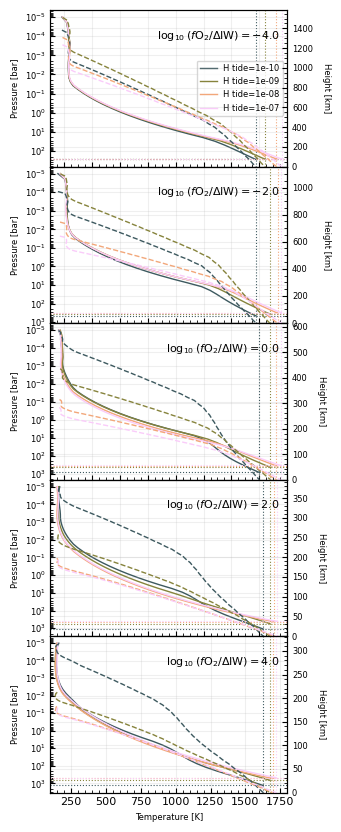

In [90]:
from matplotlib.ticker import LogLocator
import os
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('MJs-theme.mplstyle')

# --- Constants ---
fO2_vals = sorted(set(f[0] for h in data_dict.values() for f in h))
H_ref = 0

fig, axes = plt.subplots(len(fO2_vals), 1, figsize=(3.39, 8.3),
                         gridspec_kw={'hspace': 0})  # no vertical spacing
if len(fO2_vals) == 1:
    axes = [axes]

# --- First pass to find global temperature range ---
t_min, t_max = np.inf, -np.inf

for fO2 in fO2_vals:
    for H in H_vals_sorted:
        if H == 0:
            continue
        for fO2_i, H_oceans, CH_ratio, SH_ratio, time, case_path, phi, E in data_dict[H]:
            if fO2_i == fO2 and H_oceans == 3 and CH_ratio == 1 and SH_ratio == 2:
                key = (fO2_i, H, H_oceans, CH_ratio, SH_ratio)
                _, _, _, vmr_time, *_ = metrics[key]
                atm_file = os.path.join(case_path, "data", f"{int(vmr_time)}_atm.nc")
                if os.path.isfile(atm_file):
                    prof = read_ncdf_profile(atm_file)
                    t_min = min(t_min, np.nanmin(prof["t"]))
                    t_max = max(t_max, np.nanmax(prof["t"]))

# Rounded global temperature range
t_range = (np.floor(t_min / 100) * 100, np.ceil(t_max / 100) * 100)

# --- Plot ---
for idx, fO2 in enumerate(fO2_vals):
    ax_temp_p = axes[idx]
    ax_temp_z = ax_temp_p.twinx()

    for H in H_vals_sorted:
        if H == 0:
            continue
        for fO2_i, H_oceans, CH_ratio, SH_ratio, time, case_path, phi, E in data_dict[H]:
            if fO2_i == fO2 and H_oceans == 3 and CH_ratio == 1 and SH_ratio == 2:
                key = (fO2_i, H, H_oceans, CH_ratio, SH_ratio)
                _, _, _, vmr_time, *_ = metrics[key]

                atm_file = os.path.join(case_path, "data", f"{int(vmr_time)}_atm.nc")
                if not os.path.isfile(atm_file):
                    continue

                prof = read_ncdf_profile(atm_file)
                color = H_tide_color_map[H]
                label = f"H tide={H:.0e}" if idx == 0 else None

                # Plot temperature vs pressure and height
                ax_temp_p.plot(prof["t"], prof["p"] / 1e5, label=label, color=color)
                ax_temp_z.plot(prof["t"], prof["z"] / 1e3, linestyle="--", color=color)

                # Vertical line at surface temperature
                T_surface = prof["t"][-1]
                ax_temp_p.axvline(T_surface, color=color, linestyle=":", linewidth=0.8)
               
                P_surface = prof["p"][-1] / 1e5  # [bar]
                ax_temp_p.axhline(P_surface, color=color, linestyle=":", linewidth=0.8)
            
                break

    # Title inside plot as annotation
    ax_temp_p.text(0.97, 0.88,
                   rf"$\log_{{10}}(f\mathrm{{O}}_2 / \Delta \mathrm{{IW}}) = {fO2}$",
                   transform=ax_temp_p.transAxes,
                   ha='right', va='top', fontsize=8)

    # Axis formatting
    ax_temp_p.set_xlim(t_range)
    ax_temp_p.set_yscale("log")
    ax_temp_p.invert_yaxis()
    ax_temp_p.yaxis.set_major_locator(LogLocator(numticks=999))
    ax_temp_z.set_ylim(bottom=0)

    ax_temp_p.set_ylabel("Pressure [bar]")
    ax_temp_z.set_ylabel("Height [km]", rotation=270, labelpad=13)
        
    
    # Labeling
    if idx == len(fO2_vals) - 1:
        ax_temp_p.set_xlabel("Temperature [K]")
        ax_temp_p.tick_params(axis='x', labelsize=8)
    else:
        ax_temp_p.set_xticklabels([])  # hide x tick labels

    
    if idx == 0:
        ax_temp_p.legend(fontsize=6, loc='center right')

fig.tight_layout()

plt.savefig('P_T_plot.pgf')

plt.show()


# Appendix

# Figure 17

In [3]:
def get_data(root_path, N, data_dict, vmr_dict):

    for i in range(N):
        case_path = os.path.join(root_path, f"case_{i:05d}")
        config_path = os.path.join(case_path, "init_coupler.toml")
        csv_path = os.path.join(case_path, "runtime_helpfile.csv")

        if not (os.path.exists(config_path) and os.path.exists(csv_path)):
            print("Skipping ", i)
            continue

        config = toml.load(config_path)
                
        try:
            module = config["orbit"]["module"]
        except KeyError:
            module = "none"
        try:
            H_tide = config["orbit"]["dummy"]["H_tide"]
        except KeyError:
            H_tide = 0
        try:
            Phi_tide = config["orbit"]["dummy"]["Phi_tide"]
        except KeyError:
            Phi_tide = "<0.3"
        try:
            shutdown = config["orbit"]["dummy"]["shutdown"]
        except KeyError:
            shutdown = None          
            
        if module == "none":
            H_tide = 0
            
        Pt_lt = bool(Phi_tide[0] == "<")
        Pt_va = float(Phi_tide[1:])
            
        fO2 = config["outgas"]["fO2_shift_IW"]
        H_oceans = config["delivery"]["elements"]["H_oceans"]
        CH_ratio = config["delivery"]["elements"]["CH_ratio"]
        SH_ratio = config["delivery"]["elements"]["SH_ratio"]
           
        if H_oceans != 3:
            continue    
#         if CH_ratio != 1:
#             continue         
        if SH_ratio != 2:
            continue          
        if Pt_va != 0.3:
            continue
                        
        df = pd.read_csv(csv_path, sep="\t")
        df = df[df["Time"] > 0]
        if df.empty:
            continue

        time = df["Time"]
        HC_a = df["H/C_atm"]
        H2O_a = df["H2O_mol_atm"]
        CO2_a = df["CO2_mol_atm"]
        CH4_a = df["CH4_mol_atm"]
        H2_a  = df[ "H2_mol_atm"]
        H2O_t = df["H2O_mol_total"]
        H2O_bar = df["H2O_bar"]
        rheo = df["RF_depth"]
        phi = df["Phi_global"]
        T_surf = df["T_surf"]
        #P_surf = np.array(df["F_atm"])
        
        F_asf = df["F_ins"] * 0.375 * np.cos(48.19 * np.pi/180.0)
        F_tidal = df["F_tidal"]
        F_net = df["F_atm"]
        
        F_olr = df["F_olr"]
        F_upw = df["F_olr"] + df["F_sct"]
        F_int = df["F_int"]
        F_radio = df["F_radio"]
        
        if H_tide == 0:
            E = None
        else:
            E = df["tot_tid_E"]
            
        data_dict.setdefault(H_tide, []).append((fO2, H_oceans, CH_ratio, SH_ratio, time, 1-rheo, phi, E)) 
        
        key = (fO2, H_tide, H_oceans, CH_ratio, SH_ratio)

        for _, row in df.iterrows():
            t = row["Time"]
            vmr_list = [row[vol + "_vmr"] for vol in vol_list]

            if key not in vmr_dict:
                vmr_dict[key] = {}
            vmr_dict[key][t] = vmr_list

In [4]:
# Define root path
root_path           = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_test_6"
root_path_final_H   = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_2V2"
root_path_final_C   = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_3"
root_path_final_S   = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_4"
root_path_final_H_2 = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_5_H"
root_path_final_C_2 = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_5_C"
root_path_final     = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_6"
root_path_final_2   = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_7V2"
root_path_final_C_2_2 = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_8V2"

# Prepare data storage
data_dict = {}
vmr_dict = {}

# Get data
get_data(root_path, 9, data_dict, vmr_dict)

get_data(root_path_final_H, 36, data_dict, vmr_dict)
get_data(root_path_final_C, 36, data_dict, vmr_dict)
get_data(root_path_final_S, 36, data_dict, vmr_dict)
get_data(root_path_final_H_2, 24, data_dict, vmr_dict)
get_data(root_path_final_C_2, 24, data_dict, vmr_dict)
get_data(root_path_final, 15, data_dict, vmr_dict)
get_data(root_path_final_2, 6, data_dict, vmr_dict)
get_data(root_path_final_C_2_2, 6, data_dict, vmr_dict)

# --- Create Color Map Using Scientific Colormap ---
H_vals_sorted = sorted(data_dict)

# Replace H=0 with a small dummy value for log scale (for color map only)
H_for_log = [1e-11 if H == 0 else H for H in H_vals_sorted]
norm = plt.Normalize(vmin=np.log10(min(H_for_log)), vmax=np.log10(max(H_for_log)))

# colormap from Scientific Colour Maps
colormap = cmc.batlowK

# Apply the norm using the adjusted list
H_tide_color_map = {
    H: colormap(norm(np.log10(1e-11 if H == 0 else H)))
    for H in H_vals_sorted
}

# Get timestamps
metrics = extract_curve_metrics(data_dict, H_vals_sorted)

Skipping  1
Skipping  3
Skipping  1
Skipping  2
Skipping  3
Skipping  0


/tmp/ipykernel_3770020/75479046.py:50: RuntimeWarning: divide by zero encountered in divide
  dEdt = np.gradient(E) / np.gradient(time)
/tmp/ipykernel_3770020/75479046.py:82: RuntimeWarning: divide by zero encountered in divide
  dEdt_slice = np.gradient(E.iloc[index0:final_index]) / np.gradient(t_original)
/tmp/ipykernel_3770020/75479046.py:86: RuntimeWarning: invalid value encountered in divide
  spacing_abs = spacing_rel / np.max(spacing_rel) * 5 + 1


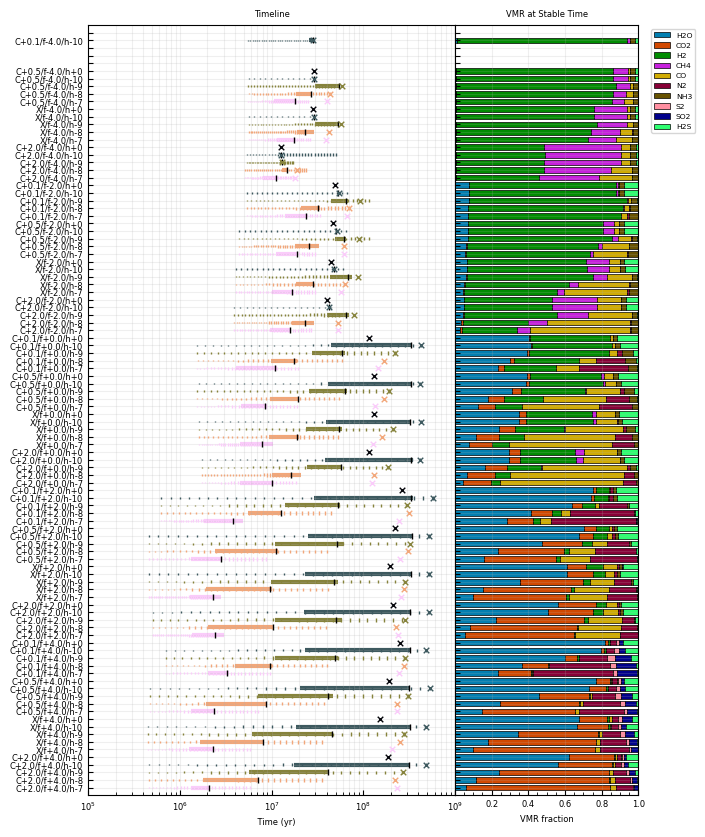

In [5]:
plt.style.use('MJs-theme.mplstyle')

# Determine y-index map first
idx_map = {}

for i, H in enumerate(H_vals_sorted):
    for fO2_i, H_oceans, CH_ratio, SH_ratio, *_ in data_dict[H]:
        key = (fO2_i, H, H_oceans, CH_ratio, SH_ratio)
        fo2_idx = (fO2_i + 4) / 8 * 80
        #H_oceans_idx = (H_oceans - 2) / 3 * 15
        
#         if H_oceans != 3:
#             continue
            
#         fo2_idx = (fO2_i + 4) / 8 * 20
#         H_oceans_idx = 0
        
        
#         if H_oceans == 2:
#             H_oceans_idx = 0
#         elif H_oceans == 3:
#             H_oceans_idx = 5
#         elif H_oceans == 5:
#             H_oceans_idx = 10           
            
        if CH_ratio == 0.1:
            H_oceans_idx = 0
        elif CH_ratio == 0.5:
            H_oceans_idx = 5
        elif CH_ratio == 1:
            H_oceans_idx = 10
        elif CH_ratio == 2:
            H_oceans_idx = 15       
            
#         if SH_ratio == 0.1:
#             H_oceans_idx = 0
#         elif SH_ratio == 1:
#             H_oceans_idx = 5
#         elif SH_ratio == 2:
#             H_oceans_idx = 10
#         elif SH_ratio == 3:
#             H_oceans_idx = 15  
        
        H_idx = (int(np.log10(H))+11) if H != 0 else 0
        idx = int(fo2_idx + H_oceans_idx + H_idx)
        idx_map[key] = idx

# Sort keys by idx
sorted_keys = sorted(idx_map.items(), key=lambda item: item[1])

def plot_figure(selected_items, N, annotations=False):
    gs = GridSpec(1, 2, width_ratios=[2, 1], wspace=0)

    ax_timeline = fig.add_subplot(gs[0, 0])
    ax_vmr = fig.add_subplot(gs[0, 1])

    bar_y = np.arange(N)
    ytick_labels = ["" for _ in range(N)]

    first_it = True

    for plot_idx, (key, local_idx) in enumerate(selected_items):
        fO2_i, H, H_oceans, CH_ratio, SH_ratio = key
        label = get_case_label(*key)
        ytick_labels[local_idx] = label
        y = bar_y[local_idx]

        color_H = H_tide_color_map[H]
        start_time, stable_time, stop_time, vmr_time, s, sol_time = metrics[key]
                
        if H != 0:
            if start_time < stable_time:
                ax_timeline.scatter(s[0], y*np.ones(len(s[0])), color=color_H, s=s[1], marker='|', zorder=10)

            if stable_time < stop_time:
                ax_timeline.hlines(y, stable_time, stop_time, color=color_H, linestyle='-', linewidth=3, zorder=1)
            
            ax_timeline.scatter(vmr_time, y, color='black', marker='|', zorder=10)
                        
        ax_timeline.scatter(sol_time, y, color=color_H, marker='x', zorder=10)

        bar_data = vmr_dict.get(key, {})
        if not bar_data:
            continue

        if vmr_time in bar_data:
            vmr_mid = np.array(bar_data[vmr_time])
        else:
            nearest_time = min(bar_data.keys(), key=lambda t: abs(t - vmr_time))
            vmr_mid = np.array(bar_data[nearest_time])

        total_mid = np.sum(vmr_mid)
        vmr_mid = vmr_mid / total_mid if total_mid > 0 else np.zeros_like(vmr_mid)

        colors = [color_map.get(vol, "#cccccc") for vol in vol_list]

        x_left = 0
        for vmr_val, (j, color) in zip(vmr_mid, enumerate(colors)):
            if vmr_val > 0:
                ax_vmr.barh(
                    y,
                    vmr_val,
                    left=x_left,
                    height=0.73,
                    color=color,
                    edgecolor='black',
                    linewidth=0.5,
                    label=vol_list[j] if first_it else None
                )
                x_left += vmr_val

        first_it = False

    # Axis setup
    ax_timeline.set_xscale("log")
    ax_timeline.set_xlim(1e5, 1e9)
    ax_timeline.set_ylim(N, -1)
    ax_timeline.set_yticks(bar_y)
    ax_timeline.set_yticklabels(ytick_labels)
    ax_timeline.set_xlabel("    Time (yr)")
    ax_timeline.set_title("Timeline")
    ax_timeline.grid(which='both', axis='both', alpha=0.2)

    ax_timeline.yaxis.set_minor_locator(plt.NullLocator())
    
    ax_vmr.set_ylim(N, -1)
    ax_vmr.set_yticks(bar_y)
    ax_vmr.set_yticklabels([])  # y-labels already on left
    ax_vmr.set_xlabel("VMR fraction")
    ax_vmr.set_xlim(0, 1.0)
    
    ax_vmr.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax_vmr.set_xticklabels(["", "0.2", "0.4", "0.6", "0.8", "1.0"])
    ax_vmr.set_title("VMR at Stable Time")
    ax_vmr.grid(axis='x', alpha=0.2)

    ax_vmr.yaxis.set_minor_locator(plt.NullLocator())
        
    handles, labels = ax_vmr.get_legend_handles_labels()
    if handles:
        ax_vmr.legend(handles, labels, bbox_to_anchor=(1.05, 1.0), loc='upper left')
        
    if annotations:
        colors = [color_map.get(vol, "#cccccc") for vol in vol_list]
                
        # Choose a specific key to annotate
        key_to_annotate = sorted_keys[-1][0]  # for example, the 11th item
        start_time, stable_time, stop_time, vmr_time, s, sol_time = metrics[key_to_annotate]
        local_idx = idx_map[key_to_annotate]
        y = bar_y[local_idx]       

        color = "black"
        #color = H_tide_color_map[1e-7]
        color_bkg = "white"
        
        ax_timeline.annotate('Start Tidal Heating',
            xy=(start_time, y), xycoords='data',
            xytext=(-28, -17), textcoords='offset points',
            bbox=dict(boxstyle="round", fc=color_bkg, ec=color, lw=1),
            arrowprops=dict(arrowstyle="-", relpos=(0.5, 1), color=color))

        from matplotlib.patches import FancyArrowPatch

        # Define coordinates
        start = (0.75 * vmr_time, y + 0.5)  # data point to annotate
        end = ax_timeline.transData.transform(start) + np.array([70, -27])  # offset in screen coords
        end = ax_timeline.transData.inverted().transform(end)  # convert back to data coords
        end_2 = ax_timeline.transData.transform(start) + np.array([0, -27])  # offset in screen coords
        end_2 = ax_timeline.transData.inverted().transform(end_2)  # convert back to data coords

        # Draw the arrow
        arrow = FancyArrowPatch(
            posA=end_2,  # tail
            posB=start,  # head (arrow points to the data point)
            arrowstyle='-[',  # bracket arrow
            mutation_scale=12,  # overall size of arrow
            lw=1.5,
            color=color
        )
        ax_timeline.add_patch(arrow)

        # Draw the text box
        ax_timeline.text(
            end[0], end[1], 'Global Radiative Equilibrium epoch',
            bbox=dict(boxstyle="round", fc=color_bkg, ec=color, lw=1),
            ha='center', va='top'
        )

        
        ax_timeline.annotate('VMR time',
            xy=(vmr_time, y), xycoords='data',
            xytext=(0, -17), textcoords='offset points',
            bbox=dict(boxstyle="round", fc=color_bkg, ec=color, lw=1),
            arrowprops=dict(arrowstyle="-", relpos=(0, 1), color=color))
        
        ax_timeline.annotate('End Tidal Heating',
            xy=(s[0][-1], y), xycoords='data',
            xytext=(20, -17), textcoords='offset points',
            bbox=dict(boxstyle="round", fc=color_bkg, ec=color, lw=1),
            arrowprops=dict(arrowstyle="-", relpos=(0, 1), color=color))
        
        lbl = r'$\phi \leq 0.005$'
        
        ax_timeline.annotate(lbl,
            xy=(sol_time, y), xycoords='data',
            xytext=(-20, -17), textcoords='offset points',
            bbox=dict(boxstyle="round", fc=color_bkg, ec=color, lw=1),
            arrowprops=dict(arrowstyle="-", relpos=(0.67, 1), color=color))

#     ax_timeline.text(5e8, 26.5, "A", fontsize=12)
#     ax_vmr.text(0.05, 26.5, "B", fontsize=12)
        
    #plt.savefig('timeline+VMR_C_final.pgf')
        
    #plt.suptitle(fig_title)
    plt.show()

fig = plt.figure(figsize=(7.1, 10))
plot_figure(sorted_keys, 100)

# Figure 18

In [6]:
def get_data(root_path, N, data_dict, vmr_dict):

    for i in range(N):
        case_path = os.path.join(root_path, f"case_{i:05d}")
        config_path = os.path.join(case_path, "init_coupler.toml")
        csv_path = os.path.join(case_path, "runtime_helpfile.csv")

        if not (os.path.exists(config_path) and os.path.exists(csv_path)):
            print("Skipping ", i)
            continue

        config = toml.load(config_path)
                
        try:
            module = config["orbit"]["module"]
        except KeyError:
            module = "none"
        try:
            H_tide = config["orbit"]["dummy"]["H_tide"]
        except KeyError:
            H_tide = 0
        try:
            Phi_tide = config["orbit"]["dummy"]["Phi_tide"]
        except KeyError:
            Phi_tide = "<0.3"
        try:
            shutdown = config["orbit"]["dummy"]["shutdown"]
        except KeyError:
            shutdown = None          
            
        if module == "none":
            H_tide = 0
            
        Pt_lt = bool(Phi_tide[0] == "<")
        Pt_va = float(Phi_tide[1:])
            
        fO2 = config["outgas"]["fO2_shift_IW"]
        H_oceans = config["delivery"]["elements"]["H_oceans"]
        CH_ratio = config["delivery"]["elements"]["CH_ratio"]
        SH_ratio = config["delivery"]["elements"]["SH_ratio"]
           
        if H_oceans != 3:
            continue    
        if CH_ratio != 1:
            continue         
#         if SH_ratio != 2:
#             continue          
        if Pt_va != 0.3:
            continue
                        
        df = pd.read_csv(csv_path, sep="\t")
        df = df[df["Time"] > 0]
        if df.empty:
            continue

        time = df["Time"]
        HC_a = df["H/C_atm"]
        H2O_a = df["H2O_mol_atm"]
        CO2_a = df["CO2_mol_atm"]
        CH4_a = df["CH4_mol_atm"]
        H2_a  = df[ "H2_mol_atm"]
        H2O_t = df["H2O_mol_total"]
        H2O_bar = df["H2O_bar"]
        rheo = df["RF_depth"]
        phi = df["Phi_global"]
        T_surf = df["T_surf"]
        #P_surf = np.array(df["F_atm"])
        
        F_asf = df["F_ins"] * 0.375 * np.cos(48.19 * np.pi/180.0)
        F_tidal = df["F_tidal"]
        F_net = df["F_atm"]
        
        F_olr = df["F_olr"]
        F_upw = df["F_olr"] + df["F_sct"]
        F_int = df["F_int"]
        F_radio = df["F_radio"]
        
        if H_tide == 0:
            E = None
        else:
            E = df["tot_tid_E"]
            
        data_dict.setdefault(H_tide, []).append((fO2, H_oceans, CH_ratio, SH_ratio, time, 1-rheo, phi, E)) 
        
        key = (fO2, H_tide, H_oceans, CH_ratio, SH_ratio)

        for _, row in df.iterrows():
            t = row["Time"]
            vmr_list = [row[vol + "_vmr"] for vol in vol_list]

            if key not in vmr_dict:
                vmr_dict[key] = {}
            vmr_dict[key][t] = vmr_list

In [7]:
# Define root path
root_path           = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_test_6"
root_path_final_H   = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_2V2"
root_path_final_C   = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_3"
root_path_final_S   = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_4"
root_path_final_H_2 = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_5_H"
root_path_final_C_2 = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_5_C"
root_path_final     = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_6"
root_path_final_2   = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_7V2"
root_path_final_C_2_2 = "/dataserver/users/formingworlds/mrdijk/PROTEUS/output/scratch/grid_final_8V2"

# Prepare data storage
data_dict = {}
vmr_dict = {}

# Get data
get_data(root_path, 9, data_dict, vmr_dict)

get_data(root_path_final_H, 36, data_dict, vmr_dict)
get_data(root_path_final_C, 36, data_dict, vmr_dict)
get_data(root_path_final_S, 36, data_dict, vmr_dict)
get_data(root_path_final_H_2, 24, data_dict, vmr_dict)
get_data(root_path_final_C_2, 24, data_dict, vmr_dict)
get_data(root_path_final, 15, data_dict, vmr_dict)
get_data(root_path_final_2, 6, data_dict, vmr_dict)
get_data(root_path_final_C_2_2, 6, data_dict, vmr_dict)

# --- Create Color Map Using Scientific Colormap ---
H_vals_sorted = sorted(data_dict)

# Replace H=0 with a small dummy value for log scale (for color map only)
H_for_log = [1e-11 if H == 0 else H for H in H_vals_sorted]
norm = plt.Normalize(vmin=np.log10(min(H_for_log)), vmax=np.log10(max(H_for_log)))

# colormap from Scientific Colour Maps
colormap = cmc.batlowK

# Apply the norm using the adjusted list
H_tide_color_map = {
    H: colormap(norm(np.log10(1e-11 if H == 0 else H)))
    for H in H_vals_sorted
}

# Get timestamps
metrics = extract_curve_metrics(data_dict, H_vals_sorted)

Skipping  1
Skipping  3
Skipping  1
Skipping  2
Skipping  3
Skipping  0


/tmp/ipykernel_3770020/75479046.py:50: RuntimeWarning: divide by zero encountered in divide
  dEdt = np.gradient(E) / np.gradient(time)
/tmp/ipykernel_3770020/75479046.py:82: RuntimeWarning: divide by zero encountered in divide
  dEdt_slice = np.gradient(E.iloc[index0:final_index]) / np.gradient(t_original)
/tmp/ipykernel_3770020/75479046.py:86: RuntimeWarning: invalid value encountered in divide
  spacing_abs = spacing_rel / np.max(spacing_rel) * 5 + 1


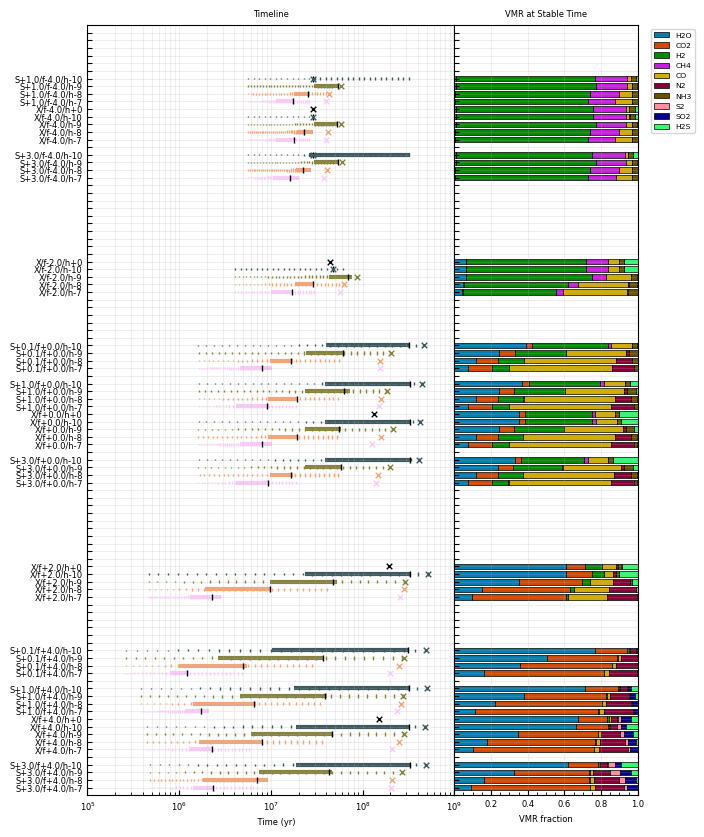

In [9]:
plt.style.use('MJs-theme.mplstyle')

# Determine y-index map first
idx_map = {}

for i, H in enumerate(H_vals_sorted):
    for fO2_i, H_oceans, CH_ratio, SH_ratio, *_ in data_dict[H]:
        key = (fO2_i, H, H_oceans, CH_ratio, SH_ratio)
        fo2_idx = (fO2_i + 4) / 8 * 80
        #H_oceans_idx = (H_oceans - 2) / 3 * 15
        
#         if H_oceans != 3:
#             continue
            
#         fo2_idx = (fO2_i + 4) / 8 * 20
#         H_oceans_idx = 0
        
        
#         if H_oceans == 2:
#             H_oceans_idx = 0
#         elif H_oceans == 3:
#             H_oceans_idx = 5
#         elif H_oceans == 5:
#             H_oceans_idx = 10           
            
#         if CH_ratio == 0.1:
#             H_oceans_idx = 0
#         elif CH_ratio == 0.5:
#             H_oceans_idx = 5
#         elif CH_ratio == 1:
#             H_oceans_idx = 10
#         elif CH_ratio == 2:
#             H_oceans_idx = 15       
            
        if SH_ratio == 0.1:
            H_oceans_idx = 0
        elif SH_ratio == 1:
            H_oceans_idx = 5
        elif SH_ratio == 2:
            H_oceans_idx = 10
        elif SH_ratio == 3:
            H_oceans_idx = 15  
        
        H_idx = (int(np.log10(H))+11) if H != 0 else 0
        idx = int(fo2_idx + H_oceans_idx + H_idx)
        idx_map[key] = idx

# Sort keys by idx
sorted_keys = sorted(idx_map.items(), key=lambda item: item[1])

def plot_figure(selected_items, N, annotations=False):
    gs = GridSpec(1, 2, width_ratios=[2, 1], wspace=0)

    ax_timeline = fig.add_subplot(gs[0, 0])
    ax_vmr = fig.add_subplot(gs[0, 1])

    bar_y = np.arange(N)
    ytick_labels = ["" for _ in range(N)]

    first_it = True

    for plot_idx, (key, local_idx) in enumerate(selected_items):
        fO2_i, H, H_oceans, CH_ratio, SH_ratio = key
        label = get_case_label(*key)
        ytick_labels[local_idx] = label
        y = bar_y[local_idx]

        color_H = H_tide_color_map[H]
        start_time, stable_time, stop_time, vmr_time, s, sol_time = metrics[key]
                
        if H != 0:
            if start_time < stable_time:
                ax_timeline.scatter(s[0], y*np.ones(len(s[0])), color=color_H, s=s[1], marker='|', zorder=10)

            if stable_time < stop_time:
                ax_timeline.hlines(y, stable_time, stop_time, color=color_H, linestyle='-', linewidth=3, zorder=1)
            
            ax_timeline.scatter(vmr_time, y, color='black', marker='|', zorder=10)
                        
        ax_timeline.scatter(sol_time, y, color=color_H, marker='x', zorder=10)

        bar_data = vmr_dict.get(key, {})
        if not bar_data:
            continue

        if vmr_time in bar_data:
            vmr_mid = np.array(bar_data[vmr_time])
        else:
            nearest_time = min(bar_data.keys(), key=lambda t: abs(t - vmr_time))
            vmr_mid = np.array(bar_data[nearest_time])

        total_mid = np.sum(vmr_mid)
        vmr_mid = vmr_mid / total_mid if total_mid > 0 else np.zeros_like(vmr_mid)

        colors = [color_map.get(vol, "#cccccc") for vol in vol_list]

        x_left = 0
        for vmr_val, (j, color) in zip(vmr_mid, enumerate(colors)):
            if vmr_val > 0:
                ax_vmr.barh(
                    y,
                    vmr_val,
                    left=x_left,
                    height=0.73,
                    color=color,
                    edgecolor='black',
                    linewidth=0.5,
                    label=vol_list[j] if first_it else None
                )
                x_left += vmr_val

        first_it = False

    # Axis setup
    ax_timeline.set_xscale("log")
    ax_timeline.set_xlim(1e5, 1e9)
    ax_timeline.set_ylim(N, -1)
    ax_timeline.set_yticks(bar_y)
    ax_timeline.set_yticklabels(ytick_labels)
    ax_timeline.set_xlabel("    Time (yr)")
    ax_timeline.set_title("Timeline")
    ax_timeline.grid(which='both', axis='both', alpha=0.2)

    ax_timeline.yaxis.set_minor_locator(plt.NullLocator())
    
    ax_vmr.set_ylim(N, -1)
    ax_vmr.set_yticks(bar_y)
    ax_vmr.set_yticklabels([])  # y-labels already on left
    ax_vmr.set_xlabel("VMR fraction")
    ax_vmr.set_xlim(0, 1.0)
    
    ax_vmr.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax_vmr.set_xticklabels(["", "0.2", "0.4", "0.6", "0.8", "1.0"])
    ax_vmr.set_title("VMR at Stable Time")
    ax_vmr.grid(axis='x', alpha=0.2)

    ax_vmr.yaxis.set_minor_locator(plt.NullLocator())
        
    handles, labels = ax_vmr.get_legend_handles_labels()
    if handles:
        ax_vmr.legend(handles, labels, bbox_to_anchor=(1.05, 1.0), loc='upper left')
        
    if annotations:
        colors = [color_map.get(vol, "#cccccc") for vol in vol_list]
                
        # Choose a specific key to annotate
        key_to_annotate = sorted_keys[-1][0]  # for example, the 11th item
        start_time, stable_time, stop_time, vmr_time, s, sol_time = metrics[key_to_annotate]
        local_idx = idx_map[key_to_annotate]
        y = bar_y[local_idx]       

        color = "black"
        #color = H_tide_color_map[1e-7]
        color_bkg = "white"
        
        ax_timeline.annotate('Start Tidal Heating',
            xy=(start_time, y), xycoords='data',
            xytext=(-28, -17), textcoords='offset points',
            bbox=dict(boxstyle="round", fc=color_bkg, ec=color, lw=1),
            arrowprops=dict(arrowstyle="-", relpos=(0.5, 1), color=color))

        from matplotlib.patches import FancyArrowPatch

        # Define coordinates
        start = (0.75 * vmr_time, y + 0.5)  # data point to annotate
        end = ax_timeline.transData.transform(start) + np.array([70, -27])  # offset in screen coords
        end = ax_timeline.transData.inverted().transform(end)  # convert back to data coords
        end_2 = ax_timeline.transData.transform(start) + np.array([0, -27])  # offset in screen coords
        end_2 = ax_timeline.transData.inverted().transform(end_2)  # convert back to data coords

        # Draw the arrow
        arrow = FancyArrowPatch(
            posA=end_2,  # tail
            posB=start,  # head (arrow points to the data point)
            arrowstyle='-[',  # bracket arrow
            mutation_scale=12,  # overall size of arrow
            lw=1.5,
            color=color
        )
        ax_timeline.add_patch(arrow)

        # Draw the text box
        ax_timeline.text(
            end[0], end[1], 'Global Radiative Equilibrium epoch',
            bbox=dict(boxstyle="round", fc=color_bkg, ec=color, lw=1),
            ha='center', va='top'
        )

        
        ax_timeline.annotate('VMR time',
            xy=(vmr_time, y), xycoords='data',
            xytext=(0, -17), textcoords='offset points',
            bbox=dict(boxstyle="round", fc=color_bkg, ec=color, lw=1),
            arrowprops=dict(arrowstyle="-", relpos=(0, 1), color=color))
        
        ax_timeline.annotate('End Tidal Heating',
            xy=(s[0][-1], y), xycoords='data',
            xytext=(20, -17), textcoords='offset points',
            bbox=dict(boxstyle="round", fc=color_bkg, ec=color, lw=1),
            arrowprops=dict(arrowstyle="-", relpos=(0, 1), color=color))
        
        lbl = r'$\phi \leq 0.005$'
        
        ax_timeline.annotate(lbl,
            xy=(sol_time, y), xycoords='data',
            xytext=(-20, -17), textcoords='offset points',
            bbox=dict(boxstyle="round", fc=color_bkg, ec=color, lw=1),
            arrowprops=dict(arrowstyle="-", relpos=(0.67, 1), color=color))

#     ax_timeline.text(5e8, 26.5, "A", fontsize=12)
#     ax_vmr.text(0.05, 26.5, "B", fontsize=12)
        
    plt.savefig('timeline+VMR_S_final.pgf')
        
    #plt.suptitle(fig_title)
    plt.show()

fig = plt.figure(figsize=(7.1, 10))
plot_figure(sorted_keys, 100)